In [ ]:
import this

# What is this code doing?

* Divides dataset to 10 category in simulation.

* Trains GM.

* Prunes GM & Show Results.

* Shows participation & global sparsity results.

* Use standart Federated Learning as baseline.

***
### Core contributions:

* Pruning increase model sparsification significantly while still preserve a good performance. 

* Thus, to use in Federated Learning system, a group of talented devices in terms of hardware can train a dense model and then gradually rise sparsification threshold of model to assign them as proper initial global model for model contrainted devices. 

* As a result, those assigned proper models own tuned parameters from previous training, which act as transfer learning and increase model generality (1). Moreover, number of devices participate to Federated Learning system is increased by using a trainable model (2).

* Beside, our model works with quantisation method as well, by representing 32 float bits with smaller integer bits. Thus, reduce training time and communication overhead.

* Furthermore, since each device trains their proper model, syncronisation during training is also rises.

***
# Install Necessary Libraries:

In [1]:
!pip install -U flwr["simulation"]

Defaulting to user installation because normal site-packages is not writeable
  Using cached flwr-1.3.0-py3-none-any.whl (139 kB)


In [2]:
!pip install -U flwr==0.19.0

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 3.2 MB/s eta 0:00:00
  Attempting uninstall: flwr
    Found existing installation: flwr 1.3.0
    Uninstalling flwr-1.3.0:
      Successfully uninstalled flwr-1.3.0


In [3]:
!pip install torch==1.13.1 torchvision==0.14.1 numpy==1.24.1 pandas==1.5.3 matplotlib==3.6.3

Defaulting to user installation because normal site-packages is not writeable


***
## 1- Importing Libraries:

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
import torchvision.models as models
import torchvision

import torch.nn.utils.prune as prune


import flwr as fl

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from collections import OrderedDict
from typing import Dict, List, Optional, Tuple
import json
import os

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE}")

Training on cpu


In [5]:
print(fl.__version__, torch.__version__, torchvision.__version__, np.__version__, pd.__version__,
json.__version__, matplotlib.__version__)

library_versions = {"flwr": fl.__version__, "torch": torch.__version__, 
                    "torchvision": torchvision.__version__, "numpy": np.__version__, 
                    "pandas": pd.__version__, "json": json.__version__, 
                    "matplotlib": matplotlib.__version__}

with open('library_versions.txt', 'w') as f:
    f.write(json.dumps(library_versions))

f.close()

0.19.0 1.13.1+cu117 0.14.1+cu117 1.24.1 1.5.3 2.0.9 3.6.3


***
## 2- Initilisation/Hyperparameters:

In [3]:
# Total number of devices (For D1 devices):
NUM_DEVICES = 100

# Model aggregation (Training round):
NUM_ROUNDS = 100

# On device local updates:
LOCAL_EPOCH = 3

# You may need to decrease it since total image per device is 60.
BATCH_SIZE = 64

# D1, D2, D3, ... , D10:
NUM_DEVICE_TYPE = 10

hyperparameters = {'NUM_DEVICES': NUM_DEVICES,
                   'NUM_ROUNDS': NUM_ROUNDS,
                   'NUM_DEVICE_TYPE': NUM_DEVICE_TYPE,
                   'BATCH_SIZE': BATCH_SIZE,
                   'LOCAL_EPOCH': LOCAL_EPOCH}

with open('hyperparameters.txt', 'w') as f:
    f.write(json.dumps(hyperparameters))

f.close()

***
## 3- Load Datasets:

In [4]:
def load_datasets(num_clients: int):
    
    
    # ######################## Test Dataset Preparetion #########################
    testset = torchvision.datasets.MNIST("./data", 
                                         train = False, 
                                         transform = transforms.Compose([transforms.Resize((32,32)),
                                                                         transforms.ToTensor(),
                                                                         transforms.Normalize(mean = (0.1325,), 
                                                                                              std = (0.3105,))]),
                                         download=True)
    
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    
    
    # #################### Train and Val Datasets Preparetion ####################
    trainset = torchvision.datasets.MNIST("./data", 
                                          train = True, 
                                          transform = transforms.Compose([transforms.Resize((32,32)),
                                                                          transforms.ToTensor(),
                                                                          transforms.Normalize(mean = (0.1307,), 
                                                                                               std = (0.3081,))]),
                                          download=True)
    
    plan = num_clients * NUM_DEVICE_TYPE
    partition_size = len(trainset) // plan
    lengths = [partition_size] * plan
    # plan = num_clients * 2
    # partition_size = len(trainset) // plan
    # lengths = [partition_size] * plan
    # partition_size = len(trainset) // num_clients
    # lengths = [partition_size] * num_clients
    
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    
    trainloaders_1, valloaders_1 = [], []
    trainloaders_2, valloaders_2 = [], []
    trainloaders_3, valloaders_3 = [], []
    trainloaders_4, valloaders_4 = [], []
    trainloaders_5, valloaders_5 = [], []
    trainloaders_6, valloaders_6 = [], []
    trainloaders_7, valloaders_7 = [], []
    trainloaders_8, valloaders_8 = [], []
    trainloaders_9, valloaders_9 = [], []
    trainloaders_10, valloaders_10 = [], []

    
    # The amount of data should be shared per device class (D1, D2, ... , D10):
    amount = (len(datasets) // NUM_DEVICE_TYPE)
    
    # Sharing dataset to devices:
    for i, ds in enumerate(datasets):
        len_val = len(ds) // 10  
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]

        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))

        # D1 devices:
        if (amount*0 <= i) and (i < amount*1):
            trainloaders_1.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
            valloaders_1.append(DataLoader(ds_val, batch_size=BATCH_SIZE))

        # D2 devices:
        elif (amount*1 <= i) and (i < amount*2):
            trainloaders_2.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
            valloaders_2.append(DataLoader(ds_val, batch_size=BATCH_SIZE))

        # D3 devices:
        elif (amount*2 <= i) and (i < amount*3):
            trainloaders_3.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
            valloaders_3.append(DataLoader(ds_val, batch_size=BATCH_SIZE))

        # D4 devices:    
        elif (amount*3 <= i) and (i < amount*4):
            trainloaders_4.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
            valloaders_4.append(DataLoader(ds_val, batch_size=BATCH_SIZE))

        # D5 devices:
        elif (amount*4 <= i) and (i < amount*5):
            trainloaders_5.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
            valloaders_5.append(DataLoader(ds_val, batch_size=BATCH_SIZE))

        # D6 devices:
        elif (amount*5 <= i) and (i < amount*6):
            trainloaders_6.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
            valloaders_6.append(DataLoader(ds_val, batch_size=BATCH_SIZE))

        # D7 devices:
        elif (amount*6 <= i) and (i < amount*7):
            trainloaders_7.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
            valloaders_7.append(DataLoader(ds_val, batch_size=BATCH_SIZE))

        # D8 devices:    
        elif (amount*7 <= i) and (i < amount*8):
            trainloaders_8.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
            valloaders_8.append(DataLoader(ds_val, batch_size=BATCH_SIZE))

        # D9 devices:   
        elif (amount*8 <= i) and (i < amount*9):
            trainloaders_9.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
            valloaders_9.append(DataLoader(ds_val, batch_size=BATCH_SIZE))

        # D10 devices:
        elif (amount*9 <= i) and (i < amount*10):
            trainloaders_10.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
            valloaders_10.append(DataLoader(ds_val, batch_size=BATCH_SIZE))

            
    return (trainloaders_1, valloaders_1, trainloaders_2, valloaders_2, 
            trainloaders_3, valloaders_3, trainloaders_4, valloaders_4, 
            trainloaders_5, valloaders_5, trainloaders_6, valloaders_6, 
            trainloaders_7, valloaders_7, trainloaders_8, valloaders_8, 
            trainloaders_9, valloaders_9, trainloaders_10, valloaders_10,
            testloader)

In [5]:
trainloaders_1, valloaders_1, trainloaders_2, valloaders_2, trainloaders_3, valloaders_3, trainloaders_4, valloaders_4, trainloaders_5, valloaders_5, trainloaders_6, valloaders_6, trainloaders_7, valloaders_7, trainloaders_8, valloaders_8, trainloaders_9, valloaders_9, trainloaders_10, valloaders_10, testloader = load_datasets(NUM_DEVICES)

In [6]:
# D1 devices are choosed to train:
trainloaders = trainloaders_1
valloaders = valloaders_1

***
## 4- Flower Client to Simulate Devices:

In [7]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self):
        print(f"[Client {self.cid}] get_parameters")
        
        return get_parameters(self.net)
    
    # Fit Function A:
    # Configuration from client-side
    # To make client-side execution (trainig, evaluation).
    def fit(self, parameters, config):
        print(f"[Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        
        return get_parameters(self.net), len(self.trainloader), {}
    
    """
    # Fit Function B:
    # To make configuration values from the server to the clients using a dictionary.
    def fit(self, parameters, config):
        # Read values from config
        current_round = config["current_round"]
        local_epochs = config["local_epochs"]

        # Use values provided by the config
        print(f"[Client {self.cid}, round {current_round}] fit, config: {config}")
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=local_epochs)
        return get_parameters(self.net), len(self.trainloader), {}
    """

    # This function is included for case of client side (federated) evaluation is required to use.
    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}
    

def client_fn(cid) -> FlowerClient:
    net = Net().to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    
    return FlowerClient(cid, net, trainloader, valloader)

***
## 5- Model Preparetion:

In [8]:
# LeNet:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [9]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

***
## 6- Train & Test Functions:

In [10]:
def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        
        epoch_loss /= len(testloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


        
def test_model(net, testloader):
    """Evaluate the network on the entire test set."""
    
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    loss /= len(testloader.dataset)
    accuracy = correct / total
    
    
    return [loss, accuracy]

***
## 7- System Running (Training):

In [11]:
def fit_config(rnd: int):
    config = {
        "current_round": rnd,
        "local_epochs": LOCAL_EPOCH,
    }
    return config

##################################################################################

class SaveModelStrategy(fl.server.strategy.FedAvg):
    def aggregate_fit(
        self,
        rnd: int,
        results: List[Tuple[fl.server.client_proxy.ClientProxy, fl.common.FitRes]],
        failures: List[BaseException],
    ) -> Optional[fl.common.Weights]:
        
        # Aggregate model weights using weighted average and store checkpoint
        aggregated_parameters_tuple = super().aggregate_fit(rnd, results, failures)
        aggregated_parameters, _ = aggregated_parameters_tuple
        # log_dict['aggregated_parameters']=aggregated_parameters
        
        if aggregated_parameters is not None:
            print(f"Saving round {rnd} aggregated_parameters...")
            # Convert `Parameters` to `List[np.ndarray]`
            aggregated_weights: List[np.ndarray] = fl.common.parameters_to_weights(aggregated_parameters)
            
            # Convert `List[np.ndarray]` to PyTorch`state_dict`
            params_dict = zip(Net().state_dict().keys(), aggregated_weights)
            state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
            
            net = Net().to(DEVICE)
            net.load_state_dict(state_dict, strict=True)
            
            # torch.save(Net().state_dict(), PATH_TO_EXPERIMENT + f"model_round_{rnd}.pth")
            torch.save(net.state_dict(), os.getcwd() + '/' + str(rnd) + '.pth')
            
        return aggregated_parameters_tuple 


##################################################################################
    
# Create strategy and run server
strategy = SaveModelStrategy(
    
    # fl.server.strategy.FedAvg(  # .FedAdagrad(    (As an alternative).
    fraction_fit=0.3,  # Train on 30% of clients (each round)
    fraction_eval=0.3,  # Evaluate on 30% of clients (each round)
    min_fit_clients=3,
    min_eval_clients=3,
    min_available_clients=NUM_DEVICES,
    
    initial_parameters=fl.common.weights_to_parameters(get_parameters(Net())),
    
    on_fit_config_fn=fit_config,
    # To evaluate aggregated model parameters on the server-side, open evaluate function above and run below:
    # eval_fn=evaluate,  # Pass the evaluation function
    # (same arguments as FedAvg here)
)
    
"""    
strategy = fl.server.strategy.FedAvg(  # .FedAdagrad(    (As an alternative).
    fraction_fit=0.3,  # Train on 30% of clients (each round)
    fraction_eval=0.3,  # Evaluate on 30% of clients (each round)
    min_fit_clients=3,
    min_eval_clients=3,
    min_available_clients=NUM_DEVICES,
    
    initial_parameters=fl.common.weights_to_parameters(get_parameters(Net())),
    
    on_fit_config_fn=fit_config,
    # To evaluate aggregated model parameters on the server-side, open evaluate function above and run below:
    # eval_fn=evaluate,  # Pass the evaluation function
)
"""

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_DEVICES,
    num_rounds=NUM_ROUNDS,
    strategy=strategy,
)

2023-02-01 12:18:41,545	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flower 2023-02-01 12:18:42,387 | app.py:155 | Ray initialized with resources: {'object_store_memory': 8652102451.0, 'CPU': 8.0, 'memory': 17304204903.0, 'node:137.43.23.126': 1.0}
INFO flower 2023-02-01 12:18:42,390 | app.py:171 | Starting Flower simulation running: Config(num_rounds=100, round_timeout=None)
INFO flower 2023-02-01 12:18:42,391 | server.py:84 | Initializing global parameters
INFO flower 2023-02-01 12:18:42,392 | server.py:252 | Using initial parameters provided by strategy
INFO flower 2023-02-01 12:18:42,392 | server.py:86 | Evaluating initial parameters
INFO flower 2023-02-01 12:18:42,393 | server.py:99 | FL starting
DEBUG flower 2023-02-01 12:18:42,393 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)
2023-02-01 12:18:42,907	WARNING __init__.py:182 -- DeprecationWarning: `ray.worker.get` is a private attribute and access will be r

(launch_and_fit pid=38334) [Client 60] fit, config: {'current_round': 1, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 0.00022995176550466567, accuracy 0.1111111111111111
(launch_and_fit pid=38334) [Client 99] fit, config: {'current_round': 1, 'local_epochs': 3}
(launch_and_fit pid=38341) [Client 57] fit, config: {'current_round': 1, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 0.000231607147725299, accuracy 0.14814814814814814
(launch_and_fit pid=38338) [Client 49] fit, config: {'current_round': 1, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 0.00023130733461584896, accuracy 0.037037037037037035
(launch_and_fit pid=38336) [Client 22] fit, config: {'current_round': 1, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 0.000230749326874502, accuracy 0.09259259259259259
(launch_and_fit pid=38340) [Client 11] fit, config: {'current_round': 1, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 0.000

DEBUG flower 2023-02-01 12:18:45,103 | server.py:216 | fit_round received 30 results and 0 failures
WARNING flower 2023-02-01 12:18:45,138 | fedavg.py:237 | No fit_metrics_aggregation_fn provided
DEBUG flower 2023-02-01 12:18:45,142 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38334) [Client 91] fit, config: {'current_round': 1, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 0.0002293566649314016, accuracy 0.18518518518518517
(launch_and_fit pid=38341) [Client 10] fit, config: {'current_round': 1, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 0.00023183862504083663, accuracy 0.037037037037037035
(launch_and_fit pid=38338) [Client 69] fit, config: {'current_round': 1, 'local_epochs': 3}
(launch_and_fit pid=38336) [Client 82] fit, config: {'current_round': 1, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 0.0002285161317558959, accuracy 0.18518518518518517
(launch_and_fit pid=38339) [Client 6] fit, config: {'current_round': 1, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 0.0002304982190253213, accuracy 0.1111111111111111
(launch_and_fit pid=38337) [Client 54] fit, config: {'current_round': 1, 'local_epochs': 3}
(launch_and_fit pid=38337) Epoch 1: train loss 0.000

DEBUG flower 2023-02-01 12:18:46,574 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:18:46,574 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38334) [Client 8] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 28] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 85] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 27] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 69] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 57] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 66] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 48] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 95] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 40] evaluate, config: {}
(launch_and_fit pid=38340) [Client 45] fit, config: {'current_round': 2, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 0.0002295351296197623, accuracy 0.1111111111111111
(launch_and_fit pid=38334) [Client 72] fit, config: {'current_round': 2, 'local_epochs': 3}
(laun

DEBUG flower 2023-02-01 12:18:48,175 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:18:48,211 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38334) [Client 86] fit, config: {'current_round': 2, 'local_epochs': 3}
(launch_and_fit pid=38341) [Client 32] fit, config: {'current_round': 2, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 0.00023085944121703506, accuracy 0.05555555555555555
(launch_and_fit pid=38338) [Client 31] fit, config: {'current_round': 2, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 0.000226618314627558, accuracy 0.2962962962962963
(launch_and_fit pid=38336) [Client 6] fit, config: {'current_round': 2, 'local_epochs': 3}
(launch_and_fit pid=38335) [Client 21] fit, config: {'current_round': 2, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 0.00022985314717516303, accuracy 0.14814814814814814
(launch_and_fit pid=38334) Epoch 1: train loss 0.00022945378441363573, accuracy 0.1111111111111111
(launch_and_fit pid=38341) [Client 89] fit, config: {'current_round': 2, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 0.0002

DEBUG flower 2023-02-01 12:18:49,685 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:18:49,687 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38341) [Client 11] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 8] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 29] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 25] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 83] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 91] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 6] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 52] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 65] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 74] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 69] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 53] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 43] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 28] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 51] evaluate, config: {}
(launch_and_evaluate pid=38

DEBUG flower 2023-02-01 12:18:51,170 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:18:51,204 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38334) [Client 81] fit, config: {'current_round': 3, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 0.00022794077813159674, accuracy 0.2037037037037037
(launch_and_fit pid=38338) [Client 48] fit, config: {'current_round': 3, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 0.0002295177400810644, accuracy 0.1111111111111111
(launch_and_fit pid=38340) [Client 46] fit, config: {'current_round': 3, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 0.00022738054394721985, accuracy 0.18518518518518517
(launch_and_fit pid=38335) [Client 64] fit, config: {'current_round': 3, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 0.00022801787417847663, accuracy 0.16666666666666666
(launch_and_fit pid=38335) [Client 49] fit, config: {'current_round': 3, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 0.0002297241153428331, accuracy 0.1111111111111111
(launch_and_fit pid=38334) [Client 97] fit, c

DEBUG flower 2023-02-01 12:18:52,934 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:18:52,935 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38338) [Client 7] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 9] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 10] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 93] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 51] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 73] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 63] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 99] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 25] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 58] evaluate, config: {}
(launch_and_fit pid=38338) [Client 23] fit, config: {'current_round': 4, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 0.00022779946448281407, accuracy 0.12962962962962962
(launch_and_fit pid=38338) [Client 87] fit, config: {'current_round': 4, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 0.0002269269170938059

DEBUG flower 2023-02-01 12:18:54,564 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:18:54,598 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38335) [Client 83] fit, config: {'current_round': 4, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 0.00022644696582574397, accuracy 0.2222222222222222
(launch_and_fit pid=38334) [Client 13] fit, config: {'current_round': 4, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 0.0002267309173475951, accuracy 0.2222222222222222
(launch_and_fit pid=38341) [Client 56] fit, config: {'current_round': 4, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 0.0002278617612319067, accuracy 0.18518518518518517
(launch_and_fit pid=38339) [Client 10] fit, config: {'current_round': 4, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 0.00022818410070613027, accuracy 0.07407407407407407
(launch_and_fit pid=38340) [Client 36] fit, config: {'current_round': 4, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 0.00022809607617091388, accuracy 0.12962962962962962
(launch_and_fit pid=38335) [Client 54] fit, 

DEBUG flower 2023-02-01 12:18:56,625 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:18:56,627 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38341) [Client 46] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 81] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 96] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 60] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 51] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 4] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 83] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 9] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 59] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 98] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 70] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 23] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 93] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 27] evaluate, config: {}
(launch_and_evaluate pid=383

DEBUG flower 2023-02-01 12:18:58,627 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:18:58,685 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


Saving round 5 aggregated_parameters...
(launch_and_fit pid=38336) [Client 21] fit, config: {'current_round': 5, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 0.00022648413141723722, accuracy 0.2037037037037037
(launch_and_fit pid=38339) [Client 45] fit, config: {'current_round': 5, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 0.00022478341998066753, accuracy 0.24074074074074073
(launch_and_fit pid=38337) Epoch 1: train loss 0.00022506296227220446, accuracy 0.25925925925925924
(launch_and_evaluate pid=38336) [Client 54] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 90] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 39] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 58] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 53] evaluate, config: {}


(raylet) Spilled 2709 MiB, 88 objects, write throughput 914 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.


(launch_and_evaluate pid=38336) [Client 31] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 88] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 14] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 48] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 64] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 74] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 4] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 66] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 62] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 28] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 75] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 5] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 93] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 32] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 98] evaluate, config: {}
(launch_and_evaluate pid=38

DEBUG flower 2023-02-01 12:19:00,636 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:19:00,637 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38334) [Client 80] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 59] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 76] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 77] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 70] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 23] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 49] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 71] evaluate, config: {}
(launch_and_fit pid=38340) [Client 27] fit, config: {'current_round': 6, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 0.00022377858113031834, accuracy 0.3333333333333333
(launch_and_fit pid=38340) [Client 13] fit, config: {'current_round': 6, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 0.00022353949316311628, accuracy 0.3888888888888889
(launch_and_fit pid=38341) [Client 46] fit, config: {'current_round': 6, 'local_epochs': 3}
(launc

(raylet) Spilled 4512 MiB, 132 objects, write throughput 1011 MiB/s.


(launch_and_fit pid=38338) [Client 34] fit, config: {'current_round': 6, 'local_epochs': 3}
(launch_and_fit pid=38340) [Client 25] fit, config: {'current_round': 6, 'local_epochs': 3}
(launch_and_fit pid=38341) [Client 67] fit, config: {'current_round': 6, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 0.0002235826977994293, accuracy 0.37037037037037035
(launch_and_fit pid=38338) Epoch 1: train loss 0.00022225362772587687, accuracy 0.4444444444444444
(launch_and_fit pid=38336) [Client 74] fit, config: {'current_round': 6, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 0.00022519972117152065, accuracy 0.24074074074074073
(launch_and_fit pid=38336) Epoch 1: train loss 0.00022458865714725107, accuracy 0.2962962962962963
(launch_and_fit pid=38341) [Client 10] fit, config: {'current_round': 6, 'local_epochs': 3}
(launch_and_fit pid=38336) [Client 48] fit, config: {'current_round': 6, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 0.00

DEBUG flower 2023-02-01 12:19:02,638 | server.py:216 | fit_round received 30 results and 0 failures


(launch_and_fit pid=38341) [Client 61] fit, config: {'current_round': 6, 'local_epochs': 3}
(launch_and_fit pid=38339) [Client 29] fit, config: {'current_round': 6, 'local_epochs': 3}
(launch_and_fit pid=38337) Epoch 1: train loss 0.0002249616663902998, accuracy 0.2777777777777778
(launch_and_fit pid=38334) [Client 24] fit, config: {'current_round': 6, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 0.00022249353060033172, accuracy 0.42592592592592593
(launch_and_fit pid=38341) Epoch 1: train loss 0.0002270999684697017, accuracy 0.18518518518518517
(launch_and_fit pid=38338) Epoch 1: train loss 0.00022734668164048344, accuracy 0.18518518518518517
(launch_and_fit pid=38336) [Client 22] fit, config: {'current_round': 6, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 0.00022336850815918297, accuracy 0.37037037037037035
(launch_and_fit pid=38339) Epoch 1: train loss 0.0002249319077236578, accuracy 0.25925925925925924
(launch_and_fit pid=38340) [Client 9

DEBUG flower 2023-02-01 12:19:02,677 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


Saving round 6 aggregated_parameters...
(launch_and_fit pid=38339) Epoch 1: train loss 0.00022473027638625354, accuracy 0.2777777777777778
(launch_and_fit pid=38337) Epoch 1: train loss 0.00022388980141840875, accuracy 0.2962962962962963
(launch_and_fit pid=38335) Epoch 1: train loss 0.0002246551011921838, accuracy 0.35185185185185186
(launch_and_evaluate pid=38339) [Client 23] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 61] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 92] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 97] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 19] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 8] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 57] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 50] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 7] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 44] evaluate, config: {}


(raylet) Spilled 12544 MiB, 437 objects, write throughput 2075 MiB/s.
DEBUG flower 2023-02-01 12:19:04,472 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:19:04,474 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38335) [Client 16] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 73] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 22] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 43] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 86] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 54] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 49] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 41] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 11] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 46] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 18] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 47] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 52] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 84] evaluate, config: {}
(launch_and_evaluate pid=3

DEBUG flower 2023-02-01 12:19:06,322 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:19:06,360 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38334) [Client 55] fit, config: {'current_round': 7, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 0.0002213354891864583, accuracy 0.2962962962962963
(launch_and_fit pid=38339) [Client 32] fit, config: {'current_round': 7, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 0.00022494579025078565, accuracy 0.24074074074074073
(launch_and_fit pid=38340) Epoch 1: train loss 0.00022179250663612038, accuracy 0.35185185185185186
(launch_and_fit pid=38340) [Client 19] fit, config: {'current_round': 7, 'local_epochs': 3}
(launch_and_fit pid=38335) [Client 0] fit, config: {'current_round': 7, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 0.00022091739811003208, accuracy 0.3888888888888889
(launch_and_fit pid=38341) [Client 80] fit, config: {'current_round': 7, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 0.00022253207862377167, accuracy 0.3148148148148148
(launch_and_fit pid=38338) [Client 40] fit, c

DEBUG flower 2023-02-01 12:19:08,125 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:19:08,125 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38341) [Client 92] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 89] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 29] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 86] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 17] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 9] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 96] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 60] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 63] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 65] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 61] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 98] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 75] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 24] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=38

(raylet) Spilled 17113 MiB, 585 objects, write throughput 1804 MiB/s.


(launch_and_fit pid=38334) [Client 34] fit, config: {'current_round': 8, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 0.0002171403175452724, accuracy 0.48148148148148145
(launch_and_fit pid=38340) [Client 36] fit, config: {'current_round': 8, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 0.00022018504387233406, accuracy 0.35185185185185186
(launch_and_fit pid=38335) [Client 87] fit, config: {'current_round': 8, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 0.00021860559354536235, accuracy 0.48148148148148145
(launch_and_fit pid=38336) [Client 12] fit, config: {'current_round': 8, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 0.00022156861086841673, accuracy 0.2777777777777778
(launch_and_fit pid=38336) [Client 88] fit, config: {'current_round': 8, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 0.00021838059183210135, accuracy 0.46296296296296297
(launch_and_fit pid=38336) [Client 17] fit

DEBUG flower 2023-02-01 12:19:09,893 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:19:09,931 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38334) [Client 9] fit, config: {'current_round': 8, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 0.00022063472715672106, accuracy 0.37037037037037035
(launch_and_fit pid=38336) [Client 30] fit, config: {'current_round': 8, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 0.00022223859559744596, accuracy 0.18518518518518517
(launch_and_fit pid=38340) [Client 59] fit, config: {'current_round': 8, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 0.00022198446094989777, accuracy 0.2777777777777778
(launch_and_fit pid=38334) [Client 40] fit, config: {'current_round': 8, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 0.0002172352105844766, accuracy 0.48148148148148145
(launch_and_fit pid=38339) [Client 91] fit, config: {'current_round': 8, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 0.00021746540733147413, accuracy 0.48148148148148145
(launch_and_fit pid=38335) [Client 10] fit,

DEBUG flower 2023-02-01 12:19:11,685 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:19:11,686 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38340) [Client 8] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 57] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 87] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 27] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 29] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 12] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 90] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 63] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 25] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 74] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 82] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 94] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 84] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 0] evaluate, config: {}
(launch_and_fit pid=38341) [

DEBUG flower 2023-02-01 12:19:13,497 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:19:13,537 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38334) [Client 27] fit, config: {'current_round': 9, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 0.00021661631762981415, accuracy 0.46296296296296297
(launch_and_fit pid=38338) [Client 23] fit, config: {'current_round': 9, 'local_epochs': 3}
(launch_and_fit pid=38336) [Client 4] fit, config: {'current_round': 9, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 0.00021605227084364742, accuracy 0.46296296296296297
(launch_and_fit pid=38339) [Client 62] fit, config: {'current_round': 9, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 0.00021428735635709018, accuracy 0.46296296296296297
(launch_and_fit pid=38340) Epoch 1: train loss 0.00021902132721152157, accuracy 0.2962962962962963
(launch_and_fit pid=38340) [Client 56] fit, config: {'current_round': 9, 'local_epochs': 3}
(launch_and_fit pid=38337) [Client 73] fit, config: {'current_round': 9, 'local_epochs': 3}
(launch_and_fit pid=38337) Epoch 1: train loss 0.0

DEBUG flower 2023-02-01 12:19:15,193 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:19:15,194 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38338) [Client 11] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 91] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 40] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 46] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 6] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 49] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 50] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 67] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 44] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 31] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 96] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 52] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 23] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 47] evaluate, config: {}
(launch_and_evaluate pid=38

DEBUG flower 2023-02-01 12:19:16,949 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:19:16,991 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38339) [Client 84] fit, config: {'current_round': 10, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 0.00021674389427062124, accuracy 0.4074074074074074
(launch_and_fit pid=38334) [Client 83] fit, config: {'current_round': 10, 'local_epochs': 3}
(launch_and_fit pid=38341) [Client 57] fit, config: {'current_round': 10, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 0.00020631046209018677, accuracy 0.5555555555555556
(launch_and_fit pid=38338) [Client 70] fit, config: {'current_round': 10, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 0.0002117822878062725, accuracy 0.5185185185185185
(launch_and_fit pid=38336) [Client 3] fit, config: {'current_round': 10, 'local_epochs': 3}
(launch_and_fit pid=38340) [Client 87] fit, config: {'current_round': 10, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 0.00021218891197349876, accuracy 0.5
(launch_and_fit pid=38337) [Client 16] fit, config: {'current_r

DEBUG flower 2023-02-01 12:19:18,613 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:19:18,614 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38341) [Client 86] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 23] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 44] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 45] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 32] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 27] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 67] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 99] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 82] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 64] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 52] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 93] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 25] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 12] evaluate, config: {}
(launch_and_evaluate pid=3

DEBUG flower 2023-02-01 12:19:20,496 | server.py:216 | fit_round received 30 results and 0 failures


(launch_and_fit pid=38334) Epoch 1: train loss 0.0002119500859407708, accuracy 0.4444444444444444
(launch_and_fit pid=38341) [Client 32] fit, config: {'current_round': 11, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 0.00021392342750914395, accuracy 0.42592592592592593
(launch_and_fit pid=38338) [Client 99] fit, config: {'current_round': 11, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 0.00020975487132091075, accuracy 0.4444444444444444
(launch_and_fit pid=38336) [Client 33] fit, config: {'current_round': 11, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 0.0002167202765122056, accuracy 0.37037037037037035
(launch_and_fit pid=38339) [Client 97] fit, config: {'current_round': 11, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 0.00021093784016557038, accuracy 0.42592592592592593
(launch_and_fit pid=38340) Epoch 1: train loss 0.00021375455253291875, accuracy 0.3333333333333333
(launch_and_fit pid=38340) [Clien

DEBUG flower 2023-02-01 12:19:20,535 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


Saving round 11 aggregated_parameters...
(launch_and_evaluate pid=38341) [Client 48] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 86] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 97] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 61] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 46] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 99] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 82] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 52] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 83] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 73] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 53] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 70] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 54] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 57] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 93] evalu

DEBUG flower 2023-02-01 12:19:22,311 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:19:22,311 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38341) [Client 88] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 32] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 26] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 16] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 8] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 23] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 96] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 55] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 18] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 58] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 45] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 84] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 67] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 36] evaluate, config: {}
(launch_and_fit pid=38340) [Client 90] fit, config: {'current_round': 12, 'local_epochs': 3

DEBUG flower 2023-02-01 12:19:24,327 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:19:24,369 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38341) [Client 81] fit, config: {'current_round': 12, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 0.00020730774849653244, accuracy 0.5185185185185185
(launch_and_fit pid=38336) [Client 76] fit, config: {'current_round': 12, 'local_epochs': 3}
(launch_and_fit pid=38339) [Client 18] fit, config: {'current_round': 12, 'local_epochs': 3}
(launch_and_fit pid=38340) [Client 3] fit, config: {'current_round': 12, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 0.00020770574337802827, accuracy 0.5740740740740741
(launch_and_fit pid=38337) Epoch 1: train loss 0.00021376529184635729, accuracy 0.3888888888888889
(launch_and_fit pid=38335) [Client 60] fit, config: {'current_round': 12, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 0.0002045332221314311, accuracy 0.48148148148148145
(launch_and_fit pid=38336) Epoch 1: train loss 0.00020560195844154805, accuracy 0.48148148148148145
(launch_and_fit pid=38338) [Client 89] f

DEBUG flower 2023-02-01 12:19:25,947 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:19:25,948 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38336) [Client 94] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 86] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 43] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 46] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 31] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 75] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 95] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 48] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 28] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 10] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 59] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 70] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 29] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 36] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 4] evaluate, config: {}
(launch_and_evaluate pid=3

DEBUG flower 2023-02-01 12:19:27,651 | server.py:216 | fit_round received 30 results and 0 failures


(launch_and_fit pid=38338) [Client 55] fit, config: {'current_round': 13, 'local_epochs': 3}
(launch_and_fit pid=38336) [Client 17] fit, config: {'current_round': 13, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 0.00020475458586588502, accuracy 0.4444444444444444
(launch_and_fit pid=38340) [Client 7] fit, config: {'current_round': 13, 'local_epochs': 3}
(launch_and_fit pid=38337) Epoch 1: train loss 0.00020657034474425018, accuracy 0.3888888888888889
(launch_and_fit pid=38335) [Client 94] fit, config: {'current_round': 13, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 0.00019992454326711595, accuracy 0.6111111111111112
(launch_and_fit pid=38334) Epoch 1: train loss 0.00020059652160853148, accuracy 0.48148148148148145
(launch_and_fit pid=38341) [Client 21] fit, config: {'current_round': 13, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 0.00020320116891525686, accuracy 0.5370370370370371
(launch_and_fit pid=38338) Epoch 1: trai

DEBUG flower 2023-02-01 12:19:27,688 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)
(raylet) Spilled 33211 MiB, 1113 objects, write throughput 1552 MiB/s.


Saving round 13 aggregated_parameters...
(launch_and_fit pid=38337) Epoch 1: train loss 0.00019831284589599818, accuracy 0.6296296296296297
(launch_and_evaluate pid=38340) [Client 74] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 90] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 5] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 14] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 28] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 82] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 45] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 93] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 22] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 64] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 72] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 46] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 35] evaluate, config: {}


DEBUG flower 2023-02-01 12:19:29,394 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:19:29,395 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38336) [Client 62] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 66] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 17] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 68] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 56] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 71] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 34] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 73] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 59] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 86] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 32] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 87] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 49] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=38

DEBUG flower 2023-02-01 12:19:31,174 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:19:31,210 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


Saving round 14 aggregated_parameters...
(launch_and_fit pid=38341) Epoch 1: train loss 0.00019918241014238447, accuracy 0.5
(launch_and_fit pid=38338) Epoch 1: train loss 0.00019302892906125635, accuracy 0.6851851851851852
(launch_and_fit pid=38339) Epoch 1: train loss 0.0001915951434057206, accuracy 0.5740740740740741
(launch_and_fit pid=38340) [Client 25] fit, config: {'current_round': 14, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 0.00019912920834030956, accuracy 0.6111111111111112
(launch_and_fit pid=38337) [Client 14] fit, config: {'current_round': 14, 'local_epochs': 3}
(launch_and_fit pid=38337) Epoch 1: train loss 0.00019367170170880854, accuracy 0.5925925925925926
(launch_and_fit pid=38335) [Client 53] fit, config: {'current_round': 14, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 0.0001894898305181414, accuracy 0.5925925925925926
(launch_and_evaluate pid=38338) [Client 54] evaluate, config: {}
(launch_and_evaluate pid=38340) [Clien

DEBUG flower 2023-02-01 12:19:32,983 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:19:32,984 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38341) [Client 21] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 75] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 18] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 83] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 70] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 73] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 14] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 53] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 15] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 10] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 64] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 45] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 66] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 86] evaluate, config: {}
(launch_and_evaluate pid=3

DEBUG flower 2023-02-01 12:19:34,787 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:19:34,838 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38334) [Client 42] fit, config: {'current_round': 15, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 0.00019284134032204747, accuracy 0.48148148148148145
(launch_and_fit pid=38341) [Client 0] fit, config: {'current_round': 15, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 0.00019338750280439854, accuracy 0.5185185185185185
(launch_and_fit pid=38336) Epoch 1: train loss 0.00019657168013509363, accuracy 0.46296296296296297
(launch_and_fit pid=38339) Epoch 1: train loss 0.00018572001135908067, accuracy 0.5740740740740741
(launch_and_fit pid=38337) [Client 71] fit, config: {'current_round': 15, 'local_epochs': 3}
(launch_and_fit pid=38337) Epoch 1: train loss 0.0001884107041405514, accuracy 0.5370370370370371
(launch_and_fit pid=38335) [Client 61] fit, config: {'current_round': 15, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 0.00020245435007382184, accuracy 0.42592592592592593
Saving round 15 aggregated_parame

DEBUG flower 2023-02-01 12:19:36,549 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:19:36,549 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38334) [Client 59] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 85] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 34] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 6] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 56] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 61] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 39] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 54] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 65] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 53] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 66] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 50] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 23] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 31] evaluate, config: {}
(launch_and_evaluate pid=38

DEBUG flower 2023-02-01 12:19:38,350 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:19:38,387 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


Saving round 16 aggregated_parameters...
(launch_and_fit pid=38334) Epoch 1: train loss 0.00018220979836769402, accuracy 0.5555555555555556
(launch_and_fit pid=38341) Epoch 1: train loss 0.00018614326836541295, accuracy 0.6111111111111112
(launch_and_fit pid=38338) [Client 76] fit, config: {'current_round': 16, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 0.00018502068996895105, accuracy 0.5555555555555556
(launch_and_fit pid=38339) [Client 58] fit, config: {'current_round': 16, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 0.00018707058916334063, accuracy 0.6296296296296297
(launch_and_fit pid=38337) Epoch 1: train loss 0.00017636494885664433, accuracy 0.6851851851851852
(launch_and_fit pid=38335) Epoch 1: train loss 0.00018716644262894988, accuracy 0.5740740740740741
(launch_and_evaluate pid=38339) [Client 86] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 71] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 81] evalu

DEBUG flower 2023-02-01 12:19:40,144 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:19:40,145 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38338) [Client 94] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 8] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 90] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 72] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 11] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 78] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 63] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 6] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 12] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 74] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 37] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 20] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 96] evaluate, config: {}
(launch_and_evaluate pid=3833

DEBUG flower 2023-02-01 12:19:41,954 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:19:41,991 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38334) [Client 74] fit, config: {'current_round': 17, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 0.0001841513585532084, accuracy 0.6481481481481481
(launch_and_fit pid=38341) [Client 49] fit, config: {'current_round': 17, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 0.0001927898993017152, accuracy 0.5925925925925926
(launch_and_fit pid=38338) Epoch 1: train loss 0.00018681153596844524, accuracy 0.5
(launch_and_fit pid=38336) [Client 14] fit, config: {'current_round': 17, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 0.0001760991581249982, accuracy 0.6296296296296297
(launch_and_fit pid=38339) [Client 38] fit, config: {'current_round': 17, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 0.0001765097549650818, accuracy 0.6666666666666666
(launch_and_fit pid=38340) [Client 59] fit, config: {'current_round': 17, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 0.0001862371

DEBUG flower 2023-02-01 12:19:43,663 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:19:43,664 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38338) [Client 32] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 55] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 52] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 54] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 5] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 84] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 10] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 56] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 91] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 68] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 6] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 16] evaluate, config: {}
(launch_and_fit pid=38338) [Client 99] fit, config: {'current_round': 18, 'local_epochs': 3}
(launch_and_fit pid=38341) [Client 56] fit, config: {'current_rou

DEBUG flower 2023-02-01 12:19:45,366 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:19:45,421 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38336) Epoch 1: train loss 0.00017275093705393374, accuracy 0.6666666666666666
(launch_and_fit pid=38341) [Client 28] fit, config: {'current_round': 18, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 0.0001584311103215441, accuracy 0.7777777777777778
(launch_and_fit pid=38336) [Client 80] fit, config: {'current_round': 18, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 0.00017952773487195373, accuracy 0.7037037037037037
(launch_and_fit pid=38337) [Client 84] fit, config: {'current_round': 18, 'local_epochs': 3}
(launch_and_fit pid=38337) Epoch 1: train loss 0.00018136078142561018, accuracy 0.5370370370370371
(launch_and_fit pid=38335) [Client 5] fit, config: {'current_round': 18, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 0.00016891268023755401, accuracy 0.6851851851851852
(launch_and_fit pid=38341) [Client 11] fit, config: {'current_round': 18, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train 

DEBUG flower 2023-02-01 12:19:47,171 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:19:47,172 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38334) [Client 54] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 43] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 53] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 27] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 90] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 22] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 82] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 15] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 14] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 6] evaluate, config: {}
(launch_and_fit pid=38336) [Client 16] fit, config: {'current_round': 19, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 0.00015674886526539922, accuracy 0.6851851851851852
(launch_and_fit pid=38339) [Client 21] fit, config: {'current_round': 19, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 0.00016775303811300

DEBUG flower 2023-02-01 12:19:48,936 | server.py:216 | fit_round received 30 results and 0 failures


(launch_and_fit pid=38340) [Client 43] fit, config: {'current_round': 19, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 0.0001659491827012971, accuracy 0.6296296296296297
(launch_and_fit pid=38335) [Client 35] fit, config: {'current_round': 19, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 0.00015986085054464638, accuracy 0.7222222222222222
(launch_and_fit pid=38335) [Client 78] fit, config: {'current_round': 19, 'local_epochs': 3}
(launch_and_fit pid=38339) [Client 23] fit, config: {'current_round': 19, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 0.00016426782531198114, accuracy 0.6666666666666666
(launch_and_fit pid=38335) [Client 87] fit, config: {'current_round': 19, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 0.00016387739742640406, accuracy 0.6111111111111112
(launch_and_fit pid=38340) [Client 57] fit, config: {'current_round': 19, 'local_epochs': 3}
(launch_and_fit pid=38341) [Client 39] fit, con

DEBUG flower 2023-02-01 12:19:48,973 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


Saving round 19 aggregated_parameters...
(launch_and_fit pid=38336) [Client 55] fit, config: {'current_round': 19, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 0.0001553716283524409, accuracy 0.7037037037037037
(launch_and_evaluate pid=38336) [Client 78] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 45] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 23] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 7] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 93] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 34] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 58] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 77] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 44] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 97] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 70] evaluate, c

DEBUG flower 2023-02-01 12:19:50,798 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:19:50,799 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38334) [Client 22] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 38] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 51] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 63] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 9] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 15] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 39] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 64] evaluate, config: {}
(launch_and_fit pid=38340) [Client 84] fit, config: {'current_round': 20, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 0.0001707010087557137, accuracy 0.5185185185185185
(launch_and_fit pid=38335) [Client 9] fit, config: {'current_round': 20, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 0.0001648219331400469, accuracy 0.5740740740740741
(launch_and_fit pid=38334) [Client 76] fit, config: {'current_round': 20, 'local_epochs': 3}
(launch

DEBUG flower 2023-02-01 12:19:52,880 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:19:52,918 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38334) [Client 2] fit, config: {'current_round': 20, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 0.00016035433509387076, accuracy 0.6666666666666666
(launch_and_fit pid=38341) [Client 8] fit, config: {'current_round': 20, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 0.00017185213800985366, accuracy 0.5925925925925926
(launch_and_fit pid=38338) [Client 92] fit, config: {'current_round': 20, 'local_epochs': 3}
(launch_and_fit pid=38336) [Client 59] fit, config: {'current_round': 20, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 0.00016907430835999548, accuracy 0.6851851851851852
(launch_and_fit pid=38339) [Client 96] fit, config: {'current_round': 20, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 0.0001605579600436613, accuracy 0.6111111111111112
(launch_and_fit pid=38340) [Client 73] fit, config: {'current_round': 20, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 0.

DEBUG flower 2023-02-01 12:19:54,753 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:19:54,754 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38334) [Client 11] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 89] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 44] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 37] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 32] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 38] evaluate, config: {}
(launch_and_fit pid=38337) [Client 62] fit, config: {'current_round': 21, 'local_epochs': 3}
(launch_and_fit pid=38337) Epoch 1: train loss 0.00014835641195531934, accuracy 0.6666666666666666
(launch_and_fit pid=38337) [Client 51] fit, config: {'current_round': 21, 'local_epochs': 3}
(launch_and_fit pid=38337) Epoch 1: train loss 0.00016370743105653673, accuracy 0.6296296296296297
(launch_and_fit pid=38334) [Client 58] fit, config: {'current_round': 21, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 0.00015357445226982236, accuracy 0.6296296296296297
(launch_and_fit pid=38338) [Client

DEBUG flower 2023-02-01 12:19:56,565 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:19:56,603 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38334) [Client 57] fit, config: {'current_round': 21, 'local_epochs': 3}
(launch_and_fit pid=38336) [Client 79] fit, config: {'current_round': 21, 'local_epochs': 3}
(launch_and_fit pid=38340) [Client 71] fit, config: {'current_round': 21, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 0.00014936027582734823, accuracy 0.7222222222222222
(launch_and_fit pid=38335) [Client 83] fit, config: {'current_round': 21, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 0.00016168611182365566, accuracy 0.6481481481481481
(launch_and_fit pid=38334) Epoch 1: train loss 0.00013449828838929534, accuracy 0.7037037037037037
(launch_and_fit pid=38341) [Client 21] fit, config: {'current_round': 21, 'local_epochs': 3}
(launch_and_fit pid=38338) [Client 96] fit, config: {'current_round': 21, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 0.0001587822480360046, accuracy 0.6481481481481481
(launch_and_fit pid=38336) Epoch 1: train loss 

DEBUG flower 2023-02-01 12:19:58,284 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:19:58,285 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38340) [Client 61] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 68] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 41] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 26] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 23] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 78] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 69] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 72] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 90] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 83] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 81] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 32] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 89] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 82] evaluate, config: {}
(launch_and_fit pid=38334) [Client 96] fit, config: {'current_round': 22, 'local_epochs': 

DEBUG flower 2023-02-01 12:20:00,080 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:20:00,114 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38334) Epoch 1: train loss 0.00014008631114847958, accuracy 0.6481481481481481
(launch_and_fit pid=38338) [Client 31] fit, config: {'current_round': 22, 'local_epochs': 3}
(launch_and_fit pid=38336) [Client 82] fit, config: {'current_round': 22, 'local_epochs': 3}
(launch_and_fit pid=38339) [Client 99] fit, config: {'current_round': 22, 'local_epochs': 3}
(launch_and_fit pid=38340) [Client 25] fit, config: {'current_round': 22, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 0.00015628820983693004, accuracy 0.5740740740740741
(launch_and_fit pid=38335) [Client 55] fit, config: {'current_round': 22, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 0.00014322076458483934, accuracy 0.6111111111111112
Saving round 22 aggregated_parameters...
(launch_and_fit pid=38334) [Client 43] fit, config: {'current_round': 22, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 0.00015678010822739452, accuracy 0.5740740740740741
(laun

DEBUG flower 2023-02-01 12:20:01,887 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:20:01,887 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38334) [Client 27] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 7] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 90] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 72] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 49] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 34] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 77] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 83] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 79] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 53] evaluate, config: {}
(launch_and_fit pid=38337) [Client 72] fit, config: {'current_round': 23, 'local_epochs': 3}
(launch_and_fit pid=38337) Epoch 1: train loss 0.00015851361968088895, accuracy 0.5925925925925926
(launch_and_fit pid=38341) [Client 94] fit, config: {'current_round': 23, 'local_epochs': 3}
(launch_and_fit pid=38336) [Client 6] fit, config: {'current_round

DEBUG flower 2023-02-01 12:20:03,697 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:20:03,738 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38334) [Client 70] fit, config: {'current_round': 23, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 0.00014694670971948653, accuracy 0.6111111111111112
(launch_and_fit pid=38338) [Client 87] fit, config: {'current_round': 23, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 0.00014974235091358423, accuracy 0.5740740740740741
(launch_and_fit pid=38339) [Client 93] fit, config: {'current_round': 23, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 0.00014123451546765864, accuracy 0.6111111111111112
(launch_and_fit pid=38334) [Client 13] fit, config: {'current_round': 23, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 0.00014437561912927777, accuracy 0.7777777777777778
(launch_and_fit pid=38338) [Client 82] fit, config: {'current_round': 23, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 0.0001572666660649702, accuracy 0.5740740740740741
(launch_and_fit pid=38339) [Client 97] fi

DEBUG flower 2023-02-01 12:20:05,565 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:20:05,566 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38338) [Client 55] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 46] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 10] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 75] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 64] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 84] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 31] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 91] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 83] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 42] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 28] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 18] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 90] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 4] evaluate, config: {}
(launch_and_evaluate pid=38

(raylet) Spilled 65672 MiB, 2170 objects, write throughput 1462 MiB/s.


(launch_and_fit pid=38334) [Client 37] fit, config: {'current_round': 24, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 0.0001408645766787231, accuracy 0.6296296296296297
(launch_and_fit pid=38336) [Client 81] fit, config: {'current_round': 24, 'local_epochs': 3}
(launch_and_fit pid=38339) [Client 94] fit, config: {'current_round': 24, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 0.00014214139082469046, accuracy 0.6111111111111112
(launch_and_fit pid=38336) Epoch 1: train loss 0.00014812842709943652, accuracy 0.6296296296296297
(launch_and_fit pid=38336) [Client 22] fit, config: {'current_round': 24, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 0.0001411624252796173, accuracy 0.5740740740740741
(launch_and_fit pid=38339) [Client 18] fit, config: {'current_round': 24, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 0.00014708405069541186, accuracy 0.5740740740740741
(launch_and_fit pid=38334) [Client 27] fit

DEBUG flower 2023-02-01 12:20:07,936 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:20:07,990 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


Saving round 24 aggregated_parameters...
(launch_and_fit pid=38341) [Client 66] fit, config: {'current_round': 24, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 0.00014354052837006748, accuracy 0.6111111111111112
(launch_and_fit pid=38338) Epoch 1: train loss 0.00015169622201938182, accuracy 0.5185185185185185
(launch_and_fit pid=38337) Epoch 1: train loss 0.0001329059014096856, accuracy 0.6666666666666666
(launch_and_evaluate pid=38341) [Client 91] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 46] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 85] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 82] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 27] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 68] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 48] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 3] evaluate

DEBUG flower 2023-02-01 12:20:10,201 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:20:10,203 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38338) [Client 92] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 75] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 87] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 14] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 89] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 57] evaluate, config: {}
(launch_and_fit pid=38340) [Client 88] fit, config: {'current_round': 25, 'local_epochs': 3}
(launch_and_fit pid=38335) [Client 95] fit, config: {'current_round': 25, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 0.00012749937013722956, accuracy 0.7592592592592593
(launch_and_fit pid=38335) Epoch 1: train loss 0.0001338540605502203, accuracy 0.6666666666666666
(launch_and_fit pid=38340) [Client 36] fit, config: {'current_round': 25, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 0.00013693221262656152, accuracy 0.6666666666666666
(launch_and_fit pid=38335) [Client 

DEBUG flower 2023-02-01 12:20:12,559 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:20:12,613 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38334) [Client 53] fit, config: {'current_round': 25, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 0.00014815972826909274, accuracy 0.6111111111111112
(launch_and_fit pid=38338) Epoch 1: train loss 0.00014307076344266534, accuracy 0.6481481481481481
(launch_and_fit pid=38336) [Client 69] fit, config: {'current_round': 25, 'local_epochs': 3}
(launch_and_fit pid=38340) [Client 23] fit, config: {'current_round': 25, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 0.00014401637599803507, accuracy 0.6296296296296297
(launch_and_fit pid=38337) [Client 99] fit, config: {'current_round': 25, 'local_epochs': 3}
(launch_and_fit pid=38337) Epoch 1: train loss 0.0001426903036190197, accuracy 0.6481481481481481
(launch_and_fit pid=38335) [Client 13] fit, config: {'current_round': 25, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 0.0001352833933196962, accuracy 0.7592592592592593
(launch_and_fit pid=38334) Epoch 1: train 

DEBUG flower 2023-02-01 12:20:14,841 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:20:14,841 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38340) [Client 60] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 94] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 65] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 10] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 20] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 23] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 69] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 32] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 56] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 27] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 42] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 12] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 5] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 90] evaluate, config: {}
(launch_and_evaluate pid=38

DEBUG flower 2023-02-01 12:20:17,362 | server.py:216 | fit_round received 30 results and 0 failures


(launch_and_fit pid=38340) [Client 91] fit, config: {'current_round': 26, 'local_epochs': 3}
(launch_and_fit pid=38338) [Client 88] fit, config: {'current_round': 26, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 0.00012356606021057814, accuracy 0.5740740740740741
(launch_and_fit pid=38339) [Client 25] fit, config: {'current_round': 26, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 0.00013902297359891236, accuracy 0.6111111111111112
(launch_and_fit pid=38340) Epoch 1: train loss 0.0001249027845915407, accuracy 0.7407407407407407
(launch_and_fit pid=38337) [Client 51] fit, config: {'current_round': 26, 'local_epochs': 3}
(launch_and_fit pid=38335) [Client 24] fit, config: {'current_round': 26, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 0.0001383830967824906, accuracy 0.5925925925925926
(launch_and_fit pid=38334) [Client 89] fit, config: {'current_round': 26, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 0

DEBUG flower 2023-02-01 12:20:17,433 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


Saving round 26 aggregated_parameters...
(launch_and_evaluate pid=38336) [Client 14] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 29] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 55] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 90] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 75] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 38] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 86] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 46] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 33] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 68] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 87] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 58] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 10] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 12] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 94] evalu

DEBUG flower 2023-02-01 12:20:19,684 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:20:19,685 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38334) [Client 89] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 31] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 39] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 42] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 48] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 24] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 45] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 62] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 98] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 6] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 52] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 37] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 41] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 25] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 44] evaluate, config: {}
(launch_and_fit pid=38338)

DEBUG flower 2023-02-01 12:20:22,174 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:20:22,229 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38336) Epoch 1: train loss 0.00012786778097506613, accuracy 0.7592592592592593
(launch_and_fit pid=38339) [Client 36] fit, config: {'current_round': 27, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 0.0001279426651308313, accuracy 0.6851851851851852
Saving round 27 aggregated_parameters...
(launch_and_evaluate pid=38339) [Client 64] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 82] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 95] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 16] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 70] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 59] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 35] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 27] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 20] evaluate, config: {}
(launch_and_evaluate

DEBUG flower 2023-02-01 12:20:24,653 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:20:24,654 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38334) [Client 80] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 34] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 48] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 96] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 62] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 67] evaluate, config: {}
(launch_and_fit pid=38338) [Client 69] fit, config: {'current_round': 28, 'local_epochs': 3}
(launch_and_fit pid=38340) [Client 98] fit, config: {'current_round': 28, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 0.00012582491035573184, accuracy 0.7407407407407407
(launch_and_fit pid=38339) [Client 32] fit, config: {'current_round': 28, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 0.0001417443563695997, accuracy 0.6111111111111112
(launch_and_fit pid=38340) Epoch 1: train loss 0.00013482918438967317, accuracy 0.6666666666666666
(launch_and_fit pid=38337) [Client 

DEBUG flower 2023-02-01 12:20:27,125 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:20:27,189 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38334) [Client 33] fit, config: {'current_round': 28, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 0.00013801775639876723, accuracy 0.6851851851851852
(launch_and_fit pid=38338) Epoch 1: train loss 0.0001228221954079345, accuracy 0.6481481481481481
(launch_and_fit pid=38336) [Client 49] fit, config: {'current_round': 28, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 0.00013942591613158584, accuracy 0.6851851851851852
(launch_and_fit pid=38339) [Client 92] fit, config: {'current_round': 28, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 0.00012680396321229637, accuracy 0.7407407407407407
(launch_and_fit pid=38340) [Client 77] fit, config: {'current_round': 28, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 0.00013251687050797045, accuracy 0.5370370370370371
Saving round 28 aggregated_parameters...
(launch_and_evaluate pid=38340) [Client 12] evaluate, config: {}
(launch_and_evaluate pid=383

DEBUG flower 2023-02-01 12:20:29,308 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:20:29,310 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38338) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 95] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 43] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 84] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 10] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 6] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 11] evaluate, config: {}
(launch_and_fit pid=38340) [Client 25] fit, config: {'current_round': 29, 'local_epochs': 3}
(launch_and_fit pid=38335) [Client 69] fit, config: {'current_round': 29, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 0.00012065434566466138, accuracy 0.7037037037037037
(launch_and_fit pid=38340) Epoch 1: train loss 0.00012383004650473595, accuracy 0.7037037037037037
(launch_and_fit pid=38340) [Client 31] fit, config: {'current_round': 29, 'local_epochs': 3}
(launch_and_fit pid=38335) [Client 64] fit, config: {'current_round': 

DEBUG flower 2023-02-01 12:20:31,717 | server.py:216 | fit_round received 30 results and 0 failures


(launch_and_fit pid=38336) [Client 11] fit, config: {'current_round': 29, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 0.00012332115147728473, accuracy 0.7037037037037037
(launch_and_fit pid=38337) [Client 4] fit, config: {'current_round': 29, 'local_epochs': 3}
(launch_and_fit pid=38337) Epoch 1: train loss 0.00011873323819600046, accuracy 0.7037037037037037
(launch_and_fit pid=38335) [Client 23] fit, config: {'current_round': 29, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 0.00012678558414336294, accuracy 0.6851851851851852
(launch_and_fit pid=38334) [Client 74] fit, config: {'current_round': 29, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 0.0001246892788913101, accuracy 0.7222222222222222
(launch_and_fit pid=38341) [Client 91] fit, config: {'current_round': 29, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 0.00010566603305051103, accuracy 0.8888888888888888
(launch_and_fit pid=38340) [Client 54] fit

DEBUG flower 2023-02-01 12:20:31,808 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38338) [Client 46] fit, config: {'current_round': 29, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 0.00012605407391674817, accuracy 0.7037037037037037
(launch_and_fit pid=38339) [Client 6] fit, config: {'current_round': 29, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 0.00013620700337924063, accuracy 0.7407407407407407
(launch_and_fit pid=38337) Epoch 1: train loss 0.00011662124597933143, accuracy 0.7962962962962963
Saving round 29 aggregated_parameters...
(launch_and_evaluate pid=38339) [Client 6] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 88] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 16] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 92] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 85] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 75] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 14] evaluate, config: {}
(launch_and_evaluate pi

DEBUG flower 2023-02-01 12:20:33,914 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:20:33,915 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38340) [Client 72] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 9] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 87] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 20] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 89] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 69] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 37] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 60] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 44] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 56] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 84] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 41] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 94] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 80] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 58] evaluate, config: {}
(launch_and_evaluate pid=3

DEBUG flower 2023-02-01 12:20:36,369 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:20:36,433 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38341) [Client 30] fit, config: {'current_round': 30, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 0.00013086420949548483, accuracy 0.6296296296296297
(launch_and_fit pid=38338) [Client 35] fit, config: {'current_round': 30, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 0.00011008614092133939, accuracy 0.7592592592592593
(launch_and_fit pid=38336) [Client 10] fit, config: {'current_round': 30, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 0.00012377247912809253, accuracy 0.6481481481481481
(launch_and_fit pid=38339) [Client 88] fit, config: {'current_round': 30, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 0.00010971213487209752, accuracy 0.6851851851851852
(launch_and_fit pid=38340) [Client 56] fit, config: {'current_round': 30, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 0.00014189760258886963, accuracy 0.6851851851851852
(launch_and_fit pid=38337) Epoch 1: trai

DEBUG flower 2023-02-01 12:20:38,628 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:20:38,631 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38338) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 40] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 86] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 59] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 22] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 17] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 66] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 85] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 67] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 56] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 44] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 90] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 62] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 98] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 82] evaluate, config: {}
(launch_and_fit pid=38336)

DEBUG flower 2023-02-01 12:20:40,935 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:20:40,995 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38338) Epoch 1: train loss 0.0001226213644258678, accuracy 0.5740740740740741
(launch_and_fit pid=38339) Epoch 1: train loss 0.00011378681665519252, accuracy 0.7592592592592593
(launch_and_fit pid=38340) [Client 15] fit, config: {'current_round': 31, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 0.00011574609379749745, accuracy 0.7592592592592593
(launch_and_fit pid=38335) [Client 67] fit, config: {'current_round': 31, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 0.00010964248212985694, accuracy 0.7592592592592593
Saving round 31 aggregated_parameters...
(launch_and_fit pid=38336) [Client 47] fit, config: {'current_round': 31, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 0.0001249483466381207, accuracy 0.6851851851851852
(launch_and_evaluate pid=38336) [Client 86] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 23] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 72] evaluate, con

DEBUG flower 2023-02-01 12:20:43,289 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:20:43,290 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38336) [Client 15] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 55] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 91] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 25] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 76] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 66] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 7] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 6] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 99] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 34] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 97] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 89] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 5] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 80] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 37] evaluate, config: {}
(launch_and_evaluate pid=383

DEBUG flower 2023-02-01 12:20:45,448 | server.py:216 | fit_round received 30 results and 0 failures


(launch_and_fit pid=38334) Epoch 1: train loss 0.00012047492054989561, accuracy 0.7037037037037037
(launch_and_fit pid=38338) [Client 56] fit, config: {'current_round': 32, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 0.00012362062989268452, accuracy 0.7222222222222222
(launch_and_fit pid=38336) [Client 54] fit, config: {'current_round': 32, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 0.00012047201744280756, accuracy 0.6851851851851852
(launch_and_fit pid=38340) [Client 77] fit, config: {'current_round': 32, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 0.00011800236825365573, accuracy 0.5925925925925926
(launch_and_fit pid=38337) [Client 27] fit, config: {'current_round': 32, 'local_epochs': 3}
(launch_and_fit pid=38335) [Client 25] fit, config: {'current_round': 32, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 0.00011015952622983605, accuracy 0.7407407407407407
(launch_and_fit pid=38338) Epoch 1: trai

DEBUG flower 2023-02-01 12:20:45,503 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38334) [Client 60] fit, config: {'current_round': 32, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 9.993686398956925e-05, accuracy 0.7592592592592593
Saving round 32 aggregated_parameters...
(launch_and_evaluate pid=38334) [Client 62] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 86] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 46] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 53] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 16] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 83] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 58] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 35] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 5] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 3] evaluate, con

DEBUG flower 2023-02-01 12:20:47,647 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:20:47,649 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38340) [Client 24] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 6] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 76] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 68] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 99] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 81] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 8] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 90] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 71] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 11] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 54] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 14] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 27] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 20] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 75] evaluate, config: {}
(launch_and_evaluate pid=38

DEBUG flower 2023-02-01 12:20:49,915 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:20:49,972 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38334) [Client 43] fit, config: {'current_round': 33, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 0.0001110958110075444, accuracy 0.6111111111111112
(launch_and_fit pid=38341) [Client 33] fit, config: {'current_round': 33, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 0.00011788145639002323, accuracy 0.6111111111111112
(launch_and_fit pid=38338) Epoch 1: train loss 0.00010147125431103632, accuracy 0.7962962962962963
(launch_and_fit pid=38339) [Client 66] fit, config: {'current_round': 33, 'local_epochs': 3}
(launch_and_fit pid=38340) [Client 95] fit, config: {'current_round': 33, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 0.0001039255948853679, accuracy 0.7037037037037037
(launch_and_fit pid=38337) [Client 28] fit, config: {'current_round': 33, 'local_epochs': 3}
(launch_and_fit pid=38337) Epoch 1: train loss 9.77578092715703e-05, accuracy 0.8333333333333334
(launch_and_fit pid=38335) Epoch 1: train lo

DEBUG flower 2023-02-01 12:20:52,444 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:20:52,447 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38341) [Client 88] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 19] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 94] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 13] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 65] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 9] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 51] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 79] evaluate, config: {}
(launch_and_fit pid=38335) [Client 67] fit, config: {'current_round': 34, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 0.0001041890136548318, accuracy 0.7407407407407407
(launch_and_fit pid=38335) [Client 96] fit, config: {'current_round': 34, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 0.00010247293539578095, accuracy 0.8148148148148148
(launch_and_fit pid=38334) [Client 97] fit, config: {'current_round': 34, 'local_epochs': 3}
(laun

DEBUG flower 2023-02-01 12:20:54,949 | server.py:216 | fit_round received 30 results and 0 failures


(launch_and_fit pid=38335) [Client 49] fit, config: {'current_round': 34, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 0.0001140696185757406, accuracy 0.7592592592592593
(launch_and_fit pid=38335) [Client 61] fit, config: {'current_round': 34, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 0.00011596025433391333, accuracy 0.7592592592592593
(launch_and_fit pid=38334) [Client 88] fit, config: {'current_round': 34, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 9.381253767060116e-05, accuracy 0.7407407407407407
(launch_and_fit pid=38338) [Client 45] fit, config: {'current_round': 34, 'local_epochs': 3}
(launch_and_fit pid=38335) [Client 70] fit, config: {'current_round': 34, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 9.90927146631293e-05, accuracy 0.7407407407407407
(launch_and_fit pid=38341) [Client 76] fit, config: {'current_round': 34, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 9.3

DEBUG flower 2023-02-01 12:20:55,008 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


Saving round 34 aggregated_parameters...
(launch_and_fit pid=38334) [Client 0] fit, config: {'current_round': 34, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 0.00011349643318681046, accuracy 0.6851851851851852
(launch_and_fit pid=38341) Epoch 1: train loss 0.00010374229896115139, accuracy 0.7407407407407407
(launch_and_fit pid=38338) Epoch 1: train loss 9.884221799438819e-05, accuracy 0.7592592592592593
(launch_and_fit pid=38336) Epoch 1: train loss 9.305161802330986e-05, accuracy 0.8333333333333334
(launch_and_fit pid=38335) [Client 50] fit, config: {'current_round': 34, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 0.00012527765647973865, accuracy 0.6481481481481481
(launch_and_evaluate pid=38334) [Client 62] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 7] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 83] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 90] evaluate, config: {}
(launch_and_evaluate p

DEBUG flower 2023-02-01 12:20:57,125 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:20:57,126 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38334) [Client 45] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 82] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 39] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 57] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 66] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 41] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 54] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 43] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 99] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 48] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 35] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 81] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 67] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 50] evaluate, config: {}
(launch_and_evaluate pid=3

DEBUG flower 2023-02-01 12:20:59,302 | server.py:216 | fit_round received 30 results and 0 failures


(launch_and_fit pid=38341) [Client 98] fit, config: {'current_round': 35, 'local_epochs': 3}
(launch_and_fit pid=38338) [Client 19] fit, config: {'current_round': 35, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 9.414373926119879e-05, accuracy 0.7592592592592593
(launch_and_fit pid=38337) [Client 59] fit, config: {'current_round': 35, 'local_epochs': 3}
(launch_and_fit pid=38334) [Client 83] fit, config: {'current_round': 35, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 0.00010583269613562152, accuracy 0.7407407407407407
(launch_and_fit pid=38336) [Client 22] fit, config: {'current_round': 35, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 0.0001100451554520987, accuracy 0.7222222222222222
(launch_and_fit pid=38339) [Client 30] fit, config: {'current_round': 35, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 0.00012130601680837572, accuracy 0.6296296296296297
(launch_and_fit pid=38340) [Client 52] fit, conf

DEBUG flower 2023-02-01 12:20:59,361 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38334) Epoch 1: train loss 0.0001091484518838115, accuracy 0.7037037037037037
(launch_and_fit pid=38341) [Client 75] fit, config: {'current_round': 35, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 0.0001025496021611616, accuracy 0.7037037037037037
(launch_and_fit pid=38338) [Client 51] fit, config: {'current_round': 35, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 0.0001204802974825725, accuracy 0.6481481481481481
(launch_and_fit pid=38340) [Client 82] fit, config: {'current_round': 35, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 0.00011778120824601501, accuracy 0.6481481481481481
(launch_and_fit pid=38337) [Client 72] fit, config: {'current_round': 35, 'local_epochs': 3}
(launch_and_fit pid=38337) Epoch 1: train loss 0.0001118965883506462, accuracy 0.6851851851851852
(launch_and_fit pid=38335) Epoch 1: train loss 0.00011424098920542747, accuracy 0.6296296296296297
Saving round 35 aggregated_parameters.

DEBUG flower 2023-02-01 12:21:01,632 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:21:01,633 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38334) [Client 83] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 92] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 59] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 41] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 76] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 67] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 43] evaluate, config: {}
(launch_and_fit pid=38340) [Client 4] fit, config: {'current_round': 36, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 9.357662202091888e-05, accuracy 0.7777777777777778
(launch_and_fit pid=38337) [Client 85] fit, config: {'current_round': 36, 'local_epochs': 3}
(launch_and_fit pid=38337) Epoch 1: train loss 8.16863466752693e-05, accuracy 0.7962962962962963
(launch_and_fit pid=38334) [Client 81] fit, config: {'current_round': 36, 'local_epochs': 3}
(launch_and_fit pid=38341) [Client 13] fit, config: {'current_round': 36

DEBUG flower 2023-02-01 12:21:03,874 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:21:03,933 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38334) [Client 56] fit, config: {'current_round': 36, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 0.00012383668217808008, accuracy 0.7592592592592593
(launch_and_fit pid=38338) [Client 47] fit, config: {'current_round': 36, 'local_epochs': 3}
(launch_and_fit pid=38337) Epoch 1: train loss 0.00011380165960872546, accuracy 0.6851851851851852
(launch_and_fit pid=38335) [Client 99] fit, config: {'current_round': 36, 'local_epochs': 3}
(launch_and_fit pid=38341) [Client 66] fit, config: {'current_round': 36, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 9.868200140772387e-05, accuracy 0.7222222222222222
(launch_and_fit pid=38338) Epoch 1: train loss 0.00010215222573606297, accuracy 0.7037037037037037
(launch_and_fit pid=38340) [Client 32] fit, config: {'current_round': 36, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 0.00011681543401209638, accuracy 0.7037037037037037
(launch_and_fit pid=38337) [Client 40] fi

DEBUG flower 2023-02-01 12:21:06,060 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:21:06,062 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38341) [Client 12] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 32] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 72] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 35] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 88] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 91] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 75] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 46] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 11] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 97] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 29] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 5] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 74] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 98] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 31] evaluate, config: {}
(launch_and_evaluate pid=3

DEBUG flower 2023-02-01 12:21:08,315 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:21:08,367 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38334) [Client 72] fit, config: {'current_round': 37, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 0.00010924893285846338, accuracy 0.6666666666666666
(launch_and_fit pid=38338) [Client 73] fit, config: {'current_round': 37, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 9.463521564612165e-05, accuracy 0.7037037037037037
(launch_and_fit pid=38339) [Client 46] fit, config: {'current_round': 37, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 9.900137956719846e-05, accuracy 0.7222222222222222
(launch_and_fit pid=38340) [Client 63] fit, config: {'current_round': 37, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 0.000107469895738177, accuracy 0.7037037037037037
(launch_and_fit pid=38337) [Client 81] fit, config: {'current_round': 37, 'local_epochs': 3}
(launch_and_fit pid=38337) Epoch 1: train loss 0.00010580552770989016, accuracy 0.6481481481481481
(launch_and_fit pid=38335) [Client 5] fit, c

DEBUG flower 2023-02-01 12:21:10,670 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:21:10,671 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38336) [Client 26] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 37] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 66] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 20] evaluate, config: {}
(launch_and_fit pid=38340) [Client 54] fit, config: {'current_round': 38, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 9.74528884398751e-05, accuracy 0.7407407407407407
(launch_and_fit pid=38339) [Client 79] fit, config: {'current_round': 38, 'local_epochs': 3}
(launch_and_fit pid=38340) [Client 37] fit, config: {'current_round': 38, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 9.991023398470134e-05, accuracy 0.6481481481481481
(launch_and_fit pid=38340) Epoch 1: train loss 9.889034845400602e-05, accuracy 0.7407407407407407
(launch_and_fit pid=38339) [Client 60] fit, config: {'current_round': 38, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 8.441237878287211e-05, accur

DEBUG flower 2023-02-01 12:21:12,933 | server.py:216 | fit_round received 30 results and 0 failures


(launch_and_fit pid=38341) [Client 20] fit, config: {'current_round': 38, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 0.00010726774053182453, accuracy 0.7407407407407407
(launch_and_fit pid=38334) [Client 87] fit, config: {'current_round': 38, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 0.00010502679651835933, accuracy 0.6666666666666666
(launch_and_fit pid=38341) Epoch 1: train loss 9.710475569590926e-05, accuracy 0.7777777777777778
(launch_and_fit pid=38338) [Client 0] fit, config: {'current_round': 38, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 0.00010665547597454861, accuracy 0.7037037037037037
(launch_and_fit pid=38336) [Client 98] fit, config: {'current_round': 38, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 0.00010903340444201604, accuracy 0.6851851851851852
(launch_and_fit pid=38339) [Client 80] fit, config: {'current_round': 38, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train 

DEBUG flower 2023-02-01 12:21:12,992 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


Saving round 38 aggregated_parameters...
(launch_and_fit pid=38337) Epoch 1: train loss 0.00011160648864461109, accuracy 0.7037037037037037
(launch_and_evaluate pid=38337) [Client 30] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 17] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 63] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 20] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 28] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 48] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 98] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 29] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 4] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 66] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 91] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 93] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 73] evaluate, config: {}
(launch_and_eval

DEBUG flower 2023-02-01 12:21:15,232 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:21:15,233 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38338) [Client 14] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 34] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 8] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 37] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 7] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 12] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 16] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 39] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 52] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 89] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 27] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 19] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 71] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 21] evaluate, config: {}
(launch_and_evaluate pid=383

DEBUG flower 2023-02-01 12:21:17,481 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:21:17,535 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38334) [Client 73] fit, config: {'current_round': 39, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 9.006876643979922e-05, accuracy 0.7222222222222222
(launch_and_fit pid=38341) [Client 60] fit, config: {'current_round': 39, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 8.949269249569625e-05, accuracy 0.7777777777777778
(launch_and_fit pid=38338) [Client 4] fit, config: {'current_round': 39, 'local_epochs': 3}
(launch_and_fit pid=38336) [Client 15] fit, config: {'current_round': 39, 'local_epochs': 3}
(launch_and_fit pid=38340) [Client 55] fit, config: {'current_round': 39, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 8.589339995523915e-05, accuracy 0.7407407407407407
Saving round 39 aggregated_parameters...
(launch_and_fit pid=38338) Epoch 1: train loss 8.666519715916365e-05, accuracy 0.7592592592592593
(launch_and_fit pid=38336) Epoch 1: train loss 9.45726060308516e-05, accuracy 0.7407407407407407
(launc

DEBUG flower 2023-02-01 12:21:19,773 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:21:19,774 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38337) [Client 56] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 52] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 37] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 67] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 12] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 21] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 91] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 76] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 95] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 26] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 10] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 32] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 72] evaluate, config: {}
(launch_and_fit pid=38340) [Client 1] fit, config: {'current_round': 40, 'local_epochs': 3}
(launch_and_fit pid=38334) [Client 5] fit, config: {'current_ro

DEBUG flower 2023-02-01 12:21:22,127 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:21:22,191 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38334) [Client 38] fit, config: {'current_round': 40, 'local_epochs': 3}
(launch_and_fit pid=38341) [Client 95] fit, config: {'current_round': 40, 'local_epochs': 3}
(launch_and_fit pid=38338) [Client 81] fit, config: {'current_round': 40, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 9.588054672349244e-05, accuracy 0.7592592592592593
(launch_and_fit pid=38339) [Client 59] fit, config: {'current_round': 40, 'local_epochs': 3}
(launch_and_fit pid=38340) [Client 31] fit, config: {'current_round': 40, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 8.363497909158468e-05, accuracy 0.7777777777777778
(launch_and_fit pid=38334) Epoch 1: train loss 8.73409298947081e-05, accuracy 0.7592592592592593
(launch_and_fit pid=38341) Epoch 1: train loss 7.579703378723934e-05, accuracy 0.8333333333333334
(launch_and_fit pid=38338) [Client 97] fit, config: {'current_round': 40, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 7.61

DEBUG flower 2023-02-01 12:21:24,403 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:21:24,404 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38338) [Client 71] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 87] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 20] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 57] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 61] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 17] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 63] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 34] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 12] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 18] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 6] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 86] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 72] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 28] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 82] evaluate, config: {}
(launch_and_evaluate pid=3

DEBUG flower 2023-02-01 12:21:26,657 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:21:26,712 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38334) Epoch 1: train loss 0.0001120475644711405, accuracy 0.6481481481481481
(launch_and_fit pid=38341) [Client 26] fit, config: {'current_round': 41, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 8.72504388098605e-05, accuracy 0.7777777777777778
(launch_and_fit pid=38338) Epoch 1: train loss 0.00010905188537435606, accuracy 0.6296296296296297
(launch_and_fit pid=38336) [Client 64] fit, config: {'current_round': 41, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 9.288823639508337e-05, accuracy 0.7222222222222222
(launch_and_fit pid=38339) [Client 98] fit, config: {'current_round': 41, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 9.34894778765738e-05, accuracy 0.7407407407407407
(launch_and_fit pid=38340) [Client 29] fit, config: {'current_round': 41, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 7.980663212947547e-05, accuracy 0.7962962962962963
(launch_and_fit pid=38337) [Client 38] fi

DEBUG flower 2023-02-01 12:21:28,990 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:21:28,992 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38334) [Client 13] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 58] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 26] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 84] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 61] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 55] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 67] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 49] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 11] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 98] evaluate, config: {}
(launch_and_fit pid=38336) [Client 58] fit, config: {'current_round': 42, 'local_epochs': 3}
(launch_and_fit pid=38334) [Client 80] fit, config: {'current_round': 42, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 8.158706623362377e-05, accuracy 0.7407407407407407
(l

DEBUG flower 2023-02-01 12:21:31,399 | server.py:216 | fit_round received 30 results and 0 failures


(launch_and_fit pid=38341) [Client 22] fit, config: {'current_round': 42, 'local_epochs': 3}
(launch_and_fit pid=38338) [Client 48] fit, config: {'current_round': 42, 'local_epochs': 3}
(launch_and_fit pid=38339) [Client 8] fit, config: {'current_round': 42, 'local_epochs': 3}
(launch_and_fit pid=38340) [Client 41] fit, config: {'current_round': 42, 'local_epochs': 3}
(launch_and_fit pid=38334) [Client 42] fit, config: {'current_round': 42, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 9.981289622373879e-05, accuracy 0.6851851851851852
(launch_and_fit pid=38338) Epoch 1: train loss 8.134297240758315e-05, accuracy 0.7222222222222222
(launch_and_fit pid=38336) [Client 79] fit, config: {'current_round': 42, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 0.00010822615877259523, accuracy 0.6296296296296297
(launch_and_fit pid=38340) Epoch 1: train loss 0.00010122433013748378, accuracy 0.7777777777777778
(launch_and_fit pid=38337) [Client 60] fit, confi

DEBUG flower 2023-02-01 12:21:31,462 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38334) Epoch 1: train loss 0.00010389636736363173, accuracy 0.7037037037037037
(launch_and_fit pid=38341) [Client 6] fit, config: {'current_round': 42, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 8.920176333049312e-05, accuracy 0.7407407407407407
(launch_and_fit pid=38338) Epoch 1: train loss 7.697538967477158e-05, accuracy 0.8333333333333334
(launch_and_evaluate pid=38341) [Client 4] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 32] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 5] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 18] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 97] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 77] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 7] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 85] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 98] evaluate, config: {}
(launch_and_evaluate pid=38341)

DEBUG flower 2023-02-01 12:21:33,722 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:21:33,723 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38334) [Client 11] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 17] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 34] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 21] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 29] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 31] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 45] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 75] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 43] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 59] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 39] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 52] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 50] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 79] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 99] evaluate, config: {}
(launch_and_evaluate pid=

DEBUG flower 2023-02-01 12:21:36,122 | server.py:216 | fit_round received 30 results and 0 failures


(launch_and_fit pid=38338) [Client 97] fit, config: {'current_round': 43, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 7.855841977288947e-05, accuracy 0.7962962962962963
(launch_and_fit pid=38339) [Client 50] fit, config: {'current_round': 43, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 0.00010012726852437481, accuracy 0.7037037037037037
(launch_and_fit pid=38338) [Client 16] fit, config: {'current_round': 43, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 8.144127059495077e-05, accuracy 0.7407407407407407
(launch_and_fit pid=38339) [Client 17] fit, config: {'current_round': 43, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 9.775941725820303e-05, accuracy 0.7037037037037037
(launch_and_fit pid=38340) [Client 2] fit, config: {'current_round': 43, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 7.322540477616712e-05, accuracy 0.7592592592592593


DEBUG flower 2023-02-01 12:21:36,170 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


Saving round 43 aggregated_parameters...
(launch_and_fit pid=38341) [Client 66] fit, config: {'current_round': 43, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 7.286787877092138e-05, accuracy 0.8148148148148148
(launch_and_evaluate pid=38341) [Client 40] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 50] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 45] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 97] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 58] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 26] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 55] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 67] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 90] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 82] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 16] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 87] evaluate,

DEBUG flower 2023-02-01 12:21:38,307 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:21:38,308 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38341) [Client 57] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 27] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 48] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 60] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 30] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 68] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 92] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 81] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 52] evaluate, config: {}
(launch_and_fit pid=38334) [Client 71] fit, config: {'current_round': 44, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 7.219989493023604e-05, accuracy 0.8518518518518519
(launch_and_fit pid=38336) [Client 84] fit, config: {'current_round': 44, 'local_epochs': 3}
(launch_and_fit pid=38337) [Client 17] fit, config: {'current_round': 44, 'local_epochs': 3}
(launch_and_fit pid=38337) Epoch 1: tr

DEBUG flower 2023-02-01 12:21:40,698 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:21:40,753 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38334) [Client 21] fit, config: {'current_round': 44, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 7.637697126483545e-05, accuracy 0.7777777777777778
(launch_and_fit pid=38341) [Client 81] fit, config: {'current_round': 44, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 9.035848779603839e-05, accuracy 0.7407407407407407
(launch_and_fit pid=38338) [Client 87] fit, config: {'current_round': 44, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 9.280790982302278e-05, accuracy 0.7037037037037037
(launch_and_fit pid=38336) [Client 45] fit, config: {'current_round': 44, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 7.426673255395144e-05, accuracy 0.7592592592592593
(launch_and_fit pid=38339) [Client 1] fit, config: {'current_round': 44, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 5.6555873015895486e-05, accuracy 0.8888888888888888
(launch_and_fit pid=38340) [Client 0] fit, co

DEBUG flower 2023-02-01 12:21:42,946 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:21:42,947 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38341) [Client 70] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 52] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 25] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 91] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 57] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 86] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 95] evaluate, config: {}
(launch_and_fit pid=38334) [Client 18] fit, config: {'current_round': 45, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 8.723521023057401e-05, accuracy 0.7407407407407407
(launch_and_fit pid=38334) [Client 25] fit, config: {'current_round': 45, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 8.386237459490076e-05, accuracy 0.7407407407407407
(launch_and_fit pid=38341) [Client 9] fit, config: {'current_round': 45, 'local_epochs': 3}
(launch_and_fit pid=38338) [Client 56] fit, config: {'current_round': 4

DEBUG flower 2023-02-01 12:21:45,306 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:21:45,360 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38341) Epoch 1: train loss 7.332653331104666e-05, accuracy 0.7962962962962963
(launch_and_fit pid=38339) Epoch 1: train loss 7.34223795006983e-05, accuracy 0.7777777777777778
(launch_and_fit pid=38340) [Client 67] fit, config: {'current_round': 45, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 7.806838402757421e-05, accuracy 0.7592592592592593
(launch_and_fit pid=38335) Epoch 1: train loss 0.00010855477739823982, accuracy 0.6481481481481481
Saving round 45 aggregated_parameters...
(launch_and_evaluate pid=38340) [Client 19] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 96] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 16] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 72] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 26] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 91] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 98] evaluate, config: {}
(launch_and_evaluat

DEBUG flower 2023-02-01 12:21:47,425 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:21:47,426 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38335) [Client 22] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 20] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 89] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 24] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 62] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 35] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 83] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 63] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 44] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 57] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 18] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 0] evaluate, config: {}
(launch_and_fit pid=38337) [Client 16] fit, config: {'current_round': 46, 'local_epochs': 3}
(launch_and_fit pid=38337) Epoch 1: train loss 7.834940333850682e-05, accuracy 0.7777777777777778
(launch_and_fit pid=38335) [Cl

(raylet) Spilled 131451 MiB, 4344 objects, write throughput 1233 MiB/s.
DEBUG flower 2023-02-01 12:21:49,971 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:21:50,043 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38341) [Client 48] fit, config: {'current_round': 46, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 7.287551125045866e-05, accuracy 0.7777777777777778
(launch_and_fit pid=38340) Epoch 1: train loss 7.680015551159158e-05, accuracy 0.7962962962962963
(launch_and_fit pid=38335) [Client 33] fit, config: {'current_round': 46, 'local_epochs': 3}
(launch_and_fit pid=38338) [Client 29] fit, config: {'current_round': 46, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 7.318279676837847e-05, accuracy 0.7407407407407407
(launch_and_fit pid=38337) [Client 76] fit, config: {'current_round': 46, 'local_epochs': 3}
(launch_and_fit pid=38337) Epoch 1: train loss 8.502582932123914e-05, accuracy 0.7777777777777778
(launch_and_fit pid=38335) Epoch 1: train loss 9.79323813226074e-05, accuracy 0.7592592592592593
Saving round 46 aggregated_parameters...
(launch_and_evaluate pid=38337) [Client 37] evaluate, config: {}
(launch_and_evaluate pid=38338) [

DEBUG flower 2023-02-01 12:21:52,278 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:21:52,278 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38341) [Client 49] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 17] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 42] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 89] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 71] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 43] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 38] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 48] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 73] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 11] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 14] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 79] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 56] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 86] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 98] evaluate, config: {}
(launch_and_evaluate pid=

DEBUG flower 2023-02-01 12:21:54,652 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:21:54,700 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


Saving round 47 aggregated_parameters...
(launch_and_fit pid=38334) [Client 96] fit, config: {'current_round': 47, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 8.56930564623326e-05, accuracy 0.7777777777777778
(launch_and_evaluate pid=38334) [Client 69] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 19] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 71] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 43] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 34] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 96] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 44] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 31] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 82] evaluate, config: {}


DEBUG flower 2023-02-01 12:21:56,732 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:21:56,735 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38334) [Client 81] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 65] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 56] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 39] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 51] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 30] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 38] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 86] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 22] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 92] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 32] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 15] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 83] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 63] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 85] evaluate, config: {}
(launch_and_evaluate pid=

DEBUG flower 2023-02-01 12:21:58,931 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:21:58,985 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38334) [Client 14] fit, config: {'current_round': 48, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 9.093915286939591e-05, accuracy 0.7222222222222222
(launch_and_fit pid=38341) [Client 31] fit, config: {'current_round': 48, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 6.863902672193944e-05, accuracy 0.7962962962962963
(launch_and_fit pid=38336) Epoch 1: train loss 7.970722072059289e-05, accuracy 0.7592592592592593
(launch_and_fit pid=38339) [Client 52] fit, config: {'current_round': 48, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 7.319188443943858e-05, accuracy 0.8518518518518519
(launch_and_fit pid=38337) [Client 0] fit, config: {'current_round': 48, 'local_epochs': 3}
(launch_and_fit pid=38335) [Client 90] fit, config: {'current_round': 48, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 8.764495578361675e-05, accuracy 0.6666666666666666
Saving round 48 aggregated_parameters...
(laun

DEBUG flower 2023-02-01 12:22:01,177 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:22:01,178 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38334) [Client 23] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 25] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 8] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 44] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 27] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 20] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 14] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 83] evaluate, config: {}
(launch_and_fit pid=38335) [Client 54] fit, config: {'current_round': 49, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 7.38472372177057e-05, accuracy 0.7962962962962963
(launch_and_fit pid=38336) [Client 50] fit, config: {'current_round': 49, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 9.495377162238583e-05, accuracy 0.7222222222222222
(launch_and_fit pid=38337) [Client 30] fit, config: {'current_round': 49, 'local_epochs': 3}
(launch

DEBUG flower 2023-02-01 12:22:03,676 | server.py:216 | fit_round received 30 results and 0 failures


(launch_and_fit pid=38335) [Client 67] fit, config: {'current_round': 49, 'local_epochs': 3}
(launch_and_fit pid=38341) [Client 15] fit, config: {'current_round': 49, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 8.151352085405961e-05, accuracy 0.7592592592592593
(launch_and_fit pid=38338) [Client 88] fit, config: {'current_round': 49, 'local_epochs': 3}
(launch_and_fit pid=38336) [Client 21] fit, config: {'current_round': 49, 'local_epochs': 3}
(launch_and_fit pid=38339) [Client 31] fit, config: {'current_round': 49, 'local_epochs': 3}
(launch_and_fit pid=38340) [Client 3] fit, config: {'current_round': 49, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 8.022183465072885e-05, accuracy 0.7037037037037037
(launch_and_fit pid=38337) [Client 95] fit, config: {'current_round': 49, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 7.260518032126129e-05, accuracy 0.7962962962962963


DEBUG flower 2023-02-01 12:22:03,766 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38334) [Client 39] fit, config: {'current_round': 49, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 0.00010563866089796647, accuracy 0.6666666666666666
(launch_and_fit pid=38338) Epoch 1: train loss 5.3345662308856845e-05, accuracy 0.8333333333333334
(launch_and_fit pid=38336) Epoch 1: train loss 8.158005948644131e-05, accuracy 0.7037037037037037
(launch_and_fit pid=38339) Epoch 1: train loss 7.540101069025695e-05, accuracy 0.7592592592592593
(launch_and_fit pid=38337) Epoch 1: train loss 6.623772787861526e-05, accuracy 0.8333333333333334
Saving round 49 aggregated_parameters...
(launch_and_evaluate pid=38334) [Client 6] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 39] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 38] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 12] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 55] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 17] evalua

DEBUG flower 2023-02-01 12:22:06,134 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:22:06,135 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38336) [Client 24] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 43] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 53] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 23] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 47] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 64] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 8] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 75] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 30] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 73] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 74] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 36] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 50] evaluate, config: {}
(launch_and_fit pid=38337) [Client 85] fit, config: {'current_round': 50, 'local_epochs': 3}
(launch_and_fit pid=38337) Epoch 1: train loss 4.86167409690097

DEBUG flower 2023-02-01 12:22:08,491 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:22:08,570 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


Saving round 50 aggregated_parameters...
(launch_and_fit pid=38334) Epoch 1: train loss 9.641580982133746e-05, accuracy 0.7407407407407407
(launch_and_fit pid=38336) Epoch 1: train loss 9.106619108933955e-05, accuracy 0.7037037037037037
(launch_and_fit pid=38340) Epoch 1: train loss 8.270607213489711e-05, accuracy 0.7407407407407407
(launch_and_evaluate pid=38334) [Client 63] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 82] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 79] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 6] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 17] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 86] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 29] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 13] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 5] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 91] evaluate, config: {}
(launch_and_evalu

DEBUG flower 2023-02-01 12:22:11,110 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:22:11,111 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38334) [Client 89] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 20] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 38] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 84] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 99] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 81] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 4] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 61] evaluate, config: {}
(launch_and_fit pid=38334) [Client 52] fit, config: {'current_round': 51, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 8.91919044079259e-05, accuracy 0.6666666666666666
(launch_and_fit pid=38336) [Client 96] fit, config: {'current_round': 51, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 8.287179662147537e-05, accuracy 0.7592592592592593
(launch_and_fit pid=38339) [Client 7

DEBUG flower 2023-02-01 12:22:14,209 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:22:14,322 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38341) [Client 47] fit, config: {'current_round': 51, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 8.618550054961815e-05, accuracy 0.7592592592592593
(launch_and_fit pid=38338) [Client 38] fit, config: {'current_round': 51, 'local_epochs': 3}
(launch_and_fit pid=38339) [Client 87] fit, config: {'current_round': 51, 'local_epochs': 3}
(launch_and_fit pid=38337) [Client 83] fit, config: {'current_round': 51, 'local_epochs': 3}
(launch_and_fit pid=38337) Epoch 1: train loss 8.119067206280306e-05, accuracy 0.7592592592592593
(launch_and_fit pid=38334) [Client 22] fit, config: {'current_round': 51, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 9.04552434803918e-05, accuracy 0.7222222222222222
(launch_and_fit pid=38338) Epoch 1: train loss 6.329519965220243e-05, accuracy 0.8148148148148148
(launch_and_fit pid=38339) Epoch 1: train loss 9.909482469083741e-05, accuracy 0.6666666666666666
(launch_and_fit pid=38340) [Client 69] fit, co

DEBUG flower 2023-02-01 12:22:17,965 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:22:17,966 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38338) [Client 96] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 69] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 14] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 24] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 62] evaluate, config: {}
(launch_and_fit pid=38341) [Client 0] fit, config: {'current_round': 52, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 7.936324982438236e-05, accuracy 0.7777777777777778
(launch_and_fit pid=38341) [Client 16] fit, config: {'current_round': 52, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 7.304886821657419e-05, accuracy 0.8148148148148148
(launch_and_fit pid=38340) [Client 19] fit, config: {'current_round': 52, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 6.74064431223087e-05, accuracy 0.7592592592592593
(launch_and_fit pid=38341) [Client 36] fit, config: {'current_round': 52, 'local_epochs': 3}
(launch_and

DEBUG flower 2023-02-01 12:22:21,330 | server.py:216 | fit_round received 30 results and 0 failures


(launch_and_fit pid=38334) [Client 52] fit, config: {'current_round': 52, 'local_epochs': 3}
(launch_and_fit pid=38338) [Client 41] fit, config: {'current_round': 52, 'local_epochs': 3}
(launch_and_fit pid=38336) [Client 90] fit, config: {'current_round': 52, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 6.512303662020713e-05, accuracy 0.7777777777777778
(launch_and_fit pid=38340) Epoch 1: train loss 7.904344238340855e-05, accuracy 0.7407407407407407
(launch_and_fit pid=38337) [Client 85] fit, config: {'current_round': 52, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 8.082968997769058e-05, accuracy 0.7407407407407407
(launch_and_fit pid=38334) Epoch 1: train loss 6.642299558734521e-05, accuracy 0.8333333333333334
(launch_and_fit pid=38341) [Client 10] fit, config: {'current_round': 52, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 7.988426659721881e-05, accuracy 0.7037037037037037
(launch_and_fit pid=38338) Epoch 1: train los

DEBUG flower 2023-02-01 12:22:21,435 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38335) [Client 39] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 25] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 94] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 95] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 22] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 42] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 91] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 75] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 86] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 97] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 15] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 40] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 5] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 21] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 6] evaluate, config: {}
(launch_and_evaluate pid=38

DEBUG flower 2023-02-01 12:22:24,375 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:22:24,377 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38334) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 41] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 12] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 70] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 57] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 62] evaluate, config: {}
(launch_and_fit pid=38337) [Client 8] fit, config: {'current_round': 53, 'local_epochs': 3}
(launch_and_fit pid=38335) [Client 60] fit, config: {'current_round': 53, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 6.596287130378187e-05, accuracy 0.8148148148148148
(launch_and_fit pid=38337) Epoch 1: train loss 7.964432734297588e-05, accuracy 0.7592592592592593
(launch_and_fit pid=38337) [Client 62] fit, config: {'current_round': 53, 'local_epochs': 3}
(launch_and_fit pid=38337) Epoch 1: train loss 7.291716610779986e-05, accuracy 0.7407407407407407
(launch_and_fit pid=38335) [Client 20] 

DEBUG flower 2023-02-01 12:22:27,440 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:22:27,518 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38341) [Client 75] fit, config: {'current_round': 53, 'local_epochs': 3}
(launch_and_fit pid=38338) [Client 99] fit, config: {'current_round': 53, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 7.997081411303952e-05, accuracy 0.7222222222222222
(launch_and_fit pid=38336) [Client 30] fit, config: {'current_round': 53, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 9.160717308986932e-05, accuracy 0.7407407407407407
(launch_and_fit pid=38335) Epoch 1: train loss 6.915593985468149e-05, accuracy 0.7962962962962963
Saving round 53 aggregated_parameters...
(launch_and_fit pid=38341) Epoch 1: train loss 7.523639942519367e-05, accuracy 0.7222222222222222
(launch_and_evaluate pid=38341) [Client 40] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 99] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 37] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 98] evaluate, config: {}
(launch_and_evaluate pid=383

DEBUG flower 2023-02-01 12:22:30,349 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:22:30,352 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38338) [Client 96] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 52] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 50] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 4] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 53] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 97] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 88] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 51] evaluate, config: {}
(launch_and_fit pid=38339) [Client 37] fit, config: {'current_round': 54, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 7.009301771176979e-05, accuracy 0.7592592592592593
(launch_and_fit pid=38339) [Client 27] fit, config: {'current_round': 54, 'local_epochs': 3}
(launch_and_fit pid=38335) [Client 10] fit, config: {'current_round': 54, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: trai

DEBUG flower 2023-02-01 12:22:33,279 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:22:33,333 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38334) [Client 1] fit, config: {'current_round': 54, 'local_epochs': 3}
(launch_and_fit pid=38341) [Client 65] fit, config: {'current_round': 54, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 6.522914918605238e-05, accuracy 0.8888888888888888
(launch_and_fit pid=38337) [Client 93] fit, config: {'current_round': 54, 'local_epochs': 3}
(launch_and_fit pid=38335) [Client 64] fit, config: {'current_round': 54, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 4.139851807849482e-05, accuracy 0.8888888888888888
(launch_and_fit pid=38338) [Client 63] fit, config: {'current_round': 54, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 5.859009615960531e-05, accuracy 0.8518518518518519
(launch_and_fit pid=38336) [Client 11] fit, config: {'current_round': 54, 'local_epochs': 3}
(launch_and_fit pid=38339) [Client 95] fit, config: {'current_round': 54, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 6.1162048

DEBUG flower 2023-02-01 12:22:35,455 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:22:35,456 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38334) [Client 52] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 5] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 78] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 32] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 37] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 35] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 12] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 66] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 21] evaluate, config: {}
(launch_and_fit pid=38336) [Client 89] fit, config: {'current_round': 55, 'local_epochs': 3}
(launch_and_fit pid=38340) [Client 75] fit, config: {'current_round': 55, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 7.445854134857655e-05, accuracy 0.7222222222222222
(launch_and_fit pid=38340) Epoch 1: train loss 7.978732901392505e-05, accuracy 0.7222222222222222
(launch_and_fit pid=38340) [Client

DEBUG flower 2023-02-01 12:22:38,096 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:22:38,163 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38334) Epoch 1: train loss 5.610762309515849e-05, accuracy 0.8148148148148148
(launch_and_fit pid=38341) Epoch 1: train loss 0.00010301486327080056, accuracy 0.6851851851851852
(launch_and_fit pid=38336) [Client 37] fit, config: {'current_round': 55, 'local_epochs': 3}
(launch_and_fit pid=38339) [Client 41] fit, config: {'current_round': 55, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 9.9729593785014e-05, accuracy 0.6481481481481481
(launch_and_fit pid=38340) [Client 69] fit, config: {'current_round': 55, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 6.411086360458285e-05, accuracy 0.8148148148148148
(launch_and_fit pid=38337) Epoch 1: train loss 8.094159420579672e-05, accuracy 0.7962962962962963
(launch_and_fit pid=38335) [Client 40] fit, config: {'current_round': 55, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 4.931180228595622e-05, accuracy 0.8703703703703703
(launch_and_fit pid=38336) Epoch 1: train

DEBUG flower 2023-02-01 12:22:40,482 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:22:40,483 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38338) [Client 12] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 15] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 44] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 10] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 7] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 91] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 20] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 61] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 53] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 73] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 14] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 65] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 63] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 22] evaluate, config: {}
(launch_and_evaluate pid=38

DEBUG flower 2023-02-01 12:22:43,023 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:22:43,081 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38341) [Client 2] fit, config: {'current_round': 56, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 5.6829845561878756e-05, accuracy 0.8518518518518519
(launch_and_fit pid=38336) [Client 32] fit, config: {'current_round': 56, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 7.981181988725439e-05, accuracy 0.7407407407407407
(launch_and_fit pid=38339) [Client 63] fit, config: {'current_round': 56, 'local_epochs': 3}
(launch_and_fit pid=38335) [Client 57] fit, config: {'current_round': 56, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 4.6914279664633796e-05, accuracy 0.8333333333333334
Saving round 56 aggregated_parameters...
(launch_and_fit pid=38339) Epoch 1: train loss 5.9340567531762645e-05, accuracy 0.8518518518518519
(launch_and_evaluate pid=38341) [Client 51] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 81] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 57] evaluate, config: {

DEBUG flower 2023-02-01 12:22:45,386 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:22:45,388 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38334) [Client 98] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 66] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 47] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 67] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 60] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 15] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 43] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 55] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 91] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 80] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 20] evaluate, config: {}
(launch_and_fit pid=38335) [Client 20] fit, config: {'current_round': 57, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 7.215945515781641e-05, accuracy 0.7777777777777778
(launch_and_fit pid=38341) [Client 91] fit, config: {'current_round': 57, 'local_epochs': 3}
(

DEBUG flower 2023-02-01 12:22:47,924 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:22:47,988 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38334) Epoch 1: train loss 7.383865886367857e-05, accuracy 0.7592592592592593
(launch_and_fit pid=38341) [Client 71] fit, config: {'current_round': 57, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 6.863327871542424e-05, accuracy 0.7962962962962963
(launch_and_fit pid=38338) Epoch 1: train loss 5.9121535741724074e-05, accuracy 0.8148148148148148
(launch_and_fit pid=38340) [Client 53] fit, config: {'current_round': 57, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 7.45986690162681e-05, accuracy 0.7962962962962963
(launch_and_fit pid=38335) [Client 84] fit, config: {'current_round': 57, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 7.31498803361319e-05, accuracy 0.7962962962962963
Saving round 57 aggregated_parameters...
(launch_and_evaluate pid=38341) [Client 26] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 30] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 14] evaluate, config:

DEBUG flower 2023-02-01 12:22:50,102 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:22:50,103 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38334) [Client 91] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 81] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 25] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 7] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 65] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 88] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 62] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 55] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 80] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 12] evaluate, config: {}
(launch_and_fit pid=38336) [Client 97] fit, config: {'current_round': 58, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 5.370841608964838e-05, accuracy 0.8888888888888888
(launch_and_fit pid=38336) [Client 51] fit, config: {'current_round': 58, 'local_epochs': 3}
(launch_and_fit pid=38341) [Client 40] fit, config: {'current_round

DEBUG flower 2023-02-01 12:22:52,299 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:22:52,349 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38341) [Client 20] fit, config: {'current_round': 58, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 5.773705197498202e-05, accuracy 0.8518518518518519
(launch_and_fit pid=38338) [Client 31] fit, config: {'current_round': 58, 'local_epochs': 3}
(launch_and_fit pid=38336) [Client 28] fit, config: {'current_round': 58, 'local_epochs': 3}
(launch_and_fit pid=38340) [Client 38] fit, config: {'current_round': 58, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 5.632634201901965e-05, accuracy 0.7962962962962963
(launch_and_fit pid=38337) [Client 81] fit, config: {'current_round': 58, 'local_epochs': 3}
(launch_and_fit pid=38337) Epoch 1: train loss 7.346484926529229e-05, accuracy 0.8333333333333334
(launch_and_fit pid=38338) Epoch 1: train loss 5.4913914937060326e-05, accuracy 0.8518518518518519
(launch_and_fit pid=38336) Epoch 1: train loss 6.357997335726395e-05, accuracy 0.8518518518518519
(launch_and_fit pid=38339) [Client 58] fit, 

DEBUG flower 2023-02-01 12:22:54,745 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:22:54,746 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38336) [Client 34] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 85] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 49] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 67] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 99] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 23] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 14] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 27] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 52] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 17] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 95] evaluate, config: {}
(launch_and_fit pid=38341) [Client 54] fit, config: {'current_round': 59, 'local_epochs': 3}
(launch_and_fit pid=38334) [Client 8] fit, config: {'current_round': 59, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 7.708140765316784e-05, accuracy 0.7222222222222222
(l

DEBUG flower 2023-02-01 12:22:56,900 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:22:56,951 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38338) [Client 39] fit, config: {'current_round': 59, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 0.00010135662887478247, accuracy 0.6851851851851852
(launch_and_fit pid=38336) [Client 84] fit, config: {'current_round': 59, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 7.287693006219342e-05, accuracy 0.7592592592592593
(launch_and_fit pid=38337) [Client 56] fit, config: {'current_round': 59, 'local_epochs': 3}
(launch_and_fit pid=38335) [Client 23] fit, config: {'current_round': 59, 'local_epochs': 3}
(launch_and_fit pid=38334) [Client 98] fit, config: {'current_round': 59, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 6.655608012806624e-05, accuracy 0.7962962962962963
(launch_and_fit pid=38341) [Client 40] fit, config: {'current_round': 59, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 4.6015044063096866e-05, accuracy 0.9074074074074074
(launch_and_fit pid=38338) [Client 22] fit, conf

DEBUG flower 2023-02-01 12:22:59,058 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:22:59,059 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38334) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 55] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 61] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 71] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 13] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 54] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 89] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 87] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 78] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 10] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 81] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 41] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 14] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 65] evaluate, config: {}
(launch_and_evaluate pid=38

DEBUG flower 2023-02-01 12:23:02,033 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:23:02,114 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38334) [Client 18] fit, config: {'current_round': 60, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 6.387136090779677e-05, accuracy 0.7962962962962963
(launch_and_fit pid=38336) [Client 34] fit, config: {'current_round': 60, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 5.847047577844933e-05, accuracy 0.8888888888888888
(launch_and_fit pid=38337) [Client 45] fit, config: {'current_round': 60, 'local_epochs': 3}
(launch_and_fit pid=38337) Epoch 1: train loss 5.7974608353106305e-05, accuracy 0.8518518518518519
(launch_and_fit pid=38335) [Client 13] fit, config: {'current_round': 60, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 5.89252776990179e-05, accuracy 0.8333333333333334
(launch_and_fit pid=38334) Epoch 1: train loss 7.182275294326246e-05, accuracy 0.7222222222222222
(launch_and_fit pid=38338) [Client 87] fit, config: {'current_round': 60, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train los

DEBUG flower 2023-02-01 12:23:04,487 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:23:04,488 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38334) [Client 88] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 16] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 21] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 39] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 96] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 72] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 65] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 70] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 50] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 30] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 95] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 54] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 33] evaluate, config: {}
(launch_and_fit pid=38341) [Client 99] fit, config: {'current_round': 61, 'local_epochs': 3

DEBUG flower 2023-02-01 12:23:07,868 | server.py:216 | fit_round received 30 results and 0 failures


(launch_and_fit pid=38337) [Client 40] fit, config: {'current_round': 61, 'local_epochs': 3}
(launch_and_fit pid=38335) [Client 98] fit, config: {'current_round': 61, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 6.666157423751429e-05, accuracy 0.7777777777777778
(launch_and_fit pid=38338) [Client 30] fit, config: {'current_round': 61, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 8.657032594783232e-05, accuracy 0.7407407407407407
(launch_and_fit pid=38339) [Client 58] fit, config: {'current_round': 61, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 5.928267273702659e-05, accuracy 0.8333333333333334
(launch_and_fit pid=38337) Epoch 1: train loss 4.622506821760908e-05, accuracy 0.8703703703703703
Saving round 61 aggregated_parameters...


DEBUG flower 2023-02-01 12:23:07,994 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38338) [Client 78] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 11] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 73] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 32] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 52] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 88] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 80] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 17] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 41] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 74] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 4] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 6] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 67] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 31] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 53] evaluate, config: {}
(launch_and_evaluate pid=38

DEBUG flower 2023-02-01 12:23:11,328 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:23:11,330 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38338) [Client 35] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 76] evaluate, config: {}
(launch_and_fit pid=38338) [Client 5] fit, config: {'current_round': 62, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 5.389652869780548e-05, accuracy 0.7777777777777778
(launch_and_fit pid=38338) [Client 21] fit, config: {'current_round': 62, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 5.4635853302897885e-05, accuracy 0.8518518518518519
(launch_and_fit pid=38339) [Client 25] fit, config: {'current_round': 62, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 5.511920971912332e-05, accuracy 0.8518518518518519
(launch_and_fit pid=38338) [Client 56] fit, config: {'current_round': 62, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 8.345218520844355e-05, accuracy 0.7037037037037037
(launch_and_fit pid=38339) [Client 50] fit

DEBUG flower 2023-02-01 12:23:14,982 | server.py:216 | fit_round received 30 results and 0 failures


(launch_and_fit pid=38334) Epoch 1: train loss 7.016876770649105e-05, accuracy 0.8888888888888888
(launch_and_fit pid=38341) [Client 69] fit, config: {'current_round': 62, 'local_epochs': 3}
(launch_and_fit pid=38338) [Client 49] fit, config: {'current_round': 62, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 5.862433317815885e-05, accuracy 0.8148148148148148
(launch_and_fit pid=38340) [Client 32] fit, config: {'current_round': 62, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 6.707244756398723e-05, accuracy 0.8148148148148148
(launch_and_fit pid=38337) [Client 95] fit, config: {'current_round': 62, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 6.662159285042435e-05, accuracy 0.7777777777777778
(launch_and_fit pid=38334) [Client 68] fit, config: {'current_round': 62, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 5.962001159787178e-05, accuracy 0.8518518518518519
(launch_and_fit pid=38336) [Client 65] fit, c

DEBUG flower 2023-02-01 12:23:15,102 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38334) Epoch 1: train loss 7.334021211136132e-05, accuracy 0.8148148148148148
(launch_and_fit pid=38338) [Client 85] fit, config: {'current_round': 62, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 4.060592982568778e-05, accuracy 0.9074074074074074
(launch_and_fit pid=38339) Epoch 1: train loss 4.84555093862582e-05, accuracy 0.8333333333333334
(launch_and_fit pid=38335) Epoch 1: train loss 6.128315726527944e-05, accuracy 0.8518518518518519
Saving round 62 aggregated_parameters...
(launch_and_evaluate pid=38335) [Client 50] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 13] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 63] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 89] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 74] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 31] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 72] evaluate, config: {}
(launch_and_evaluate

DEBUG flower 2023-02-01 12:23:18,353 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:23:18,355 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38334) [Client 32] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 7] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 79] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 77] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 5] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 39] evaluate, config: {}
(launch_and_fit pid=38339) [Client 92] fit, config: {'current_round': 63, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 4.977900971425697e-05, accuracy 0.8888888888888888
(launch_and_fit pid=38338) [Client 90] fit, config: {'current_round': 63, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 6.512470281450078e-05, accuracy 0.7592592592592593
(launch_and_fit pid=38338) [Client 77] fit, config: {'current_round': 63, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 9.312312613474205e-05, accuracy 0.6666666666666666
(launch_and_fit pid=38338) [Client 22] 

DEBUG flower 2023-02-01 12:23:22,069 | server.py:216 | fit_round received 30 results and 0 failures


(launch_and_fit pid=38334) [Client 30] fit, config: {'current_round': 63, 'local_epochs': 3}
(launch_and_fit pid=38337) [Client 86] fit, config: {'current_round': 63, 'local_epochs': 3}
(launch_and_fit pid=38338) [Client 12] fit, config: {'current_round': 63, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 8.868560689734295e-05, accuracy 0.6666666666666666
(launch_and_fit pid=38338) Epoch 1: train loss 6.799652328481898e-05, accuracy 0.7407407407407407
(launch_and_fit pid=38337) Epoch 1: train loss 7.124958938220516e-05, accuracy 0.7777777777777778
(launch_and_fit pid=38335) [Client 66] fit, config: {'current_round': 63, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 5.659719681716524e-05, accuracy 0.8333333333333334
Saving round 63 aggregated_parameters...


DEBUG flower 2023-02-01 12:23:22,186 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38335) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 4] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 42] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 18] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 50] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 23] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 93] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 35] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 17] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 54] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 7] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 88] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 73] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 87] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=3834

DEBUG flower 2023-02-01 12:23:25,831 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:23:25,837 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38334) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 96] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 20] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 74] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 48] evaluate, config: {}
(launch_and_fit pid=38334) [Client 43] fit, config: {'current_round': 64, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 8.157062984537333e-05, accuracy 0.7962962962962963
(launch_and_fit pid=38337) [Client 41] fit, config: {'current_round': 64, 'local_epochs': 3}
(launch_and_fit pid=38337) Epoch 1: train loss 7.25521458662115e-05, accuracy 0.7592592592592593
(launch_and_fit pid=38337) [Client 71] fit, config: {'current_round': 64, 'local_epochs': 3}
(launch_and_fit pid=38337) Epoch 1: train loss 5.3204959840513766e-05, accuracy 0.8333333333333334
(launch_and_fit pid=38334) [Client 68] fit, config: {'current_round': 64, 'local_epochs': 3}
(launch_an

DEBUG flower 2023-02-01 12:23:29,233 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:23:29,311 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38341) [Client 24] fit, config: {'current_round': 64, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 5.3935535106575117e-05, accuracy 0.7777777777777778
(launch_and_fit pid=38338) [Client 63] fit, config: {'current_round': 64, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 6.23778541921638e-05, accuracy 0.8148148148148148
(launch_and_fit pid=38336) [Client 17] fit, config: {'current_round': 64, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 9.67557352851145e-05, accuracy 0.6666666666666666
(launch_and_fit pid=38339) Epoch 1: train loss 7.724875467829406e-05, accuracy 0.7407407407407407
(launch_and_fit pid=38340) [Client 64] fit, config: {'current_round': 64, 'local_epochs': 3}
(launch_and_fit pid=38337) [Client 8] fit, config: {'current_round': 64, 'local_epochs': 3}
(launch_and_fit pid=38335) [Client 6] fit, config: {'current_round': 64, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 6.0360

DEBUG flower 2023-02-01 12:23:32,266 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:23:32,267 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38338) [Client 53] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 99] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 9] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 37] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 68] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 66] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 30] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 29] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 50] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 88] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 80] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 13] evaluate, config: {}
(launch_and_fit pid=38338) [Client 20] fit, config: {'current_round': 65, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 6.68321517878212e-05, accuracy 0.7962962962962963
(launch_and_fit pid=38339) [Cli

DEBUG flower 2023-02-01 12:23:35,229 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:23:35,313 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38341) [Client 34] fit, config: {'current_round': 65, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 6.925765046617016e-05, accuracy 0.7962962962962963
(launch_and_fit pid=38338) Epoch 1: train loss 7.024293154245242e-05, accuracy 0.7777777777777778
(launch_and_fit pid=38336) [Client 46] fit, config: {'current_round': 65, 'local_epochs': 3}
(launch_and_fit pid=38339) [Client 18] fit, config: {'current_round': 65, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 6.813705113017932e-05, accuracy 0.7592592592592593
(launch_and_fit pid=38337) [Client 69] fit, config: {'current_round': 65, 'local_epochs': 3}
(launch_and_fit pid=38335) [Client 79] fit, config: {'current_round': 65, 'local_epochs': 3}
Saving round 65 aggregated_parameters...
(launch_and_fit pid=38336) Epoch 1: train loss 6.649443821515888e-05, accuracy 0.7592592592592593
(launch_and_fit pid=38337) Epoch 1: train loss 5.7368095440324396e-05, accuracy 0.7962962962962963
(la

DEBUG flower 2023-02-01 12:23:38,276 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:23:38,277 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38334) [Client 22] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 43] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 54] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 29] evaluate, config: {}
(launch_and_fit pid=38335) [Client 1] fit, config: {'current_round': 66, 'local_epochs': 3}
(launch_and_fit pid=38340) [Client 93] fit, config: {'current_round': 66, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 5.016854265704751e-05, accuracy 0.8703703703703703
(launch_and_fit pid=38335) Epoch 1: train loss 3.480117447907105e-05, accuracy 0.8518518518518519
(launch_and_fit pid=38335) [Client 56] fit, config: {'current_round': 66, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 8.263062773039564e-05, accuracy 0.7222222222222222
(launch_and_fit pid=38335) [Client 17] fit, config: {'current_round': 66, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 9.660115756560117e-05, accur

DEBUG flower 2023-02-01 12:23:40,837 | server.py:216 | fit_round received 30 results and 0 failures


(launch_and_fit pid=38334) [Client 58] fit, config: {'current_round': 66, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 7.477737381123006e-05, accuracy 0.7962962962962963
(launch_and_fit pid=38341) [Client 74] fit, config: {'current_round': 66, 'local_epochs': 3}
(launch_and_fit pid=38338) [Client 71] fit, config: {'current_round': 66, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 5.32237536390312e-05, accuracy 0.8333333333333334
(launch_and_fit pid=38336) [Client 54] fit, config: {'current_round': 66, 'local_epochs': 3}
(launch_and_fit pid=38339) [Client 72] fit, config: {'current_round': 66, 'local_epochs': 3}
(launch_and_fit pid=38340) [Client 48] fit, config: {'current_round': 66, 'local_epochs': 3}
(launch_and_fit pid=38335) [Client 42] fit, config: {'current_round': 66, 'local_epochs': 3}


DEBUG flower 2023-02-01 12:23:40,901 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38334) [Client 88] fit, config: {'current_round': 66, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 4.8895242798607796e-05, accuracy 0.8333333333333334
(launch_and_fit pid=38341) Epoch 1: train loss 6.258673238335177e-05, accuracy 0.7962962962962963
(launch_and_fit pid=38336) Epoch 1: train loss 6.127161759650335e-05, accuracy 0.8333333333333334
(launch_and_fit pid=38339) Epoch 1: train loss 6.2621220422443e-05, accuracy 0.8518518518518519
(launch_and_fit pid=38340) Epoch 1: train loss 4.763933247886598e-05, accuracy 0.8333333333333334
(launch_and_fit pid=38337) [Client 30] fit, config: {'current_round': 66, 'local_epochs': 3}
(launch_and_fit pid=38337) Epoch 1: train loss 9.649732237448916e-05, accuracy 0.6666666666666666
(launch_and_fit pid=38335) Epoch 1: train loss 9.287858847528696e-05, accuracy 0.7407407407407407
Saving round 66 aggregated_parameters...
(launch_and_evaluate pid=38334) [Client 2] evaluate, config: {}
(launch_and_evaluate pid

DEBUG flower 2023-02-01 12:23:43,510 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:23:43,511 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38336) [Client 55] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 59] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 93] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 84] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 27] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 50] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 45] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 78] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 15] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 91] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 89] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 76] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 98] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 10] evaluate, config: {}
(launch_and_evaluate pid=3

DEBUG flower 2023-02-01 12:23:46,032 | server.py:216 | fit_round received 30 results and 0 failures


(launch_and_fit pid=38335) [Client 38] fit, config: {'current_round': 67, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 5.492326454259455e-05, accuracy 0.7962962962962963
(launch_and_fit pid=38341) [Client 59] fit, config: {'current_round': 67, 'local_epochs': 3}
(launch_and_fit pid=38339) [Client 95] fit, config: {'current_round': 67, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 3.872975139529444e-05, accuracy 0.8888888888888888
(launch_and_fit pid=38340) Epoch 1: train loss 4.560130400932394e-05, accuracy 0.8333333333333334
(launch_and_fit pid=38337) [Client 16] fit, config: {'current_round': 67, 'local_epochs': 3}
(launch_and_fit pid=38335) [Client 83] fit, config: {'current_round': 67, 'local_epochs': 3}
(launch_and_fit pid=38337) Epoch 1: train loss 6.321759428828955e-05, accuracy 0.7962962962962963


DEBUG flower 2023-02-01 12:23:46,093 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38334) [Client 50] fit, config: {'current_round': 67, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 7.789336086716503e-05, accuracy 0.7962962962962963
(launch_and_fit pid=38341) Epoch 1: train loss 8.206117490772158e-05, accuracy 0.7592592592592593
(launch_and_fit pid=38338) [Client 13] fit, config: {'current_round': 67, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 6.160532939247787e-05, accuracy 0.8148148148148148
(launch_and_fit pid=38336) [Client 36] fit, config: {'current_round': 67, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 6.23084997641854e-05, accuracy 0.7962962962962963
(launch_and_fit pid=38335) Epoch 1: train loss 6.676583871012554e-05, accuracy 0.8148148148148148
Saving round 67 aggregated_parameters...
(launch_and_evaluate pid=38334) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 58] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 52] evaluate, config: 

DEBUG flower 2023-02-01 12:23:48,691 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:23:48,692 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38336) [Client 5] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 70] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 79] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 77] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 38] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 73] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 20] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 54] evaluate, config: {}
(launch_and_fit pid=38335) [Client 67] fit, config: {'current_round': 68, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 6.32625087746419e-05, accuracy 0.7962962962962963
(launch_and_fit pid=38337) [Client 54] fit, config: {'current_round': 68, 'local_epochs': 3}
(launch_and_fit pid=38335) [Client 63] fit, config: {'current_round': 68, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 6.488516373792663e-05, accuracy 0.7592592592592593
(launch

DEBUG flower 2023-02-01 12:23:51,270 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:23:51,330 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38334) [Client 85] fit, config: {'current_round': 68, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 4.4418182369554415e-05, accuracy 0.8148148148148148
(launch_and_fit pid=38341) [Client 15] fit, config: {'current_round': 68, 'local_epochs': 3}
(launch_and_fit pid=38336) [Client 4] fit, config: {'current_round': 68, 'local_epochs': 3}
(launch_and_fit pid=38340) [Client 64] fit, config: {'current_round': 68, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 7.879037002567202e-05, accuracy 0.7222222222222222
(launch_and_fit pid=38340) [Client 2] fit, config: {'current_round': 68, 'local_epochs': 3}
(launch_and_fit pid=38335) [Client 7] fit, config: {'current_round': 68, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 5.95983219682239e-05, accuracy 0.7777777777777778
(launch_and_fit pid=38341) Epoch 1: train loss 4.7531560994684696e-05, accuracy 0.8518518518518519
(launch_and_fit pid=38338) [Client 80] fit, config: 

DEBUG flower 2023-02-01 12:23:53,992 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:23:53,993 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38341) [Client 74] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 63] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 78] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 51] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 22] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 19] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 68] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 52] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 58] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 13] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 90] evaluate, config: {}
(launch_and_fit pid=38334) [Client 42] fit, config: {'current_round': 69, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 9.131888509728014e-05, accuracy 0.7222222222222222
(launch_and_fit pid=38337) [Cl

DEBUG flower 2023-02-01 12:23:56,299 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:23:56,355 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38338) [Client 69] fit, config: {'current_round': 69, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 5.486474037752487e-05, accuracy 0.8333333333333334
(launch_and_fit pid=38336) [Client 48] fit, config: {'current_round': 69, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 5.8197969337925315e-05, accuracy 0.8148148148148148
(launch_and_fit pid=38339) [Client 22] fit, config: {'current_round': 69, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 7.171024481067434e-05, accuracy 0.7222222222222222
(launch_and_fit pid=38340) Epoch 1: train loss 5.141081055626273e-05, accuracy 0.8518518518518519
(launch_and_fit pid=38337) Epoch 1: train loss 6.415828102035448e-05, accuracy 0.7777777777777778
(launch_and_fit pid=38335) Epoch 1: train loss 5.040837640990503e-05, accuracy 0.8518518518518519
Saving round 69 aggregated_parameters...
(launch_and_fit pid=38334) [Client 8] fit, config: {'current_round': 69, 'local_epochs': 3}

DEBUG flower 2023-02-01 12:23:58,789 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:23:58,790 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38334) [Client 15] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 50] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 29] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 16] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 92] evaluate, config: {}
(launch_and_fit pid=38335) [Client 54] fit, config: {'current_round': 70, 'local_epochs': 3}
(launch_and_fit pid=38339) [Client 84] fit, config: {'current_round': 70, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 5.592391607933678e-05, accuracy 0.8888888888888888
(launch_and_fit pid=38339) Epoch 1: train loss 6.858805863885209e-05, accuracy 0.7407407407407407
(launch_and_fit pid=38339) [Client 15] fit, config: {'current_round': 70, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 4.573758997139521e-05, accuracy 0.8518518518518519
(launch_and_fit pid=38335) [Client 22] fit, config: {'current_round': 70, 'local_epochs': 3}
(launch_a

DEBUG flower 2023-02-01 12:24:01,359 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:24:01,426 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


Saving round 70 aggregated_parameters...
(launch_and_fit pid=38334) Epoch 1: train loss 6.940923049114645e-05, accuracy 0.7777777777777778
(launch_and_evaluate pid=38334) [Client 87] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 78] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 27] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 94] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 29] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 96] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 17] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 68] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 66] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 48] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 84] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 59] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 9] evaluate, config: {}
(launch_and_evalu

DEBUG flower 2023-02-01 12:24:04,217 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:24:04,218 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38339) [Client 55] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 45] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 67] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 23] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 39] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 75] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 93] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 19] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 25] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 98] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 72] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 58] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 92] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 34] evaluate, config: {}
(launch_and_fit pid=38334)

DEBUG flower 2023-02-01 12:24:07,088 | server.py:216 | fit_round received 30 results and 0 failures


(launch_and_fit pid=38334) Epoch 1: train loss 8.116231765598059e-05, accuracy 0.7592592592592593
(launch_and_fit pid=38338) [Client 26] fit, config: {'current_round': 71, 'local_epochs': 3}
(launch_and_fit pid=38340) [Client 42] fit, config: {'current_round': 71, 'local_epochs': 3}
(launch_and_fit pid=38335) [Client 6] fit, config: {'current_round': 71, 'local_epochs': 3}
(launch_and_fit pid=38341) [Client 7] fit, config: {'current_round': 71, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 7.120140071492642e-05, accuracy 0.7777777777777778
(launch_and_fit pid=38338) Epoch 1: train loss 6.785406731069088e-05, accuracy 0.7777777777777778
(launch_and_fit pid=38339) [Client 34] fit, config: {'current_round': 71, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 6.669359572697431e-05, accuracy 0.8148148148148148
(launch_and_fit pid=38340) Epoch 1: train loss 8.678829181008041e-05, accuracy 0.7037037037037037
(launch_and_fit pid=38337) [Client 3] fit, conf

DEBUG flower 2023-02-01 12:24:07,145 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


Saving round 71 aggregated_parameters...
(launch_and_fit pid=38334) [Client 27] fit, config: {'current_round': 71, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 7.987525168573484e-05, accuracy 0.7592592592592593
(launch_and_fit pid=38336) [Client 72] fit, config: {'current_round': 71, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 4.885511225438677e-05, accuracy 0.9074074074074074
(launch_and_fit pid=38337) Epoch 1: train loss 7.139362423913553e-05, accuracy 0.7592592592592593
(launch_and_fit pid=38335) [Client 52] fit, config: {'current_round': 71, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 6.3133287767414e-05, accuracy 0.7962962962962963
(launch_and_evaluate pid=38334) [Client 25] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 98] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 78] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 62] evaluate, config: {}
(launch_and_evaluate pid=38335

DEBUG flower 2023-02-01 12:24:09,718 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:24:09,719 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38334) [Client 23] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 40] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 65] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 37] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 72] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 26] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 84] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 81] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 20] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 21] evaluate, config: {}
(launch_and_fit pid=38341) [Client 36] fit, config: {'current_round': 72, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 5.3181658586254343e-05, accuracy 0.8148148148148148
(launch_and_fit pid=38334) [Client 50] fit, config: {'current_round': 72, 'local_epochs': 3}
(launch_and_fit pid=38341) [Client 47] fit, config: {'current_rou

DEBUG flower 2023-02-01 12:24:12,254 | server.py:216 | fit_round received 30 results and 0 failures


(launch_and_fit pid=38334) [Client 74] fit, config: {'current_round': 72, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 5.681292896042578e-05, accuracy 0.8518518518518519
(launch_and_fit pid=38338) [Client 44] fit, config: {'current_round': 72, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 5.237081495579332e-05, accuracy 0.8703703703703703
(launch_and_fit pid=38334) Epoch 1: train loss 5.687751036020927e-05, accuracy 0.8148148148148148
(launch_and_fit pid=38341) [Client 49] fit, config: {'current_round': 72, 'local_epochs': 3}
(launch_and_fit pid=38340) [Client 0] fit, config: {'current_round': 72, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 6.401191058102995e-05, accuracy 0.8333333333333334
(launch_and_fit pid=38337) [Client 15] fit, config: {'current_round': 72, 'local_epochs': 3}
(launch_and_fit pid=38335) [Client 4] fit, config: {'current_round': 72, 'local_epochs': 3}


DEBUG flower 2023-02-01 12:24:12,325 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38341) Epoch 1: train loss 5.672530096489936e-05, accuracy 0.7962962962962963
(launch_and_fit pid=38336) [Client 30] fit, config: {'current_round': 72, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 9.255125769414008e-05, accuracy 0.6851851851851852
(launch_and_fit pid=38339) [Client 64] fit, config: {'current_round': 72, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 7.324133912334219e-05, accuracy 0.7592592592592593
(launch_and_fit pid=38337) Epoch 1: train loss 4.382350743981078e-05, accuracy 0.8703703703703703
(launch_and_fit pid=38335) Epoch 1: train loss 5.0292699597775936e-05, accuracy 0.8333333333333334
Saving round 72 aggregated_parameters...
(launch_and_evaluate pid=38341) [Client 74] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 93] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 25] evaluate, config: {}
(launch_and_evaluate pi

DEBUG flower 2023-02-01 12:24:14,750 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:24:14,751 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38339) [Client 83] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 40] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 20] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 80] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 60] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 97] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 58] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 96] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 33] evaluate, config: {}
(launch_and_fit pid=38334) [Client 21] fit, config: {'current_round': 73, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 6.156507151899859e-05, accuracy 0.8148148148148148
(launch_and_fit pid=38336) [Client 7] fit, config: {'current_round': 73, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 7.609066960867494e-05, accuracy 0.7777777777777778
(launch_and_fit pid=38336) [Client

DEBUG flower 2023-02-01 12:24:17,247 | server.py:216 | fit_round received 30 results and 0 failures


(launch_and_fit pid=38334) [Client 28] fit, config: {'current_round': 73, 'local_epochs': 3}
(launch_and_fit pid=38341) [Client 65] fit, config: {'current_round': 73, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 4.925889879814349e-05, accuracy 0.8888888888888888
(launch_and_fit pid=38338) [Client 72] fit, config: {'current_round': 73, 'local_epochs': 3}
(launch_and_fit pid=38336) [Client 67] fit, config: {'current_round': 73, 'local_epochs': 3}
(launch_and_fit pid=38339) [Client 85] fit, config: {'current_round': 73, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 3.6884332075715065e-05, accuracy 0.8888888888888888
(launch_and_fit pid=38340) [Client 45] fit, config: {'current_round': 73, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 5.15823885507416e-05, accuracy 0.8703703703703703
(launch_and_fit pid=38337) Epoch 1: train loss 6.227911944733933e-05, accuracy 0.8148148148148148
(launch_and_fit pid=38334) Epoch 1: train loss 6.1

DEBUG flower 2023-02-01 12:24:17,306 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38335) [Client 93] fit, config: {'current_round': 73, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 7.071772415656596e-05, accuracy 0.7777777777777778
(launch_and_evaluate pid=38338) [Client 42] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 43] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 41] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 47] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 68] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 59] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 8] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 18] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 99] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 51] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 79] evaluate, config: {}
(launch_and_evaluate pid=38340)

DEBUG flower 2023-02-01 12:24:19,667 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:24:19,669 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38341) [Client 48] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 53] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 74] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 67] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 52] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 86] evaluate, config: {}
(launch_and_fit pid=38336) [Client 79] fit, config: {'current_round': 74, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 4.927282498101704e-05, accuracy 0.8518518518518519
(launch_and_fit pid=38335) [Client 76] fit, config: {'current_round': 74, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 5.383450479712337e-05, accuracy 0.8333333333333334
(launch_and_fit pid=38336) [Client 92] fit, config: {'current_round': 74, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 4.464633093448356e-05, accuracy 0.8703703703703703
(launch_and_fit pid=38335) [Client 16

DEBUG flower 2023-02-01 12:24:22,273 | server.py:216 | fit_round received 30 results and 0 failures


(launch_and_fit pid=38336) [Client 6] fit, config: {'current_round': 74, 'local_epochs': 3}
(launch_and_fit pid=38335) [Client 78] fit, config: {'current_round': 74, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 4.888733383268118e-05, accuracy 0.7962962962962963
(launch_and_fit pid=38341) [Client 84] fit, config: {'current_round': 74, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 7.150589226512238e-05, accuracy 0.7407407407407407
(launch_and_fit pid=38336) Epoch 1: train loss 5.747628165408969e-05, accuracy 0.8518518518518519
(launch_and_fit pid=38340) [Client 75] fit, config: {'current_round': 74, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 5.603941099252552e-05, accuracy 0.8333333333333334
(launch_and_fit pid=38336) [Client 98] fit, config: {'current_round': 74, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 6.60865698591806e-05, accuracy 0.7592592592592593
(launch_and_fit pid=38339) [Client 25] fit, con

DEBUG flower 2023-02-01 12:24:22,355 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


Saving round 74 aggregated_parameters...
(launch_and_fit pid=38338) Epoch 1: train loss 5.183458415558562e-05, accuracy 0.8703703703703703
(launch_and_fit pid=38337) Epoch 1: train loss 4.871820055996068e-05, accuracy 0.8148148148148148
(launch_and_fit pid=38335) Epoch 1: train loss 5.033917841501534e-05, accuracy 0.8148148148148148
(launch_and_evaluate pid=38338) [Client 47] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 90] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 39] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 20] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 76] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 12] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 17] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 79] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 48] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 87] evaluate, config: {}
(launch_and_eva

DEBUG flower 2023-02-01 12:24:24,889 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:24:24,891 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38340) [Client 68] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 36] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 32] evaluate, config: {}
(launch_and_fit pid=38335) [Client 87] fit, config: {'current_round': 75, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 5.8250432630302384e-05, accuracy 0.8148148148148148
(launch_and_fit pid=38335) [Client 93] fit, config: {'current_round': 75, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 6.656785262748599e-05, accuracy 0.7962962962962963
(launch_and_fit pid=38340) [Client 53] fit, config: {'current_round': 75, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 6.0458922234829515e-05, accuracy 0.7962962962962963
(launch_and_fit pid=38339) [Client 48] fit, config: {'current_round': 75, 'local_epochs': 3}
(launch_and_fit pid=38337) [Client 39] fit, config: {'current_round': 75, 'local_epochs': 3}
(launch_and_fit pid=38337) Epoch 1: train lo

DEBUG flower 2023-02-01 12:24:27,907 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:24:27,996 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38338) Epoch 1: train loss 6.137354648672044e-05, accuracy 0.8333333333333334
(launch_and_fit pid=38336) Epoch 1: train loss 7.691424252698198e-05, accuracy 0.7962962962962963
(launch_and_fit pid=38340) Epoch 1: train loss 6.156248127808794e-05, accuracy 0.8333333333333334
(launch_and_fit pid=38337) [Client 45] fit, config: {'current_round': 75, 'local_epochs': 3}
(launch_and_fit pid=38337) Epoch 1: train loss 5.0519687647465616e-05, accuracy 0.8703703703703703
(launch_and_fit pid=38334) [Client 60] fit, config: {'current_round': 75, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 4.597054066834971e-05, accuracy 0.7962962962962963
Saving round 75 aggregated_parameters...
(launch_and_evaluate pid=38334) [Client 24] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 37] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 75] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 32] evaluate, config: {}
(launch_and_evaluate p

DEBUG flower 2023-02-01 12:24:30,253 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:24:30,255 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38341) [Client 4] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 28] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 59] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 86] evaluate, config: {}
(launch_and_fit pid=38338) [Client 40] fit, config: {'current_round': 76, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 3.204207678209059e-05, accuracy 0.8703703703703703
(launch_and_fit pid=38339) [Client 41] fit, config: {'current_round': 76, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 6.94223926984705e-05, accuracy 0.8148148148148148
(launch_and_fit pid=38335) [Client 7] fit, config: {'current_round': 76, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 5.1347786211408675e-05, accuracy 0.8518518518518519
(launch_and_fit pid=38339) [Client 58] fit, config: {'current_round': 76, 'local_epochs': 3}
(launch_and_fit pid=38335) [Client 96] fit, config: {'current_round': 76, 'l

DEBUG flower 2023-02-01 12:24:33,105 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:24:33,167 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38334) [Client 62] fit, config: {'current_round': 76, 'local_epochs': 3}
(launch_and_fit pid=38341) [Client 68] fit, config: {'current_round': 76, 'local_epochs': 3}
(launch_and_fit pid=38338) [Client 10] fit, config: {'current_round': 76, 'local_epochs': 3}
(launch_and_fit pid=38336) [Client 27] fit, config: {'current_round': 76, 'local_epochs': 3}
(launch_and_fit pid=38339) [Client 79] fit, config: {'current_round': 76, 'local_epochs': 3}
(launch_and_fit pid=38337) [Client 45] fit, config: {'current_round': 76, 'local_epochs': 3}
(launch_and_fit pid=38335) [Client 78] fit, config: {'current_round': 76, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 6.242979725357145e-05, accuracy 0.7962962962962963
(launch_and_fit pid=38341) Epoch 1: train loss 6.957961159059778e-05, accuracy 0.8333333333333334
(launch_and_fit pid=38341) [Client 82] fit, config: {'current_round': 76, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 6.25973480055

DEBUG flower 2023-02-01 12:24:35,680 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:24:35,683 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38341) [Client 39] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 10] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 37] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 86] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 27] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 79] evaluate, config: {}
(launch_and_fit pid=38339) [Client 67] fit, config: {'current_round': 77, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 6.433216185541824e-05, accuracy 0.7777777777777778
(launch_and_fit pid=38335) [Client 47] fit, config: {'current_round': 77, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 6.846622272860259e-05, accuracy 0.8518518518518519
(launch_and_fit pid=38341) [Client 61] fit, config: {'current_round': 77, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 7.91843340266496e-05, accuracy 0.7407407407407407
(launch_and_fit pid=38341) [Client 44]

DEBUG flower 2023-02-01 12:24:38,565 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:24:38,627 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38338) [Client 30] fit, config: {'current_round': 77, 'local_epochs': 3}
(launch_and_fit pid=38336) [Client 68] fit, config: {'current_round': 77, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 5.9720416174968705e-05, accuracy 0.7962962962962963
(launch_and_fit pid=38340) [Client 0] fit, config: {'current_round': 77, 'local_epochs': 3}
(launch_and_fit pid=38335) [Client 33] fit, config: {'current_round': 77, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 6.078280057408847e-05, accuracy 0.8333333333333334
(launch_and_fit pid=38338) Epoch 1: train loss 7.842330523999408e-05, accuracy 0.7777777777777778
(launch_and_fit pid=38340) Epoch 1: train loss 6.046895214240067e-05, accuracy 0.8333333333333334
(launch_and_fit pid=38337) [Client 26] fit, config: {'current_round': 77, 'local_epochs': 3}
(launch_and_fit pid=38337) Epoch 1: train loss 6.58118151477538e-05, accuracy 0.7777777777777778
(launch_and_fit pid=38335) Epoch 1: train loss

DEBUG flower 2023-02-01 12:24:41,059 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:24:41,060 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38337) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 82] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 71] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 39] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 57] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 93] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 70] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 80] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 30] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 60] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 32] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 92] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 98] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 45] evaluate, config: {}
(launch_and_fit pid=38337) [Client 19] fit, config: {'current_round': 78, 'local_epochs': 3

DEBUG flower 2023-02-01 12:24:43,518 | server.py:216 | fit_round received 30 results and 0 failures


(launch_and_fit pid=38334) Epoch 1: train loss 6.574459257535636e-05, accuracy 0.7962962962962963
(launch_and_fit pid=38341) [Client 43] fit, config: {'current_round': 78, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 7.00485470588319e-05, accuracy 0.8703703703703703
(launch_and_fit pid=38334) [Client 80] fit, config: {'current_round': 78, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 4.063449887325987e-05, accuracy 0.8888888888888888
(launch_and_fit pid=38338) [Client 4] fit, config: {'current_round': 78, 'local_epochs': 3}
(launch_and_fit pid=38339) [Client 99] fit, config: {'current_round': 78, 'local_epochs': 3}


DEBUG flower 2023-02-01 12:24:43,590 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38341) [Client 41] fit, config: {'current_round': 78, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 6.446643965318799e-05, accuracy 0.8333333333333334
(launch_and_fit pid=38338) Epoch 1: train loss 4.2922918510157615e-05, accuracy 0.8888888888888888
(launch_and_fit pid=38339) Epoch 1: train loss 5.299204713082872e-05, accuracy 0.8333333333333334
(launch_and_fit pid=38340) [Client 65] fit, config: {'current_round': 78, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 5.0838458264479414e-05, accuracy 0.8518518518518519
(launch_and_fit pid=38337) [Client 82] fit, config: {'current_round': 78, 'local_epochs': 3}
(launch_and_fit pid=38337) Epoch 1: train loss 5.960852649877779e-05, accuracy 0.7592592592592593
(launch_and_fit pid=38335) [Client 47] fit, config: {'current_round': 78, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 6.643538654316217e-05, accuracy 0.8703703703703703
Saving round 78 aggregated_parameters.

DEBUG flower 2023-02-01 12:24:46,172 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:24:46,173 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38334) [Client 35] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 10] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 70] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 36] evaluate, config: {}
(launch_and_fit pid=38335) [Client 23] fit, config: {'current_round': 79, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 6.368618051055819e-05, accuracy 0.7222222222222222
(launch_and_fit pid=38335) [Client 26] fit, config: {'current_round': 79, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 6.595715240109712e-05, accuracy 0.8148148148148148
(launch_and_fit pid=38338) [Client 45] fit, config: {'current_round': 79, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 4.777674257638864e-05, accuracy 0.8703703703703703
(launch_and_fit pid=38338) [Client 14] fit, config: {'current_round': 79, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 6.282439426286146e-05, accu

DEBUG flower 2023-02-01 12:24:48,771 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:24:48,844 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38341) Epoch 1: train loss 5.772952499683015e-05, accuracy 0.7962962962962963
(launch_and_fit pid=38339) [Client 15] fit, config: {'current_round': 79, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 7.734591781627387e-05, accuracy 0.7407407407407407
(launch_and_fit pid=38340) Epoch 1: train loss 5.4389049182645977e-05, accuracy 0.8148148148148148
(launch_and_fit pid=38335) Epoch 1: train loss 5.741899076383561e-05, accuracy 0.8148148148148148
Saving round 79 aggregated_parameters...
(launch_and_evaluate pid=38339) [Client 64] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 53] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 12] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 63] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 89] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 86] evaluate, config: {}
(launch_and_evaluat

DEBUG flower 2023-02-01 12:24:51,276 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:24:51,277 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38334) [Client 30] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 78] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 18] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 67] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 8] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 92] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 34] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 57] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 23] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 87] evaluate, config: {}
(launch_and_fit pid=38338) [Client 56] fit, config: {'current_round': 80, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 7.01666867826134e-05, accuracy 0.7592592592592593
(launch_and_fit pid=38340) [Client 87] fit, config: {'current_round': 80, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 7.185169670265168e-05

DEBUG flower 2023-02-01 12:24:53,913 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:24:53,970 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38334) Epoch 1: train loss 4.842441558139399e-05, accuracy 0.8888888888888888
(launch_and_fit pid=38341) [Client 84] fit, config: {'current_round': 80, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 6.651229341514409e-05, accuracy 0.7962962962962963
(launch_and_fit pid=38338) [Client 29] fit, config: {'current_round': 80, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 4.243863440933637e-05, accuracy 0.8703703703703703
(launch_and_fit pid=38340) [Client 88] fit, config: {'current_round': 80, 'local_epochs': 3}
(launch_and_fit pid=38337) Epoch 1: train loss 4.21151562477462e-05, accuracy 0.8518518518518519
(launch_and_fit pid=38335) Epoch 1: train loss 5.097004759591073e-05, accuracy 0.8703703703703703
Saving round 80 aggregated_parameters...
(launch_and_fit pid=38340) Epoch 1: train loss 4.053488009958528e-05, accuracy 0.8518518518518519
(launch_and_evaluate pid=38334) [Client 98] evaluate, config: {}
(launch_and_evaluate pid=383

DEBUG flower 2023-02-01 12:24:56,359 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:24:56,361 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38340) [Client 31] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 52] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 55] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 76] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 17] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 83] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 65] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 69] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 15] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 80] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 12] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 33] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 30] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 85] evaluate, config: {}
(launch_and_evaluate pid=3

DEBUG flower 2023-02-01 12:24:58,984 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:24:59,040 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38334) [Client 6] fit, config: {'current_round': 81, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 6.339266110444441e-05, accuracy 0.8518518518518519
(launch_and_fit pid=38341) Epoch 1: train loss 4.4892174628330395e-05, accuracy 0.8518518518518519
(launch_and_fit pid=38338) [Client 63] fit, config: {'current_round': 81, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 4.7500627260887995e-05, accuracy 0.8703703703703703
(launch_and_fit pid=38336) [Client 32] fit, config: {'current_round': 81, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 6.614861194975674e-05, accuracy 0.8333333333333334
(launch_and_fit pid=38340) [Client 80] fit, config: {'current_round': 81, 'local_epochs': 3}
(launch_and_fit pid=38337) Epoch 1: train loss 4.674308001995087e-05, accuracy 0.8333333333333334
(launch_and_fit pid=38335) [Client 94] fit, config: {'current_round': 81, 'local_epochs': 3}
(launch_and_fit pid=38341) [Client 85] fit, 

DEBUG flower 2023-02-01 12:25:01,789 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:25:01,790 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38341) [Client 68] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 21] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 63] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 24] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 66] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 84] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 25] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 27] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 52] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 31] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 76] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 38] evaluate, config: {}
(launch_and_fit pid=38334) [Client 5] fit, config: {'current_round': 82, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 5.0669335905695334e-05, accuracy 0.7962962962962963
(launch_and_fit pid=38336) [C

DEBUG flower 2023-02-01 12:25:04,325 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:25:04,382 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38334) [Client 94] fit, config: {'current_round': 82, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 5.289525506668724e-05, accuracy 0.8518518518518519
(launch_and_fit pid=38341) Epoch 1: train loss 4.499257920542732e-05, accuracy 0.8703703703703703
(launch_and_fit pid=38338) [Client 11] fit, config: {'current_round': 82, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 5.1869010349037126e-05, accuracy 0.8148148148148148
(launch_and_fit pid=38339) [Client 73] fit, config: {'current_round': 82, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 6.591444980585948e-05, accuracy 0.7592592592592593
(launch_and_fit pid=38337) [Client 0] fit, config: {'current_round': 82, 'local_epochs': 3}
(launch_and_fit pid=38337) Epoch 1: train loss 6.0425609262892976e-05, accuracy 0.8333333333333334
(launch_and_fit pid=38335) [Client 40] fit, config: {'current_round': 82, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train lo

DEBUG flower 2023-02-01 12:25:06,988 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:25:06,989 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38334) [Client 51] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 76] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 39] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 79] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 12] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 90] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 64] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 55] evaluate, config: {}
(launch_and_fit pid=38334) [Client 35] fit, config: {'current_round': 83, 'local_epochs': 3}
(launch_and_fit pid=38335) [Client 99] fit, config: {'current_round': 83, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 3.956658474635333e-05, accuracy 0.8518518518518519
(launch_and_fit pid=38340) [Client 48] fit, config: {'current_round': 83, 'local_epochs': 3}
(launch_and_fit pid=38337) [Client 72] 

DEBUG flower 2023-02-01 12:25:09,585 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:25:09,654 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38334) [Client 32] fit, config: {'current_round': 83, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 6.991261034272611e-05, accuracy 0.7962962962962963
(launch_and_fit pid=38338) [Client 37] fit, config: {'current_round': 83, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 6.408189801732078e-05, accuracy 0.8148148148148148
(launch_and_fit pid=38339) [Client 95] fit, config: {'current_round': 83, 'local_epochs': 3}
(launch_and_fit pid=38335) [Client 19] fit, config: {'current_round': 83, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 4.209327380522154e-05, accuracy 0.8703703703703703
(launch_and_fit pid=38338) Epoch 1: train loss 5.9503436204977334e-05, accuracy 0.8148148148148148
(launch_and_fit pid=38339) Epoch 1: train loss 3.1273830245481804e-05, accuracy 0.9074074074074074
(launch_and_fit pid=38340) [Client 56] fit, config: {'current_round': 83, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train l

DEBUG flower 2023-02-01 12:25:12,018 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:25:12,019 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38338) [Client 84] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 30] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 44] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 20] evaluate, config: {}
(launch_and_fit pid=38340) [Client 13] fit, config: {'current_round': 84, 'local_epochs': 3}
(launch_and_fit pid=38338) [Client 17] fit, config: {'current_round': 84, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 8.369636634597555e-05, accuracy 0.7777777777777778
(launch_and_fit pid=38340) Epoch 1: train loss 5.1199214794905856e-05, accuracy 0.8518518518518519
(launch_and_fit pid=38337) [Client 75] fit, config: {'current_round': 84, 'local_epochs': 3}
(launch_and_fit pid=38337) Epoch 1: train loss 4.906288450001739e-05, accuracy 0.8888888888888888
(launch_and_fit pid=38337) [Client 8] fit, config: {'current_round': 84, 'local_epochs': 3}
(launch_an

DEBUG flower 2023-02-01 12:25:14,951 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:25:15,039 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38341) [Client 95] fit, config: {'current_round': 84, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 4.657221143133938e-05, accuracy 0.8518518518518519
(launch_and_fit pid=38336) [Client 56] fit, config: {'current_round': 84, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 6.894527177792042e-05, accuracy 0.7777777777777778
(launch_and_fit pid=38339) [Client 90] fit, config: {'current_round': 84, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 5.841860911459662e-05, accuracy 0.7222222222222222
(launch_and_fit pid=38337) Epoch 1: train loss 4.148097650613636e-05, accuracy 0.9074074074074074
Saving round 84 aggregated_parameters...
(launch_and_evaluate pid=38341) [Client 58] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 45] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 38] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 90] evaluate, config: {}
(launch_and_evaluate pid=383

DEBUG flower 2023-02-01 12:25:17,859 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:25:17,861 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38338) [Client 54] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 84] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 15] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 88] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 85] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 64] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 9] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 63] evaluate, config: {}
(launch_and_fit pid=38336) [Client 54] fit, config: {'current_round': 85, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 5.545009844354354e-05, accuracy 0.8148148148148148
(launch_and_fit pid=38334) [Client 29] fit, config: {'current_round': 85, 'local_epochs': 3}
(launch_and_fit pid=38341) [Client 36] fit, config: {'current_round': 85, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 5.4136246035341173e-05, accuracy 0.8148148148148148
(laun

DEBUG flower 2023-02-01 12:25:21,021 | server.py:216 | fit_round received 30 results and 0 failures


(launch_and_fit pid=38339) [Client 73] fit, config: {'current_round': 85, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 5.4159299907041714e-05, accuracy 0.8518518518518519
(launch_and_fit pid=38338) [Client 72] fit, config: {'current_round': 85, 'local_epochs': 3}
(launch_and_fit pid=38337) Epoch 1: train loss 2.9182094294810668e-05, accuracy 0.9259259259259259
(launch_and_fit pid=38338) Epoch 1: train loss 4.546618220047094e-05, accuracy 0.8888888888888888
(launch_and_fit pid=38335) [Client 83] fit, config: {'current_round': 85, 'local_epochs': 3}
(launch_and_fit pid=38340) [Client 88] fit, config: {'current_round': 85, 'local_epochs': 3}
(launch_and_fit pid=38341) [Client 65] fit, config: {'current_round': 85, 'local_epochs': 3}
(launch_and_fit pid=38339) [Client 27] fit, config: {'current_round': 85, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 3.8158450479386374e-05, accuracy 0.9074074074074074
(launch_and_fit pid=38337) [Client 32] fit, con

DEBUG flower 2023-02-01 12:25:21,094 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38334) [Client 16] fit, config: {'current_round': 85, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 5.7744204241316766e-05, accuracy 0.7962962962962963
(launch_and_fit pid=38338) Epoch 1: train loss 4.4357602746458724e-05, accuracy 0.8148148148148148
(launch_and_fit pid=38337) [Client 38] fit, config: {'current_round': 85, 'local_epochs': 3}
(launch_and_fit pid=38337) Epoch 1: train loss 4.460961645236239e-05, accuracy 0.8518518518518519
Saving round 85 aggregated_parameters...
(launch_and_evaluate pid=38338) [Client 76] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 16] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 41] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 69] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 72] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 39] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 79] evaluate, config: {}
(launch_and_evaluate p

DEBUG flower 2023-02-01 12:25:24,157 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:25:24,158 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38338) [Client 97] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 15] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 77] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 14] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 6] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 62] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 93] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 11] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 26] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 59] evaluate, config: {}
(launch_and_fit pid=38336) [Client 68] fit, config: {'current_round': 86, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 6.616933387704194e-05, accuracy 0.8148148148148148
(launch_and_fit pid=38341) [Client 92] fit, config: {'current_round': 86, 'local_epochs': 3}
(la

DEBUG flower 2023-02-01 12:25:26,938 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:25:27,000 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38341) Epoch 1: train loss 5.997936023049988e-05, accuracy 0.7592592592592593
(launch_and_fit pid=38338) [Client 80] fit, config: {'current_round': 86, 'local_epochs': 3}
(launch_and_fit pid=38339) [Client 10] fit, config: {'current_round': 86, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 6.0257665609242395e-05, accuracy 0.7407407407407407
(launch_and_fit pid=38340) [Client 48] fit, config: {'current_round': 86, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 3.729950913111679e-05, accuracy 0.9259259259259259
(launch_and_fit pid=38337) [Client 34] fit, config: {'current_round': 86, 'local_epochs': 3}
(launch_and_fit pid=38335) [Client 90] fit, config: {'current_round': 86, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 5.58860701858066e-05, accuracy 0.7222222222222222
(launch_and_fit pid=38334) [Client 33] fit, config: {'current_round': 86, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 6.7

DEBUG flower 2023-02-01 12:25:29,400 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:25:29,401 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38334) [Client 78] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 11] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 13] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 8] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 91] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 12] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 15] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 29] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 21] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 75] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 88] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 86] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 9] evaluate, config: {}
(launch_and_fit pid=38335) [Client 18] fit, config: {'current_round': 87, 'local_epochs': 3}


DEBUG flower 2023-02-01 12:25:32,066 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:25:32,124 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38334) [Client 90] fit, config: {'current_round': 87, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 5.300990233081393e-05, accuracy 0.7962962962962963
(launch_and_fit pid=38338) [Client 93] fit, config: {'current_round': 87, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 5.455612699734047e-05, accuracy 0.7592592592592593
(launch_and_fit pid=38339) [Client 53] fit, config: {'current_round': 87, 'local_epochs': 3}
(launch_and_fit pid=38340) [Client 39] fit, config: {'current_round': 87, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 5.4627449571853504e-05, accuracy 0.8333333333333334
Saving round 87 aggregated_parameters...
(launch_and_fit pid=38334) Epoch 1: train loss 5.222901017987169e-05, accuracy 0.7777777777777778
(launch_and_fit pid=38338) Epoch 1: train loss 5.579863136517815e-05, accuracy 0.7962962962962963
(launch_and_fit pid=38340) Epoch 1: train loss 7.857579475967214e-05, accuracy 0.722222222222222

DEBUG flower 2023-02-01 12:25:34,839 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:25:34,841 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38336) [Client 92] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 25] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 62] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 80] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 83] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 26] evaluate, config: {}
(launch_and_fit pid=38334) [Client 56] fit, config: {'current_round': 88, 'local_epochs': 3}
(launch_and_fit pid=38341) [Client 86] fit, config: {'current_round': 88, 'local_epochs': 3}
(launch_and_fit pid=38338) [Client 7] fit, config: {'current_round': 88, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 5.1031958719249815e-05, accuracy 0.8148148148148148
(launch_and_fit pid=38334) Epoch 1: train loss 6.400512211257592e-05, accuracy 0.7962962962962963
(launch_and_fit pid=38341) Epoch 1: train loss 5.865309140062891e-05, a

DEBUG flower 2023-02-01 12:25:37,533 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:25:37,604 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38334) [Client 78] fit, config: {'current_round': 88, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 4.547851131064817e-05, accuracy 0.8518518518518519
(launch_and_fit pid=38338) [Client 17] fit, config: {'current_round': 88, 'local_epochs': 3}
(launch_and_fit pid=38336) [Client 60] fit, config: {'current_round': 88, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 4.708360575023107e-05, accuracy 0.8148148148148148
(launch_and_fit pid=38340) Epoch 1: train loss 4.1932606109185144e-05, accuracy 0.8703703703703703
(launch_and_fit pid=38337) [Client 98] fit, config: {'current_round': 88, 'local_epochs': 3}
(launch_and_fit pid=38337) Epoch 1: train loss 5.9899542975472286e-05, accuracy 0.7777777777777778
(launch_and_fit pid=38338) Epoch 1: train loss 7.893212750786915e-05, accuracy 0.8148148148148148
(launch_and_fit pid=38334) Epoch 1: train loss 4.0281654946738854e-05, accuracy 0.9074074074074074
(launch_and_fit pid=38339) [Client 55

DEBUG flower 2023-02-01 12:25:40,100 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:25:40,102 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38334) [Client 29] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 53] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 84] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 24] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 20] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 19] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 47] evaluate, config: {}
(launch_and_fit pid=38341) [Client 13] fit, config: {'current_round': 89, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 5.4435698984889314e-05, accuracy 0.8333333333333334
(launch_and_fit pid=38341) [Client 22] fit, config: {'current_round': 89, 'local_epochs': 3}
(launch_and_fit pid=38335) [Client 53] fit, config: {'current_round': 89, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 5.249339301371947e-05, accuracy 0.8518518518518519
(laun

DEBUG flower 2023-02-01 12:25:43,173 | server.py:216 | fit_round received 30 results and 0 failures


(launch_and_fit pid=38334) [Client 47] fit, config: {'current_round': 89, 'local_epochs': 3}
(launch_and_fit pid=38341) [Client 29] fit, config: {'current_round': 89, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 4.402305057737976e-05, accuracy 0.8148148148148148
(launch_and_fit pid=38336) Epoch 1: train loss 4.7947924031177536e-05, accuracy 0.8148148148148148
(launch_and_fit pid=38340) [Client 16] fit, config: {'current_round': 89, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 5.712301572202705e-05, accuracy 0.8148148148148148
(launch_and_fit pid=38334) Epoch 1: train loss 6.420285353669897e-05, accuracy 0.8148148148148148
(launch_and_fit pid=38338) [Client 24] fit, config: {'current_round': 89, 'local_epochs': 3}
(launch_and_fit pid=38339) [Client 17] fit, config: {'current_round': 89, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 7.029810512904078e-05, accuracy 0.8148148148148148
(launch_and_fit pid=38340) Epoch 1: train lo

DEBUG flower 2023-02-01 12:25:43,263 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


Saving round 89 aggregated_parameters...
(launch_and_fit pid=38338) Epoch 1: train loss 5.143774251337163e-05, accuracy 0.7777777777777778
(launch_and_fit pid=38337) Epoch 1: train loss 7.715821993770078e-05, accuracy 0.7222222222222222
(launch_and_evaluate pid=38337) [Client 18] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 78] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 72] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 70] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 26] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 19] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 15] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 56] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 53] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 67] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 42] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 92] eval

DEBUG flower 2023-02-01 12:25:46,180 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:25:46,182 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38334) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 41] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 89] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 23] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 93] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 73] evaluate, config: {}
(launch_and_fit pid=38336) [Client 53] fit, config: {'current_round': 90, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 5.726132440031506e-05, accuracy 0.7592592592592593
(launch_and_fit pid=38335) [Client 1] fit, config: {'current_round': 90, 'local_epochs': 3}
(launch_and_fit pid=38336) [Client 90] fit, config: {'current_round': 90, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 5.1298724429216236e-05, accuracy 0.7592592592592593
(launch_and_fit pid=38335) Epoch 1: train loss 2.575133112259209e-05, accuracy 0.9259259259259259
(launch_and_fit pid=38336) [Client 44]

DEBUG flower 2023-02-01 12:25:49,335 | server.py:216 | fit_round received 30 results and 0 failures


(launch_and_fit pid=38338) [Client 16] fit, config: {'current_round': 90, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 5.8770179748535156e-05, accuracy 0.8518518518518519
(launch_and_fit pid=38340) Epoch 1: train loss 6.639268394792452e-05, accuracy 0.7962962962962963
(launch_and_fit pid=38337) [Client 96] fit, config: {'current_round': 90, 'local_epochs': 3}
(launch_and_fit pid=38334) [Client 94] fit, config: {'current_round': 90, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 4.576687206281349e-05, accuracy 0.8703703703703703
(launch_and_fit pid=38336) [Client 0] fit, config: {'current_round': 90, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 5.838866127305664e-05, accuracy 0.8148148148148148
(launch_and_fit pid=38339) [Client 50] fit, config: {'current_round': 90, 'local_epochs': 3}
(launch_and_fit pid=38337) Epoch 1: train loss 5.858222357346676e-05, accuracy 0.8888888888888888


DEBUG flower 2023-02-01 12:25:49,425 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38339) Epoch 1: train loss 8.560970309190452e-05, accuracy 0.7592592592592593
Saving round 90 aggregated_parameters...


(raylet) Spilled 262353 MiB, 8594 objects, write throughput 1020 MiB/s.


(launch_and_evaluate pid=38336) [Client 39] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 21] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 29] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 76] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 67] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 72] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 93] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 4] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 88] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 75] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 6] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 17] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 91] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 22] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 18] evaluate, config: {}
(launch_and_evaluate pid=38

DEBUG flower 2023-02-01 12:25:52,445 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:25:52,446 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38334) [Client 69] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 96] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 80] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 20] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 61] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 14] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 33] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 97] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 71] evaluate, config: {}
(launch_and_fit pid=38338) [Client 81] fit, config: {'current_round': 91, 'local_epochs': 3}
(launch_and_fit pid=38334) [Client 78] fit, config: {'current_round': 91, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 5.086031524115242e-05, accuracy 0.8333333333333334
(launch_and_fit pid=38334) Epoch 1: train loss 3.27041998389177e-05, accuracy 0.9074074074074074
(launch_and_fit pid=38335) [Client

DEBUG flower 2023-02-01 12:25:55,888 | server.py:216 | fit_round received 30 results and 0 failures


(launch_and_fit pid=38341) Epoch 1: train loss 5.064818833488971e-05, accuracy 0.8333333333333334
(launch_and_fit pid=38338) [Client 35] fit, config: {'current_round': 91, 'local_epochs': 3}
(launch_and_fit pid=38339) [Client 17] fit, config: {'current_round': 91, 'local_epochs': 3}
(launch_and_fit pid=38337) [Client 40] fit, config: {'current_round': 91, 'local_epochs': 3}
(launch_and_fit pid=38337) Epoch 1: train loss 3.077852670685388e-05, accuracy 0.8888888888888888
(launch_and_fit pid=38335) [Client 22] fit, config: {'current_round': 91, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 6.429196218959987e-05, accuracy 0.7592592592592593
(launch_and_fit pid=38334) [Client 96] fit, config: {'current_round': 91, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 3.8237067201407626e-05, accuracy 0.8703703703703703
(launch_and_fit pid=38334) Epoch 1: train loss 6.248808495001867e-05, accuracy 0.7962962962962963
(launch_and_fit pid=38341) [Client 21] fit, 

DEBUG flower 2023-02-01 12:25:55,942 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


Saving round 91 aggregated_parameters...
(launch_and_evaluate pid=38336) [Client 84] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 95] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 94] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 28] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 77] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 80] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 22] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 30] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 52] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 71] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 99] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 51] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 46] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 23] evalua

DEBUG flower 2023-02-01 12:25:58,516 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:25:58,518 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38336) [Client 19] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 6] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 7] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 42] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 72] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 50] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 73] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 26] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 57] evaluate, config: {}
(launch_and_fit pid=38341) [Client 78] fit, config: {'current_round': 92, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 3.8844769733259454e-05, accuracy 0.9074074074074074
(launch_and_fit pid=38337) [Client 26] fit, config: {'current_round': 92, 'local_epochs': 3}
(launch_and_fit pid=38337) Epoch 1: train loss 4.647275636671111e-05, accuracy 0.8518518518518519
(launch_and_fit pid=38337) [Client

DEBUG flower 2023-02-01 12:26:01,391 | server.py:216 | fit_round received 30 results and 0 failures


(launch_and_fit pid=38341) [Client 97] fit, config: {'current_round': 92, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 4.676021490013227e-05, accuracy 0.8148148148148148
(launch_and_fit pid=38338) [Client 50] fit, config: {'current_round': 92, 'local_epochs': 3}
(launch_and_fit pid=38335) [Client 47] fit, config: {'current_round': 92, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 6.44588508293964e-05, accuracy 0.8148148148148148
(launch_and_fit pid=38338) Epoch 1: train loss 8.346737013198435e-05, accuracy 0.7777777777777778
(launch_and_fit pid=38339) [Client 75] fit, config: {'current_round': 92, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 4.316387639846653e-05, accuracy 0.8888888888888888
(launch_and_fit pid=38340) [Client 37] fit, config: {'current_round': 92, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 4.4924810936208814e-05, accuracy 0.8703703703703703
(launch_and_fit pid=38337) [Client 71] fit, c

DEBUG flower 2023-02-01 12:26:01,515 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38334) Epoch 1: train loss 3.988748721894808e-05, accuracy 0.9074074074074074
(launch_and_fit pid=38337) Epoch 1: train loss 3.9615122659597546e-05, accuracy 0.8888888888888888
Saving round 92 aggregated_parameters...
(launch_and_evaluate pid=38334) [Client 38] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 63] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 55] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 67] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 34] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 78] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 84] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 73] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 44] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 98] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 29] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 85] eva

DEBUG flower 2023-02-01 12:26:04,036 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:26:04,037 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38334) [Client 75] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 86] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 23] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 56] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 79] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 35] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 91] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 64] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 81] evaluate, config: {}
(launch_and_fit pid=38340) [Client 46] fit, config: {'current_round': 93, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 5.139696440892294e-05, accuracy 0.7407407407407407
(launch_and_fit pid=38341) [Client 74] fit, config: {'current_round': 93, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 4.9819962441688403e-05, accuracy 0.8148148148148148
(launch_and_fit pid=38338) [Clie

DEBUG flower 2023-02-01 12:26:06,266 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:26:06,318 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38334) [Client 45] fit, config: {'current_round': 93, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 4.009724216302857e-05, accuracy 0.9074074074074074
(launch_and_fit pid=38341) [Client 41] fit, config: {'current_round': 93, 'local_epochs': 3}
(launch_and_fit pid=38338) [Client 94] fit, config: {'current_round': 93, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 4.075614924659021e-05, accuracy 0.8333333333333334
(launch_and_fit pid=38339) [Client 80] fit, config: {'current_round': 93, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 3.140930493827909e-05, accuracy 0.9259259259259259
(launch_and_fit pid=38340) [Client 10] fit, config: {'current_round': 93, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 5.708922617486678e-05, accuracy 0.8148148148148148
(launch_and_fit pid=38335) [Client 97] fit, config: {'current_round': 93, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 4.0

DEBUG flower 2023-02-01 12:26:08,403 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:26:08,404 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38341) [Client 27] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 22] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 80] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 7] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 45] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 44] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 85] evaluate, config: {}
(launch_and_fit pid=38336) [Client 29] fit, config: {'current_round': 94, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 3.782285057241097e-05, accuracy 0.8888888888888888
(launch_and_fit pid=38336) [Client 45] fit, config: {'current_round': 94, 'local_epochs': 3}
(launch_and_fit pid=38338) [Client 11] fit, config: {'current_round': 94, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 4.584865746437572e-05, accuracy 0.8518518518518519
(launch_and_fit pid=38336) Epoch 1: train loss 4.6198438212741166e-05, 

DEBUG flower 2023-02-01 12:26:10,762 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:26:10,820 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38334) Epoch 1: train loss 4.7946450649760664e-05, accuracy 0.8333333333333334
(launch_and_fit pid=38336) [Client 89] fit, config: {'current_round': 94, 'local_epochs': 3}
(launch_and_fit pid=38340) [Client 0] fit, config: {'current_round': 94, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 5.858433723915368e-05, accuracy 0.8148148148148148
(launch_and_fit pid=38335) [Client 54] fit, config: {'current_round': 94, 'local_epochs': 3}
(launch_and_fit pid=38341) [Client 94] fit, config: {'current_round': 94, 'local_epochs': 3}
(launch_and_fit pid=38338) [Client 42] fit, config: {'current_round': 94, 'local_epochs': 3}
(launch_and_fit pid=38339) [Client 81] fit, config: {'current_round': 94, 'local_epochs': 3}
(launch_and_fit pid=38334) [Client 37] fit, config: {'current_round': 94, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 4.3787767936009914e-05, accuracy 0.8518518518518519
(launch_and_fit pid=38341) Epoch 1: train loss 4.57284

DEBUG flower 2023-02-01 12:26:13,037 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:26:13,039 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38334) [Client 36] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 24] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 38] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 78] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 84] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 90] evaluate, config: {}
(launch_and_fit pid=38337) [Client 53] fit, config: {'current_round': 95, 'local_epochs': 3}
(launch_and_fit pid=38336) [Client 55] fit, config: {'current_round': 95, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 5.2514213166432455e-05, accuracy 0.7962962962962963
(launch_and_fit pid=38337) Epoch 1: train loss 5.0693215598585084e-05, accuracy 0.8518518518518519
(launch_and_fit pid=38336) [Client 13] fit, config: {'current_round': 95, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 4.814446219825186e-05, accuracy 0.8333333333333334
(launch_and_fit pid=38337) [Client 

DEBUG flower 2023-02-01 12:26:15,449 | server.py:216 | fit_round received 30 results and 0 failures


(launch_and_fit pid=38341) [Client 27] fit, config: {'current_round': 95, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 5.728985706809908e-05, accuracy 0.8518518518518519
(launch_and_fit pid=38338) [Client 49] fit, config: {'current_round': 95, 'local_epochs': 3}
(launch_and_fit pid=38340) [Client 40] fit, config: {'current_round': 95, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 2.826788113452494e-05, accuracy 0.8703703703703703
(launch_and_fit pid=38338) Epoch 1: train loss 6.121924525359645e-05, accuracy 0.7777777777777778
(launch_and_fit pid=38334) [Client 7] fit, config: {'current_round': 95, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 5.8814912335947156e-05, accuracy 0.8333333333333334
(launch_and_fit pid=38338) [Client 17] fit, config: {'current_round': 95, 'local_epochs': 3}
(launch_and_fit pid=38337) [Client 23] fit, config: {'current_round': 95, 'local_epochs': 3}
(launch_and_fit pid=38335) [Client 74] fit, config

DEBUG flower 2023-02-01 12:26:15,500 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38341) [Client 60] fit, config: {'current_round': 95, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 3.327216472825967e-05, accuracy 0.9074074074074074
(launch_and_fit pid=38336) Epoch 1: train loss 2.5935200028470717e-05, accuracy 0.9444444444444444
(launch_and_fit pid=38340) Epoch 1: train loss 4.7998422814998776e-05, accuracy 0.8518518518518519
(launch_and_fit pid=38337) Epoch 1: train loss 3.716127685038373e-05, accuracy 0.9074074074074074
(launch_and_evaluate pid=38340) [Client 78] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 85] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 6] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 68] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 97] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 99] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 71] evaluate, config

DEBUG flower 2023-02-01 12:26:18,081 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:26:18,082 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38339) [Client 43] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 41] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 91] evaluate, config: {}
(launch_and_fit pid=38334) [Client 88] fit, config: {'current_round': 96, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 3.8750400563003495e-05, accuracy 0.8703703703703703
(launch_and_fit pid=38334) [Client 65] fit, config: {'current_round': 96, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 4.461538264877163e-05, accuracy 0.8888888888888888
(launch_and_fit pid=38339) [Client 9] fit, config: {'current_round': 96, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 5.3377534641185775e-05, accuracy 0.8703703703703703
(launch_and_fit pid=38340) [Client 7] fit, config: {'current_round': 96, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 4.487966725719161e-05, accuracy 0.8148148148148148
(launch_and_fit pid=38340) [Client 70] fi

DEBUG flower 2023-02-01 12:26:20,416 | server.py:216 | fit_round received 30 results and 0 failures


(launch_and_fit pid=38341) [Client 46] fit, config: {'current_round': 96, 'local_epochs': 3}
(launch_and_fit pid=38337) [Client 47] fit, config: {'current_round': 96, 'local_epochs': 3}
(launch_and_fit pid=38334) [Client 22] fit, config: {'current_round': 96, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 4.408580207382329e-05, accuracy 0.8888888888888888
(launch_and_fit pid=38336) [Client 20] fit, config: {'current_round': 96, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 3.717184154083952e-05, accuracy 0.8703703703703703
(launch_and_fit pid=38339) [Client 93] fit, config: {'current_round': 96, 'local_epochs': 3}
(launch_and_fit pid=38339) Epoch 1: train loss 3.78199401893653e-05, accuracy 0.8888888888888888
(launch_and_fit pid=38340) [Client 61] fit, config: {'current_round': 96, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 5.3016799938632175e-05, accuracy 0.8888888888888888
(launch_and_fit pid=38337) Epoch 1: train loss 6.2

DEBUG flower 2023-02-01 12:26:20,472 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38334) Epoch 1: train loss 5.8600813645171e-05, accuracy 0.8148148148148148
(launch_and_fit pid=38338) [Client 6] fit, config: {'current_round': 96, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 4.4217351387487724e-05, accuracy 0.8703703703703703
(launch_and_fit pid=38335) [Client 63] fit, config: {'current_round': 96, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 4.365825225249864e-05, accuracy 0.8518518518518519
Saving round 96 aggregated_parameters...
(launch_and_evaluate pid=38338) [Client 14] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 48] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 31] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 57] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 54] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 78] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 99] evaluate, config: {}
(launch_and_evaluate pid=3

DEBUG flower 2023-02-01 12:26:22,719 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:26:22,721 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38338) [Client 10] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 51] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 80] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 69] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 18] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 30] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 29] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 96] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 11] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 42] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 81] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 97] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 41] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 50] evaluate, config: {}
(launch_and_evaluate pid=3

DEBUG flower 2023-02-01 12:26:25,243 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:26:25,298 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38334) [Client 35] fit, config: {'current_round': 97, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 3.5599343391368166e-05, accuracy 0.8703703703703703
(launch_and_fit pid=38341) [Client 18] fit, config: {'current_round': 97, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 5.106086246087216e-05, accuracy 0.8148148148148148
(launch_and_fit pid=38338) [Client 47] fit, config: {'current_round': 97, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 6.040394873707555e-05, accuracy 0.8148148148148148
(launch_and_fit pid=38336) Epoch 1: train loss 3.832550282822922e-05, accuracy 0.8703703703703703
(launch_and_fit pid=38340) Epoch 1: train loss 4.424936560099013e-05, accuracy 0.8518518518518519
(launch_and_fit pid=38337) Epoch 1: train loss 4.875442027696408e-05, accuracy 0.8333333333333334
(launch_and_fit pid=38335) [Client 59] fit, config: {'current_round': 97, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: tra

DEBUG flower 2023-02-01 12:26:27,558 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:26:27,559 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38334) [Client 44] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 46] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 78] evaluate, config: {}
(launch_and_fit pid=38338) [Client 89] fit, config: {'current_round': 98, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 6.900777225382626e-05, accuracy 0.8333333333333334
(launch_and_fit pid=38335) [Client 93] fit, config: {'current_round': 98, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 3.4419306757627055e-05, accuracy 0.9074074074074074
(launch_and_fit pid=38334) [Client 11] fit, config: {'current_round': 98, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 3.991075573139824e-05, accuracy 0.8888888888888888
(launch_and_fit pid=38341) [Client 6] fit, config: {'current_round': 98, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 4.237275425111875e-05, accuracy 0.8888888888888888
(launch_and_fit pid=38336) [Client 97] fi

DEBUG flower 2023-02-01 12:26:29,813 | server.py:216 | fit_round received 30 results and 0 failures
DEBUG flower 2023-02-01 12:26:29,893 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38334) [Client 66] fit, config: {'current_round': 98, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 3.2047199056250975e-05, accuracy 0.9259259259259259
(launch_and_fit pid=38336) [Client 46] fit, config: {'current_round': 98, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 4.337373684393242e-05, accuracy 0.8888888888888888
(launch_and_fit pid=38340) [Client 53] fit, config: {'current_round': 98, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 5.5128832173068076e-05, accuracy 0.7592592592592593
(launch_and_fit pid=38337) Epoch 1: train loss 3.8509238947881386e-05, accuracy 0.8703703703703703
(launch_and_fit pid=38335) [Client 43] fit, config: {'current_round': 98, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 6.211839354364201e-05, accuracy 0.8888888888888888
Saving round 98 aggregated_parameters...
(launch_and_evaluate pid=38340) [Client 60] evaluate, config: {}
(launch_and_evaluate pid=3833

DEBUG flower 2023-02-01 12:26:32,701 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:26:32,703 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38337) [Client 26] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 77] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 99] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 84] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 15] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 24] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 35] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 52] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 80] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 7] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 6] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 31] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 82] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 72] evaluate, config: {}
(launch_and_fit pid=38336) [Client 32] fit, config: {'current_round': 99, 'local_epochs': 3}

DEBUG flower 2023-02-01 12:26:35,695 | server.py:216 | fit_round received 30 results and 0 failures


(launch_and_fit pid=38334) [Client 54] fit, config: {'current_round': 99, 'local_epochs': 3}
(launch_and_fit pid=38338) [Client 42] fit, config: {'current_round': 99, 'local_epochs': 3}
(launch_and_fit pid=38336) Epoch 1: train loss 5.2184499509166926e-05, accuracy 0.7777777777777778
(launch_and_fit pid=38339) [Client 31] fit, config: {'current_round': 99, 'local_epochs': 3}
(launch_and_fit pid=38340) [Client 76] fit, config: {'current_round': 99, 'local_epochs': 3}
(launch_and_fit pid=38337) Epoch 1: train loss 4.3956973968306556e-05, accuracy 0.8148148148148148
(launch_and_fit pid=38335) [Client 78] fit, config: {'current_round': 99, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 5.0818867748603225e-05, accuracy 0.8518518518518519
(launch_and_fit pid=38341) [Client 57] fit, config: {'current_round': 99, 'local_epochs': 3}
(launch_and_fit pid=38341) Epoch 1: train loss 2.3276403226191178e-05, accuracy 0.9259259259259259
(launch_and_fit pid=38339) Epoch 1: train loss

DEBUG flower 2023-02-01 12:26:35,828 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38334) [Client 7] fit, config: {'current_round': 99, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 6.223967648111284e-05, accuracy 0.8148148148148148
(launch_and_fit pid=38341) Epoch 1: train loss 4.957689088769257e-05, accuracy 0.8148148148148148
(launch_and_fit pid=38335) [Client 44] fit, config: {'current_round': 99, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 4.55025838164147e-05, accuracy 0.8148148148148148
Saving round 99 aggregated_parameters...
(launch_and_evaluate pid=38334) [Client 35] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 67] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 50] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 7] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 83] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 80] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 79] evaluate, config: {}
(launch_and_evaluate pid=38

DEBUG flower 2023-02-01 12:26:38,763 | server.py:170 | evaluate_round received 0 results and 30 failures
DEBUG flower 2023-02-01 12:26:38,766 | server.py:203 | fit_round: strategy sampled 30 clients (out of 100)


(launch_and_evaluate pid=38334) [Client 74] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 58] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 26] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 13] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 72] evaluate, config: {}
(launch_and_fit pid=38340) [Client 38] fit, config: {'current_round': 100, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 3.2083225960377604e-05, accuracy 0.9259259259259259
(launch_and_fit pid=38340) [Client 8] fit, config: {'current_round': 100, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 5.041626718593761e-05, accuracy 0.8333333333333334
(launch_and_fit pid=38340) [Client 56] fit, config: {'current_round': 100, 'local_epochs': 3}
(launch_and_fit pid=38334) [Client 3] fit, config: {'current_round': 100, 'local_epochs': 3}
(launch_and_fit pid=38334) Epoch 1: train loss 4.85879645566456e-05, accuracy 0.8518518518518519
(launch

DEBUG flower 2023-02-01 12:26:42,377 | server.py:216 | fit_round received 30 results and 0 failures


(launch_and_fit pid=38336) Epoch 1: train loss 4.457337490748614e-05, accuracy 0.8703703703703703
(launch_and_fit pid=38340) [Client 12] fit, config: {'current_round': 100, 'local_epochs': 3}
(launch_and_fit pid=38340) Epoch 1: train loss 3.266211206209846e-05, accuracy 0.9074074074074074
(launch_and_fit pid=38337) [Client 22] fit, config: {'current_round': 100, 'local_epochs': 3}
(launch_and_fit pid=38335) Epoch 1: train loss 3.222980740247294e-05, accuracy 0.9259259259259259
(launch_and_fit pid=38334) Epoch 1: train loss 4.227798854117282e-05, accuracy 0.8333333333333334
(launch_and_fit pid=38339) Epoch 1: train loss 4.2512649088166654e-05, accuracy 0.8333333333333334
(launch_and_fit pid=38341) Epoch 1: train loss 1.6986305126920342e-05, accuracy 0.9629629629629629
(launch_and_fit pid=38338) [Client 93] fit, config: {'current_round': 100, 'local_epochs': 3}
(launch_and_fit pid=38338) Epoch 1: train loss 3.470247975201346e-05, accuracy 0.8888888888888888
(launch_and_fit pid=38336) [Cl

DEBUG flower 2023-02-01 12:26:42,482 | server.py:157 | evaluate_round: strategy sampled 30 clients (out of 100)


(launch_and_fit pid=38336) Epoch 1: train loss 5.224292181083001e-05, accuracy 0.8333333333333334
Saving round 100 aggregated_parameters...
(launch_and_evaluate pid=38338) [Client 95] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 36] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 69] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 66] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 78] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 90] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 31] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 7] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 96] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 40] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 64] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 37] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 71] evaluate, config: {}
(launch_and_eval

DEBUG flower 2023-02-01 12:26:46,159 | server.py:170 | evaluate_round received 0 results and 30 failures
INFO flower 2023-02-01 12:26:46,161 | server.py:138 | FL finished in 483.76801455500026
INFO flower 2023-02-01 12:26:46,163 | app.py:178 | app_fit: losses_distributed []
INFO flower 2023-02-01 12:26:46,165 | app.py:179 | app_fit: metrics_distributed {}
INFO flower 2023-02-01 12:26:46,166 | app.py:180 | app_fit: losses_centralized []
INFO flower 2023-02-01 12:26:46,167 | app.py:181 | app_fit: metrics_centralized {}


(launch_and_evaluate pid=38339) [Client 63] evaluate, config: {}
(launch_and_evaluate pid=38334) [Client 68] evaluate, config: {}
(launch_and_evaluate pid=38341) [Client 49] evaluate, config: {}
(launch_and_evaluate pid=38338) [Client 27] evaluate, config: {}
(launch_and_evaluate pid=38336) [Client 30] evaluate, config: {}
(launch_and_evaluate pid=38340) [Client 85] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 76] evaluate, config: {}
(launch_and_evaluate pid=38337) [Client 19] evaluate, config: {}
(launch_and_evaluate pid=38335) [Client 45] evaluate, config: {}


(launch_and_evaluate pid=38341) [Client 99] evaluate, config: {}
(launch_and_evaluate pid=38339) [Client 46] evaluate, config: {}


***
# Result Analysis:
***
## Helper Function:

In [12]:
def take_global_model():
    
    GM = Net().to(device=DEVICE)
    
    PATH = os.getcwd() + '/' + str(NUM_ROUNDS) + '.pth'
    state_dict = torch.load(PATH)
    
    GM.load_state_dict(state_dict)
    
    return GM

In [13]:
GM = take_global_model()
GM_loss, GM_acc = test_model(GM, testloader)
print('GM loss and acc:', GM_loss, GM_acc)

GM loss and acc: 0.007147507399320603 0.8569


***
## Pruning Functions:

In [14]:
def take_sparsity(model):
    
    
    conv1 = 100. * float(torch.sum(model.conv1.weight == 0)) / float(model.conv1.weight.nelement())
    conv2 = 100. * float(torch.sum(model.conv2.weight == 0)) / float(model.conv2.weight.nelement())
    
    fc1 = 100. * float(torch.sum(model.fc1.weight == 0)) / float(model.fc1.weight.nelement())
    fc2 = 100. * float(torch.sum(model.fc2.weight == 0)) / float(model.fc2.weight.nelement())
    fc3 = 100. * float(torch.sum(model.fc3.weight == 0)) / float(model.fc3.weight.nelement())

    global_sparsity = float(conv1 + conv2 + fc1 + fc2 + fc3) / 5.0
    
    print("Sparsity in conv1.weight: {:.2f}%".format(conv1))
    print("Sparsity in conv2.weight: {:.2f}%".format(conv2))
    
    print("Sparsity in fc1.weight: {:.2f}%".format(fc1))
    print("Sparsity in fc2.weight: {:.2f}%".format(fc2))
    print("Sparsity in fc3.weight: {:.2f}%".format(fc3))

    print("Global sparsity: {:.2f}%".format(global_sparsity))
    
    
    return [conv1, conv2, fc1, fc2, fc3, global_sparsity]

In [15]:
def prune_model(model, threshold=0.5):
    
    # Search about prune.remove(layername, "weight")
    
    model = model.eval()

    parameters_to_prune = (
        (model.conv1, 'weight'),
        (model.conv2, 'weight'),
        (model.fc1, 'weight'),
        (model.fc2, 'weight'),
        (model.fc3, 'weight'),
    )
    
    
    prune.global_unstructured(parameters_to_prune,
                              pruning_method=prune.L1Unstructured,
                              amount=threshold,)
    
    return model

***
## Results after Pruning:

In [16]:
threshold_arr = []
sparsity_arr = []
loss_and_acc_arr = []

for t in range(1, 11):
    
    T = t/10
    threshold_arr.append(T)
    
    print('\n *******************************************************')
    print('\n Threshold is:', T, '\n')
    
    GM1 = take_global_model()

    temp_pruned_GM = prune_model(GM1, threshold=T) 
    sparsity_arr.append(take_sparsity(temp_pruned_GM))
    
    performance = test_model(temp_pruned_GM, testloader)
    loss_and_acc_arr.append(performance)

    print('\n Pruned GM1 loss and acc:', performance)
    
sparsity_arr = np.array(sparsity_arr)

loss_and_acc_arr = np.array(loss_and_acc_arr)
loss_arr = loss_and_acc_arr[:,0]
acc_arr = loss_and_acc_arr[:,1]


 *******************************************************

 Threshold is: 0.1 

Sparsity in conv1.weight: 2.67%
Sparsity in conv2.weight: 6.92%
Sparsity in fc1.weight: 11.13%
Sparsity in fc2.weight: 5.98%
Sparsity in fc3.weight: 3.57%
Global sparsity: 6.05%

 Pruned GM1 loss and acc: [0.007107287827134132, 0.8585]

 *******************************************************

 Threshold is: 0.2 

Sparsity in conv1.weight: 6.67%
Sparsity in conv2.weight: 13.25%
Sparsity in fc1.weight: 22.30%
Sparsity in fc2.weight: 11.86%
Sparsity in fc3.weight: 7.86%
Global sparsity: 12.39%

 Pruned GM1 loss and acc: [0.007510668306052685, 0.8499]

 *******************************************************

 Threshold is: 0.3 

Sparsity in conv1.weight: 10.00%
Sparsity in conv2.weight: 19.29%
Sparsity in fc1.weight: 33.42%
Sparsity in fc2.weight: 17.98%
Sparsity in fc3.weight: 12.86%
Global sparsity: 18.71%

 Pruned GM1 loss and acc: [0.007789574541151523, 0.8397]

 ******************************************

In [17]:
df = pd.DataFrame(data=sparsity_arr, columns=['Conv1', 'Conv2', 'FC1', 'FC2', 'FC3', 'Global Sparsity'])
df["GPFL Accuracy"] = acc_arr
df["GPFL Loss"] = loss_arr
df["Threshold"] = threshold_arr
df = df[['Threshold', 'GPFL Accuracy', 'GPFL Loss', 'Global Sparsity', 
         'Conv1', 'Conv2', 'FC1', 'FC2', 'FC3']]
df.loc[-1] = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 
df.index = df.index + 1  
df.sort_index(inplace=True) 
df['Participation'] = [x*100 for x in range(1, 11)] + [1000]
df = df[:-1]
# Add SFL Results:
arr = [[], []]
sfl_smodels = []
for t in range(0, 10):

    T = t/10
    
    sfl_smodel = Net()
    sfl_smodels.append(sfl_smodel)
    
    S_FL_GM = sfl_smodel.to(device=DEVICE)
    SM = prune_model(S_FL_GM, threshold=T)
    l, a = test_model(SM, testloader)
    
    arr[0].append(l)
    arr[1].append(a)

df['SFL Loss'] = arr[0]
df['SFL Accuracy'] = arr[1]


df.loc[0, 'GPFL Accuracy'] = df.loc[0, 'SFL Accuracy']
df.loc[0, 'GPFL Loss'] = df.loc[0, 'SFL Loss']

df = df[['Threshold', 'SFL Accuracy', 'GPFL Accuracy', 'SFL Loss', 'GPFL Loss', 'Participation', 
         'Global Sparsity', 'Conv1', 'Conv2', 'FC1', 'FC2','FC3']]

df = df.rename(index={0: 'GM', 1: 'SM1', 2: 'SM2', 3: 'SM3', 4: 'SM4', 5: 'SM5', 6: 'SM6', 7: 'SM7',
                      8: 'SM8', 9: 'SM9'})
df

,Threshold,SFL Accuracy,GPFL Accuracy,SFL Loss,GPFL Loss,Participation,Global Sparsity,Conv1,Conv2,FC1,FC2,FC3
GM,0.0,0.1721,0.1721,0.036158,0.036158,100,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SM1,0.1,0.0970,0.8585,0.036210,0.007107,200,6.054048,2.666667,6.916667,11.133333,5.982143,3.571429
SM2,0.2,0.1633,0.8499,0.036131,0.007511,300,12.386210,6.666667,13.250000,22.302083,11.855159,7.857143
SM3,0.3,0.0889,0.8397,0.036183,0.007790,400,18.709583,10.000000,19.291667,33.422917,17.976190,12.857143
SM4,0.4,0.0849,0.8310,0.036248,0.008231,500,24.664087,10.666667,26.166667,44.562500,23.829365,18.095238
SM5,0.5,0.1593,0.8301,0.036198,0.008402,600,31.091667,14.000000,32.666667,55.666667,29.910714,23.214286
SM6,0.6,0.1043,0.8422,0.036183,0.008197,700,37.568512,17.333333,39.333333,66.652083,36.547619,27.976190
SM7,0.7,0.0549,0.8472,0.036219,0.008464,800,43.610833,19.333333,44.666667,77.595833,43.720238,32.738095
SM8,0.8,0.0616,0.8380,0.036171,0.011099,900,50.785020,22.666667,52.875000,88.343750,50.992063,39.047619
SM9,0.9,0.0980,0.6169,0.036176,0.026764,1000,60.133532,24.000000,65.125000,97.395833,65.099206,49.047619


In [18]:
df_final = df[['Threshold', 'SFL Accuracy', 'GPFL Accuracy', 'SFL Loss', 'GPFL Loss', 
               'Participation', 'Global Sparsity']]
df_final

,Threshold,SFL Accuracy,GPFL Accuracy,SFL Loss,GPFL Loss,Participation,Global Sparsity
GM,0.0,0.1721,0.1721,0.036158,0.036158,100,0.000000
SM1,0.1,0.0970,0.8585,0.036210,0.007107,200,6.054048
SM2,0.2,0.1633,0.8499,0.036131,0.007511,300,12.386210
SM3,0.3,0.0889,0.8397,0.036183,0.007790,400,18.709583
SM4,0.4,0.0849,0.8310,0.036248,0.008231,500,24.664087
SM5,0.5,0.1593,0.8301,0.036198,0.008402,600,31.091667
SM6,0.6,0.1043,0.8422,0.036183,0.008197,700,37.568512
SM7,0.7,0.0549,0.8472,0.036219,0.008464,800,43.610833
SM8,0.8,0.0616,0.8380,0.036171,0.011099,900,50.785020
SM9,0.9,0.0980,0.6169,0.036176,0.026764,1000,60.133532


In [19]:
s = df_final.style.highlight_max(axis=None, props='cellcolor:{red}; bfseries: ;')

print(s.to_latex()) 

\begin{tabular}{lrrrrrrr}
 & Threshold & SFL Accuracy & GPFL Accuracy & SFL Loss & GPFL Loss & Participation & Global Sparsity \\
GM & 0.000000 & 0.172100 & 0.172100 & 0.036158 & 0.036158 & 100 & 0.000000 \\
SM1 & 0.100000 & 0.097000 & 0.858500 & 0.036210 & 0.007107 & 200 & 6.054048 \\
SM2 & 0.200000 & 0.163300 & 0.849900 & 0.036131 & 0.007511 & 300 & 12.386210 \\
SM3 & 0.300000 & 0.088900 & 0.839700 & 0.036183 & 0.007790 & 400 & 18.709583 \\
SM4 & 0.400000 & 0.084900 & 0.831000 & 0.036248 & 0.008231 & 500 & 24.664087 \\
SM5 & 0.500000 & 0.159300 & 0.830100 & 0.036198 & 0.008402 & 600 & 31.091667 \\
SM6 & 0.600000 & 0.104300 & 0.842200 & 0.036183 & 0.008197 & 700 & 37.568512 \\
SM7 & 0.700000 & 0.054900 & 0.847200 & 0.036219 & 0.008464 & 800 & 43.610833 \\
SM8 & 0.800000 & 0.061600 & 0.838000 & 0.036171 & 0.011099 & 900 & 50.785020 \\
SM9 & 0.900000 & 0.098000 & 0.616900 & 0.036176 & 0.026764 & \cellcolor{red} \bfseries 1000 & 60.133532 \\
\end{tabular}



In [21]:
table_latex_version = {'table_latex_version': s.to_latex()}

with open('table_latex_version.txt', 'w') as f:
    f.write(json.dumps(table_latex_version))

f.close()

***
# Pruning Result with S-FL Visualisation:

***
### Initial Accuracy & Participation:

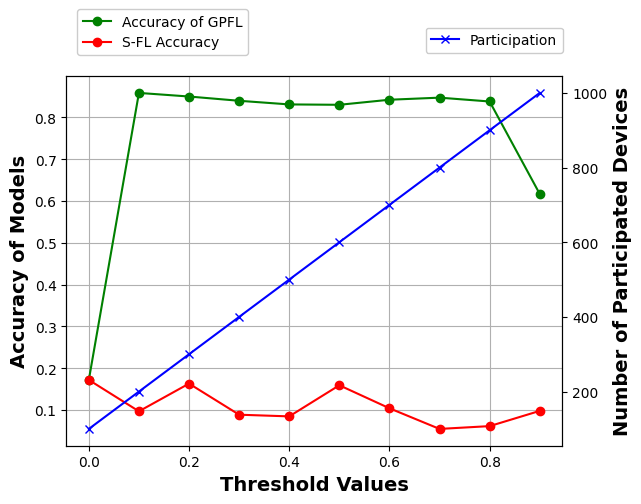

In [22]:
# create figure and axis objects with subplots()
fig, ax = plt.subplots()
plt.grid()

# Our Algo. Acc.
ax.plot(df['Threshold'].values, 
        df['GPFL Accuracy'].values, 
        color="green", 
        label='Accuracy of GPFL', 
        marker="o")

# S-FL Acc.
ax.plot(df['Threshold'].values, 
        df['SFL Accuracy'].values, 
        color="red", 
        label='S-FL Accuracy',
        marker="o")

plt.legend(framealpha=1, frameon=True, bbox_to_anchor=(0.38, 1.2));

# set x-axis label
ax.set_xlabel("Threshold Values", fontweight='bold', fontsize=14)
# set y-axis label
ax.set_ylabel("Accuracy of Models", color="black", fontweight='bold', fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(df['Threshold'].values, 
         df['Participation'].values, 
         color="blue", 
         label='Participation', 
         marker="x")

ax2.set_ylabel("Number of Participated Devices", color="black", fontweight='bold', fontsize=14)
# ax2.legend(loc='upper left', frameon=False)

#plt.legend(lines[:2], ['first', 'second']);
# plt.title("Initial Accuracy values of Standard Federated Learning", fontweight="bold")
plt.legend(framealpha=1, frameon=True, bbox_to_anchor=(1.015, 1.15));
plt.show()

# save the plot as a file
fig.savefig('Accuracy&Participation vs Threshold with S-FL.jpg', 
            format='jpeg', dpi=100, bbox_inches='tight')

### Initial Accuracy & Model Sparsity:

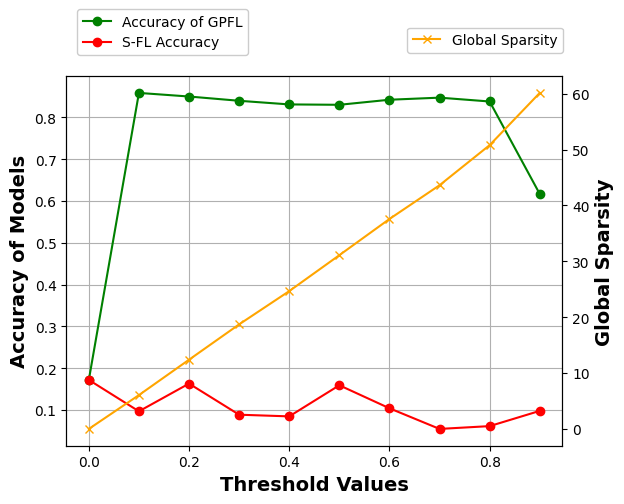

In [23]:
# create figure and axis objects with subplots()
fig, ax = plt.subplots()
plt.grid()
# make a plot
ax.plot(df['Threshold'].values, 
        df['GPFL Accuracy'].values, 
        label='Accuracy of GPFL', 
        color="green", 
        marker="o")

ax.plot(df['Threshold'].values, 
        df['SFL Accuracy'].values, 
        label='S-FL Accuracy', 
        color="red", 
        marker="o")

plt.legend(framealpha=1, frameon=True, bbox_to_anchor=(0.38, 1.2));

# set x-axis label
ax.set_xlabel("Threshold Values", fontweight='bold', fontsize = 14)
# set y-axis label
ax.set_ylabel("Accuracy of Models", color="black", fontweight='bold', fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(df['Threshold'].values, 
         df['Global Sparsity'].values, 
         label='Global Sparsity', 
         color="orange", 
         marker="x")

ax2.set_ylabel("Global Sparsity", color="black", fontweight='bold', fontsize=14)

plt.legend(framealpha=1, frameon=True, bbox_to_anchor=(1.015, 1.15));
plt.show()
# save the plot as a file
fig.savefig('Accuracy&Global_Sparsity vs Threshold with S-FL.jpg', 
            format='jpeg', dpi=100, bbox_inches='tight')

***
### Initial Loss & Partcipation:

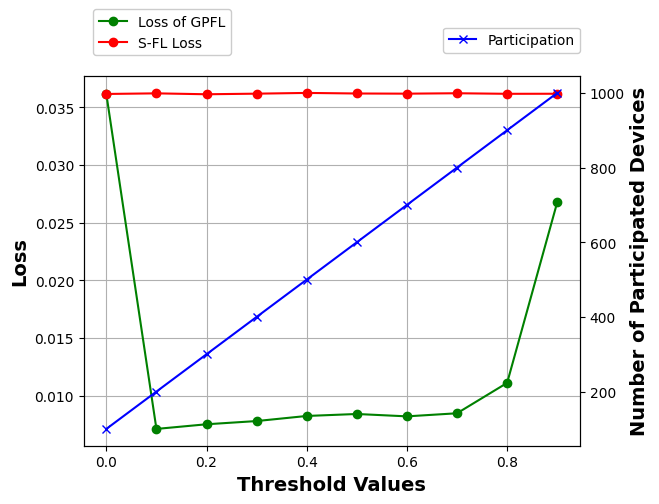

In [24]:
# create figure and axis objects with subplots()
fig, ax = plt.subplots()
plt.grid()
# make a plot
ax.plot(df['Threshold'].values, 
        df['GPFL Loss'].values, 
        color="green", 
        label='Loss of GPFL', 
        marker="o")

ax.plot(df['Threshold'].values, 
        df['SFL Loss'].values, 
        color="red", 
        label='S-FL Loss', 
        marker="o")

plt.legend(framealpha=1, frameon=True, bbox_to_anchor=(0.31, 1.2));

# set x-axis label
ax.set_xlabel("Threshold Values", fontweight='bold', fontsize = 14)
# set y-axis label
ax.set_ylabel("Loss", color="black", fontweight='bold', fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(df['Threshold'].values, 
         df['Participation'].values, 
         label='Participation', 
         color="blue", 
         marker="x")
ax2.set_ylabel("Number of Participated Devices", fontweight='bold', color="black", fontsize=14)

plt.legend(framealpha=1, frameon=True, bbox_to_anchor=(1.015, 1.15));
plt.show()
# save the plot as a file
fig.savefig('Loss&Participation vs Threshold with S-FL.jpg', 
            format='jpeg', dpi=100, bbox_inches='tight')

### Loss & Model Sparsity:

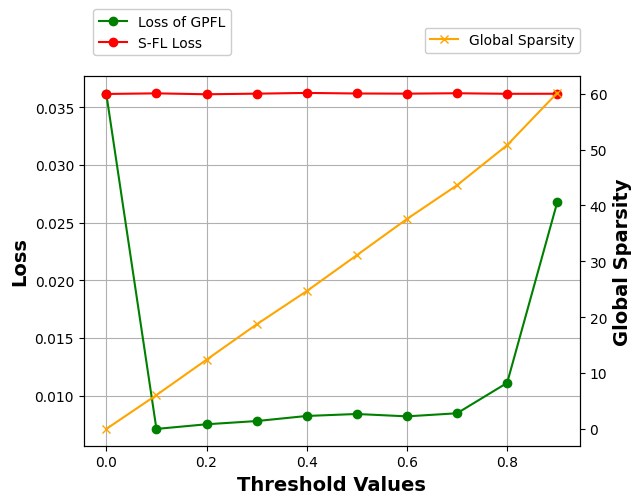

(raylet) [2023-02-01 12:31:41,560 E 38235 38235] (raylet) node_manager.cc:3097: 1 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 7e8848a3d8041b6df27e0004bdf18a201f5eea8aa0b92c438a1b7202, IP: 137.43.23.126) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 137.43.23.126`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
(raylet) [2023-02-01 12:32:41,561 E 38235 38235] (raylet) node_manager.cc:3097: 1 Workers (tasks / actors) killed d

In [25]:
# create figure and axis objects with subplots()
fig, ax = plt.subplots()
plt.grid()
# make a plot
ax.plot(df['Threshold'].values, 
        df['GPFL Loss'].values, 
        color="green", 
        label='Loss of GPFL', 
        marker="o")

ax.plot(df['Threshold'].values, 
        df['SFL Loss'], 
        color="red", 
        label='S-FL Loss',
        marker="o")

plt.legend(framealpha=1, frameon=True, bbox_to_anchor=(0.31, 1.2));

# set x-axis label
ax.set_xlabel("Threshold Values", fontweight='bold', fontsize = 14)
# set y-axis label
ax.set_ylabel("Loss", color="black", fontweight='bold', fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(df['Threshold'].values, 
         df['Global Sparsity'].values, 
         label='Global Sparsity', 
         color="orange", 
         marker="x")
ax2.set_ylabel("Global Sparsity",color="black", fontweight='bold', fontsize=14)

plt.legend(framealpha=1, frameon=True, bbox_to_anchor=(1.015, 1.15));
plt.show()
# save the plot as a file
fig.savefig('Loss&Global_Sparsity vs Threshold with S-FL.jpg', 
            format='jpeg', dpi=100, bbox_inches='tight')